In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import numpy as np
from lie_vae.datasets import ToyDataset
from lie_vae.vae import ChairsVAE
from lie_vae.lie_tools import block_wigner_matrix_multiply, random_quaternions, quaternions_to_eazyz, \
    group_matrix_to_eazyz, group_matrix_to_quaternions, random_group_matrices, rodrigues, quaternions_to_group_matrix, vector_to_eazyz, SO3_coordinates
from lie_vae.utils import expand_dim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict

torch.no_grad().__enter__()

In [18]:
device = torch.device('cuda:0')
# Dataset: https://drive.google.com/open?id=1uIbBbqDVlPNP047n4parVMJtOWj21pTJ
dataset = ToyDataset()
spectrum = dataset[0][1].to(device)

def data_gen(g):
    angles = quaternions_to_eazyz(group_matrix_to_quaternions(g))
    return block_wigner_matrix_multiply(angles, expand_dim(spectrum, angles.shape[0]), 3)

In [19]:
def circle(n, mu=None, device=None):
    start = torch.zeros(1, 3, device=device)
    end = torch.randn(1, 3, device=device)
    end = end / end.norm() * 2 * np.pi
    end = end + start
    t = torch.linspace(0, 1, n).to(device)[:, None]
    x = (1-t) * start + end * t
    g = rodrigues(x)
    g[0] = torch.eye(3, device=device)
    if mu is not None:
        if mu == 'random':
            mu = random_group_matrices(1, device=device)[0]
        g = expand_dim(mu, n).bmm(g)
    return g

def random_walk2(n, scale=0.1, start='random', device=None, qr_freq=None):
    x = rodrigues(torch.randn(n-1, 3, device=device) * scale)
    if start == 'random':
        start = random_group_matrices(1, device=device)[0]
    elif start == 'e':
        start = torch.eye(3, device=device)
    else:
        raise ValueError()
    gs = [start]
    for i in range(n-1):
        gs.append(gs[i] @ x[i])
        
        if qr_freq is not None and (i+1)%qr_freq == 0:
            gs[-1] = torch.qr(gs[-1])[0]
    
    return torch.stack(gs, 0)

def random_walk(n, scale=0.1, start='random', device=None, qr_freq=None, integrate=5):
    alg = torch.randn(n, 3, device=device) * scale
    for _ in range(integrate):
        alg = torch.cumsum(alg, 0)
    g = rodrigues(alg)
    g[0] = torch.eye(3, device=device)
    if start is not None:
        if start == 'random':
            start = random_group_matrices(1, device=device)[0]
        g = expand_dim(start, n).bmm(g)
    return g

def repeated_colors(n, sections):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    repeats = int(np.ceil(n / sections))
    return np.repeat(np.array(colors[:sections]), repeats)

def discontinuities(x, zero_mean=False):
    x = np.asarray(x)
    d = x[1:]-x[:-1]
    disc = (d**2).reshape((x.shape[0]-1, -1)).sum(1)
    if zero_mean:
        disc -= disc.mean()
    return disc

In [20]:
model_names = [
    'toyl3-3-ae-action-q',
    'toyl3-3-ae-action-alg',
    'toyl3-3-ae-action-s2s2',
    'toyl3-3-ae-action-s2s1',
    'toyl3-3-ae-mlp-q',
    'toyl3-3-ae-mlp-alg',
    'toyl3-3-ae-mlp-s2s2',
    'toyl3-3-ae-mlp-s2s1',
    'toyl3-3-ae-action-normal3',
    'toyl3-3-ae-mlp-normal30',
    'toyl3-3-ae-mlp-normal3',
    'toyl3-3-ae-action-vmfq',
    'toyl3-3-ae-mlp-vmf',
    'toyl3-3-vae-action-q',
    'toyl3-3-vae-action-alg',
    'toyl3-3-vae-action-s2s2',
    'toyl3-3-vae-action-s2s1',
    'toyl3-3-vae-mlp-q',
    'toyl3-3-vae-mlp-alg',
    'toyl3-3-vae-mlp-s2s2',
    'toyl3-3-vae-mlp-s2s1',
    'toyl3-3-vae-action-normal3',
    'toyl3-3-vae-mlp-normal30',
    'toyl3-3-vae-mlp-normal3',
    'toyl3-3-vae-action-vmfq',
    'toyl3-3-vae-mlp-vmf',
]
parts = [n.split('-')[2:] for n in model_names]

models = OrderedDict()
for name in model_names:
    parts = name.split('-')[2:]
    
    normal_dims = 3
    if parts[2] == 'normal3':
        latent = 'normal'
    elif parts[2] == 'normal30':
        latent = 'normal'
        normal_dims = 30
    elif parts[2] in ['s2s2', 'alg', 's2s1', 'q']:
        latent = 'so3'
    elif parts[2] in ['vmf', 'vmfq']:
        latent = parts[2]
    else:
        raise RuntimeError()
    
    model = ChairsVAE(
        latent_mode=latent,
        mean_mode=parts[2],
        decoder_mode=parts[1],
        encode_mode='toy',
        deconv_mode='toy',
        rep_copies=3,
        degrees=3,
        deterministic=(parts[0] == 'ae'),
        single_id=True,
        normal_dims=normal_dims
    ).to(device)
    model.load_state_dict(torch.load('outputs/'+name+'/model.pickle'))
    
    models['-'.join(parts)] = model

In [21]:
g = circle(1000, 'random', device=device)
# g = random_walk(1000, start='random', scale=1E-12, device=device, qr_freq=1)

In [22]:
import json
j = json.dumps(g.tolist())
print(j)

[[[-0.3424311876296997, 0.6900020837783813, 0.6376816630363464], [-0.7408779859542847, -0.6156949996948242, 0.26836445927619934], [0.5777894854545593, -0.38054797053337097, 0.7220405340194702]], [[-0.34624183177948, 0.6857170462608337, 0.6402410864830017], [-0.7385571599006653, -0.620058536529541, 0.2646898627281189], [0.5784893035888672, -0.38120797276496887, 0.721131443977356]], [[-0.35003721714019775, 0.6814043521881104, 0.6427767872810364], [-0.7362127304077148, -0.6243959665298462, 0.26099929213523865], [0.5791932344436646, -0.38186100125312805, 0.7202203869819641]], [[-0.3538171648979187, 0.6770642995834351, 0.6452885270118713], [-0.7338446974754333, -0.6287068724632263, 0.25729286670684814], [0.5799010992050171, -0.38250696659088135, 0.7193073630332947]], [[-0.35758164525032043, 0.6726970076560974, 0.6477762460708618], [-0.7314532995223999, -0.6329913139343262, 0.2535707354545593], [0.5806130766868591, -0.38314583897590637, 0.7183924913406372]], [[-0.36133038997650146, 0.6683026

In [23]:
j = '[[[0.25032445788383484, -0.9298439621925354, 0.2696811556816101], [0.773210346698761, 0.3596407473087311, 0.5223067998886108], [-0.5826520919799805, 0.07777407765388489, 0.8089917898178101]], [[0.25609639286994934, -0.9284017086029053, 0.2692303955554962], [0.7731644511222839, 0.363901823759079, 0.5194153189659119], [-0.5801994800567627, 0.07513894885778427, 0.8110010623931885]], [[0.2618591785430908, -0.9269296526908875, 0.2687586545944214], [0.7730863094329834, 0.3681611716747284, 0.5165220499038696], [-0.5777260661125183, 0.07251755148172379, 0.8130029439926147]], [[0.2676125466823578, -0.9254279732704163, 0.268265962600708], [0.7729758024215698, 0.37241870164871216, 0.5136271715164185], [-0.5752321481704712, 0.06991000473499298, 0.8149973154067993]], [[0.27335622906684875, -0.9238966703414917, 0.2677523195743561], [0.772832989692688, 0.37667417526245117, 0.5107306241989136], [-0.5727176666259766, 0.06731641292572021, 0.8169840574264526]], [[0.2790900766849518, -0.9223359227180481, 0.267217755317688], [0.7726579904556274, 0.3809274435043335, 0.5078326463699341], [-0.5701828002929688, 0.06473685055971146, 0.8189632296562195]], [[0.2848138213157654, -0.9207454919815063, 0.26666226983070374], [0.7724506855010986, 0.3851783871650696, 0.5049333572387695], [-0.5676276087760925, 0.06217145547270775, 0.8209345936775208]], [[0.29052719473838806, -0.9191257953643799, 0.2660859227180481], [0.7722110748291016, 0.3894267678260803, 0.5020328164100647], [-0.5650522112846375, 0.05962028354406357, 0.8228981494903564]], [[0.2962300777435303, -0.9174766540527344, 0.26548871397972107], [0.7719391584396362, 0.39367246627807617, 0.4991311728954315], [-0.5624567270278931, 0.05708348751068115, 0.8248538374900818]], [[0.30192214250564575, -0.9157983064651489, 0.26487070322036743], [0.771635115146637, 0.3979152739048004, 0.49622851610183716], [-0.5598412752151489, 0.054561126977205276, 0.8268015384674072]], [[0.30760324001312256, -0.9140907526016235, 0.2642318606376648], [0.7712988257408142, 0.4021550714969635, 0.49332499504089355], [-0.5572059750556946, 0.05205332860350609, 0.828741192817688]], [[0.3132731020450592, -0.9123539328575134, 0.26357221603393555], [0.770930290222168, 0.4063916504383087, 0.49042069911956787], [-0.5545507669448853, 0.04956018924713135, 0.8306728005409241]], [[0.3189314901828766, -0.9105880856513977, 0.26289185881614685], [0.770529568195343, 0.41062483191490173, 0.48751574754714966], [-0.5518758893013, 0.04708177596330643, 0.8325961232185364]], [[0.32457825541496277, -0.9087931513786316, 0.2621907591819763], [0.7700966000556946, 0.414854496717453, 0.48461025953292847], [-0.5491814613342285, 0.044618215411901474, 0.8345112204551697]], [[0.33021309971809387, -0.9069693088531494, 0.26146891713142395], [0.7696315050125122, 0.4190804660320282, 0.48170435428619385], [-0.5464675426483154, 0.04216962307691574, 0.8364179134368896]], [[0.3358357846736908, -0.905116617679596, 0.2607264518737793], [0.7691341638565063, 0.4233025312423706, 0.47879815101623535], [-0.5437342524528503, 0.039736058562994, 0.8383162021636963]], [[0.3414461612701416, -0.903235137462616, 0.25996333360671997], [0.7686047554016113, 0.4275205731391907, 0.47589176893234253], [-0.5409817099571228, 0.03731761500239372, 0.8402060270309448]], [[0.3470439612865448, -0.9013248085975647, 0.25917959213256836], [0.7680432200431824, 0.4317343831062317, 0.47298526763916016], [-0.5382100939750671, 0.03491443023085594, 0.8420872688293457]], [[0.35262900590896606, -0.899385929107666, 0.25837525725364685], [0.7674496173858643, 0.4359438419342041, 0.47007879614830017], [-0.5354193449020386, 0.03252657130360603, 0.8439598083496094]], [[0.3582010567188263, -0.8974184393882751, 0.2575503885746002], [0.7668238878250122, 0.4401487410068512, 0.4671725034713745], [-0.5326095819473267, 0.030154123902320862, 0.8458236455917358]], [[0.363759845495224, -0.8954224586486816, 0.25670498609542847], [0.7661662697792053, 0.4443489611148834, 0.46426647901535034], [-0.5297811627388, 0.027797196060419083, 0.8476787209510803]], [[0.36930519342422485, -0.8933980464935303, 0.25583913922309875], [0.7654765248298645, 0.44854432344436646, 0.4613608121871948], [-0.526934027671814, 0.02545587532222271, 0.8495249152183533]], [[0.37483683228492737, -0.8913453221321106, 0.2549527883529663], [0.7647547721862793, 0.4527345895767212, 0.4584556818008423], [-0.5240681767463684, 0.023130280897021294, 0.8513621687889099]], [[0.3803546726703644, -0.8892642855644226, 0.25404608249664307], [0.7640011310577393, 0.45691967010498047, 0.4555511474609375], [-0.521183967590332, 0.020820453763008118, 0.8531903624534607]], [[0.38585832715034485, -0.8871551156044006, 0.25311893224716187], [0.7632154822349548, 0.46109938621520996, 0.4526473581790924], [-0.5182813405990601, 0.01852654293179512, 0.8550094962120056]], [[0.391347736120224, -0.8850178718566895, 0.25217148661613464], [0.7623979449272156, 0.46527355909347534, 0.4497443735599518], [-0.5153604745864868, 0.01624857634305954, 0.8568194508552551]], [[0.3968225419521332, -0.8828525543212891, 0.251203715801239], [0.7615485191345215, 0.4694420397281647, 0.44684234261512756], [-0.5124214291572571, 0.013986693695187569, 0.8586201667785645]], [[0.40228259563446045, -0.880659282207489, 0.25021564960479736], [0.7606673240661621, 0.47360461950302124, 0.4439414143562317], [-0.5094643831253052, 0.011740963906049728, 0.8604115843772888]], [[0.4077277183532715, -0.8784382939338684, 0.24920740723609924], [0.7597543001174927, 0.4777612090110779, 0.4410416781902313], [-0.5064894556999207, 0.009511490352451801, 0.8621937036514282]], [[0.4131576418876648, -0.8761895298957825, 0.24817895889282227], [0.758809506893158, 0.4819115698337555, 0.43814319372177124], [-0.5034967660903931, 0.00729833310469985, 0.8639662861824036]], [[0.4185721278190613, -0.873913049697876, 0.2471303641796112], [0.7578330039978027, 0.4860556423664093, 0.43524616956710815], [-0.5004863142967224, 0.005101605784147978, 0.8657293915748596]], [[0.4239710569381714, -0.8716089725494385, 0.24606163799762726], [0.7568247318267822, 0.49019309878349304, 0.43235063552856445], [-0.4974583685398102, 0.0029213931411504745, 0.8674829006195068]], [[0.42935413122177124, -0.8692774772644043, 0.24497286975383759], [0.7557848691940308, 0.4943239390850067, 0.42945677042007446], [-0.49441301822662354, 0.0007577608921565115, 0.8692267537117004]], [[0.4347211420536041, -0.8669186234474182, 0.24386408925056458], [0.7547134757041931, 0.49844786524772644, 0.42656466364860535], [-0.49135032296180725, -0.0013891721609979868, 0.8709608912467957]], [[0.4400719106197357, -0.8645324110984802, 0.24273531138896942], [0.7536104321479797, 0.5025647878646851, 0.42367443442344666], [-0.48827046155929565, -0.003519345074892044, 0.8726851940155029]], [[0.4454062283039093, -0.8621189594268799, 0.2415866255760193], [0.7524758577346802, 0.5066745281219482, 0.42078620195388794], [-0.4851735830307007, -0.005632675252854824, 0.874399721622467]], [[0.4507238566875458, -0.8596785068511963, 0.24041806161403656], [0.7513098120689392, 0.5107769966125488, 0.41790005564689636], [-0.48205968737602234, -0.007729093544185162, 0.8761042356491089]], [[0.4560245871543884, -0.8572110533714294, 0.23922961950302124], [0.7501124143600464, 0.5148718953132629, 0.4150161147117615], [-0.47892895340919495, -0.009808454662561417, 0.8777987957000732]], [[0.4613082706928253, -0.8547167181968689, 0.23802141845226288], [0.7488835453987122, 0.5189591646194458, 0.4121345579624176], [-0.4757815897464752, -0.011870745569467545, 0.8794833421707153]], [[0.46657460927963257, -0.8521954417228699, 0.23679345846176147], [0.7476234436035156, 0.5230385661125183, 0.40925538539886475], [-0.4726176857948303, -0.01391586009413004, 0.8811576962471008]], [[0.47182345390319824, -0.8496475219726562, 0.2355457991361618], [0.7463319301605225, 0.5271100997924805, 0.4063788056373596], [-0.46943727135658264, -0.01594371721148491, 0.8828218579292297]], [[0.47705453634262085, -0.847072958946228, 0.23427847027778625], [0.745009183883667, 0.5311733484268188, 0.403504878282547], [-0.46624046564102173, -0.01795419305562973, 0.8844757676124573]], [[0.48226773738861084, -0.8444719314575195, 0.23299159109592438], [0.7436553835868835, 0.5352283120155334, 0.40063372254371643], [-0.46302759647369385, -0.019947290420532227, 0.8861193656921387]], [[0.4874627888202667, -0.8418444395065308, 0.23168514668941498], [0.7422704100608826, 0.5392748713493347, 0.39776551723480225], [-0.45979857444763184, -0.021922875195741653, 0.8877525925636292]], [[0.4926394820213318, -0.8391907215118408, 0.23035918176174164], [0.7408542633056641, 0.5433127880096436, 0.39490026235580444], [-0.4565536677837372, -0.023880869150161743, 0.8893753290176392]], [[0.4977976679801941, -0.8365107774734497, 0.22901380062103271], [0.7394071817398071, 0.5473418831825256, 0.3920381963253021], [-0.45329293608665466, -0.025821227580308914, 0.8909875154495239]], [[0.5029370784759521, -0.833804726600647, 0.2276490181684494], [0.7379291653633118, 0.5513620376586914, 0.3891793191432953], [-0.4500165283679962, -0.027743853628635406, 0.8925891518592834]], [[0.5080575346946716, -0.8310726881027222, 0.22626490890979767], [0.736420214176178, 0.5553730726242065, 0.38632380962371826], [-0.446724534034729, -0.029648661613464355, 0.8941801190376282]], [[0.5131588578224182, -0.8283147811889648, 0.2248615324497223], [0.7348804473876953, 0.5593748092651367, 0.3834717869758606], [-0.44341716170310974, -0.03153559938073158, 0.8957604169845581]], [[0.518240749835968, -0.8255311250686646, 0.22343890368938446], [0.7333099246025085, 0.5633671879768372, 0.38062334060668945], [-0.4400944411754608, -0.03340455889701843, 0.8973299264907837]], [[0.5233031511306763, -0.8227217793464661, 0.22199712693691254], [0.7317087054252625, 0.5673499703407288, 0.377778559923172], [-0.4367566406726837, -0.03525551036000252, 0.8988885879516602]], [[0.5283457636833191, -0.8198869228363037, 0.22053620219230652], [0.7300766706466675, 0.5713229775428772, 0.3749375641345978], [-0.43340373039245605, -0.03708833083510399, 0.9004363417625427]], [[0.5333684086799622, -0.8170266151428223, 0.21905626356601715], [0.7284141182899475, 0.5752860903739929, 0.3721005320549011], [-0.4300360083580017, -0.03890298306941986, 0.9019731283187866]], [[0.5383709669113159, -0.8141409754753113, 0.21755734086036682], [0.7267211079597473, 0.5792391896247864, 0.3692675232887268], [-0.42665350437164307, -0.04069940745830536, 0.9034989476203918]], [[0.5433531403541565, -0.8112301826477051, 0.21603946387767792], [0.7249975800514221, 0.5831820368766785, 0.3664386570453644], [-0.4232563376426697, -0.04247749596834183, 0.9050136804580688]], [[0.5483146905899048, -0.8082942366600037, 0.21450267732143402], [0.7232436537742615, 0.5871146321296692, 0.3636139929294586], [-0.41984468698501587, -0.044237203896045685, 0.9065172076225281]], [[0.5532556176185608, -0.8053333759307861, 0.21294710040092468], [0.7214594483375549, 0.5910366177558899, 0.36079370975494385], [-0.4164187014102936, -0.04597843438386917, 0.9080096483230591]], [[0.5581754446029663, -0.8023476004600525, 0.21137277781963348], [0.7196449637413025, 0.594947874546051, 0.3579779267311096], [-0.41297847032546997, -0.0477011501789093, 0.909490704536438]], [[0.5630742311477661, -0.7993371486663818, 0.209779754281044], [0.7178003787994385, 0.5988483428955078, 0.3551667332649231], [-0.4095241129398346, -0.04940525069832802, 0.9109604954719543]], [[0.5679517388343811, -0.7963020205497742, 0.20816810429096222], [0.7159256339073181, 0.6027378439903259, 0.35236021876335144], [-0.40605589747428894, -0.05109069123864174, 0.9124189615249634]], [[0.5728076100349426, -0.7932423949241638, 0.2065378874540329], [0.7140207886695862, 0.606616199016571, 0.3495585024356842], [-0.402573823928833, -0.05275740846991539, 0.9138659238815308]], [[0.5776419043540955, -0.7901584506034851, 0.2048892080783844], [0.7120860815048218, 0.6104832291603088, 0.3467617332935333], [-0.39907804131507874, -0.054405346512794495, 0.9153014421463013]], [[0.5824542045593262, -0.7870501279830933, 0.20322203636169434], [0.7101214528083801, 0.6143388748168945, 0.3439699709415436], [-0.39556872844696045, -0.0560343973338604, 0.9167253971099854]], [[0.5872443914413452, -0.7839178442955017, 0.20153650641441345], [0.7081270217895508, 0.6181828379631042, 0.3411833345890045], [-0.3920460641384125, -0.057644523680210114, 0.9181377291679382]], [[0.592012345790863, -0.7807613611221313, 0.19983269274234772], [0.7061029076576233, 0.6220151782035828, 0.33840200304985046], [-0.388510137796402, -0.059235699474811554, 0.9195384383201599]], [[0.596757709980011, -0.7775812149047852, 0.1981106698513031], [0.7040491700172424, 0.6258355379104614, 0.3356260061264038], [-0.3849610984325409, -0.06080777570605278, 0.9209274053573608]], [[0.6014804840087891, -0.7743771076202393, 0.1963704377412796], [0.701965868473053, 0.6296437978744507, 0.3328554630279541], [-0.3813990652561188, -0.062360748648643494, 0.922304630279541]], [[0.6061804294586182, -0.7711494565010071, 0.19461213052272797], [0.6998530030250549, 0.6334398984909058, 0.3300905227661133], [-0.37782418727874756, -0.06389454752206802, 0.9236700534820557]], [[0.6108573079109192, -0.7678982615470886, 0.19283577799797058], [0.6977108120918274, 0.6372236013412476, 0.3273312747478485], [-0.3742365539073944, -0.06540906429290771, 0.9250235557556152]], [[0.6155109405517578, -0.764623761177063, 0.1910414844751358], [0.6955392956733704, 0.6409948468208313, 0.32457783818244934], [-0.3706364631652832, -0.06690434366464615, 0.9263651371002197]], [[0.6201412081718445, -0.7613259553909302, 0.18922927975654602], [0.6933385133743286, 0.6447534561157227, 0.32183027267456055], [-0.36702391505241394, -0.06838024407625198, 0.9276947975158691]], [[0.6247479915618896, -0.7580050230026245, 0.18739928305149078], [0.6911086440086365, 0.6484993100166321, 0.3190886974334717], [-0.36339911818504333, -0.06983677297830582, 0.9290123581886292]], [[0.6293308734893799, -0.7546610832214355, 0.18555153906345367], [0.6888497471809387, 0.6522321105003357, 0.31635332107543945], [-0.3597622215747833, -0.07127377390861511, 0.9303178191184998]], [[0.6338897347450256, -0.7512943148612976, 0.18368609249591827], [0.6865617632865906, 0.6559518575668335, 0.31362414360046387], [-0.3561131954193115, -0.07269123941659927, 0.9316111207008362]], [[0.6384245753288269, -0.7479048371315002, 0.18180309236049652], [0.6842450499534607, 0.6596583724021912, 0.31090131402015686], [-0.35245248675346375, -0.0740891844034195, 0.9328922629356384]], [[0.6429351568222046, -0.744492769241333, 0.17990253865718842], [0.6818995475769043, 0.6633515357971191, 0.3081849217414856], [-0.34877997636795044, -0.07546743005514145, 0.9341611862182617]], [[0.6474210619926453, -0.7410582900047302, 0.1779845654964447], [0.6795253157615662, 0.6670310497283936, 0.3054750859737396], [-0.34509608149528503, -0.07682597637176514, 0.9354177713394165]], [[0.6518824696540833, -0.7376015186309814, 0.17604921758174896], [0.6771225333213806, 0.6706969141960144, 0.3027719557285309], [-0.3414006531238556, -0.07816480100154877, 0.9366620779037476]], [[0.6563189625740051, -0.7341225147247314, 0.17409658432006836], [0.6746911406517029, 0.6743489503860474, 0.3000755310058594], [-0.33769404888153076, -0.07948383688926697, 0.9378939270973206]], [[0.6607304215431213, -0.7306215167045593, 0.17212671041488647], [0.6722314953804016, 0.6779870390892029, 0.2973859906196594], [-0.33397623896598816, -0.08078300207853317, 0.939113438129425]], [[0.6651167869567871, -0.7270985245704651, 0.17013971507549286], [0.6697434782981873, 0.6816110014915466, 0.29470348358154297], [-0.33024755120277405, -0.0820622518658638, 0.9403203129768372]], [[0.669477641582489, -0.7235538363456726, 0.1681356579065323], [0.6672273278236389, 0.6852207779884338, 0.2920280396938324], [-0.3265079855918884, -0.08332154154777527, 0.941514790058136]], [[0.673812985420227, -0.7199874520301819, 0.16611462831497192], [0.6646829843521118, 0.6888160705566406, 0.28935983777046204], [-0.3227578401565552, -0.08456084877252579, 0.9426965713500977]], [[0.6781226396560669, -0.7163996696472168, 0.16407667100429535], [0.6621106863021851, 0.6923968195915222, 0.2866988778114319], [-0.3189971148967743, -0.0857800841331482, 0.9438657760620117]], [[0.682406485080719, -0.7127905488014221, 0.16202187538146973], [0.6595104932785034, 0.6959629058837891, 0.2840452790260315], [-0.3152259588241577, -0.0869792103767395, 0.9450222849845886]], [[0.6866642236709595, -0.7091602087020874, 0.1599504053592682], [0.6568824648857117, 0.6995141506195068, 0.28139927983283997], [-0.3114446997642517, -0.08815819770097733, 0.9461661577224731]], [[0.6908957362174988, -0.705508828163147, 0.15786223113536835], [0.6542267203330994, 0.703050434589386, 0.2787608802318573], [-0.3076533079147339, -0.0893169716000557, 0.9472971558570862]], [[0.6951009035110474, -0.7018365263938904, 0.15575748682022095], [0.6515434980392456, 0.7065715789794922, 0.27613013982772827], [-0.30385199189186096, -0.09045552462339401, 0.9484153985977173]], [[0.6992794871330261, -0.6981434226036072, 0.15363624691963196], [0.6488326191902161, 0.7100775241851807, 0.2735072672367096], [-0.3000408709049225, -0.09157376736402512, 0.9495207667350769]], [[0.7034313082695007, -0.6944297552108765, 0.15149863064289093], [0.6460945010185242, 0.7135680317878723, 0.27089232206344604], [-0.2962202727794647, -0.09267167747020721, 0.950613260269165]], [[0.7075562477111816, -0.690695583820343, 0.14934465289115906], [0.6433290243148804, 0.7170431017875671, 0.2682854235172272], [-0.2923901081085205, -0.09374924749135971, 0.9516927599906921]], [[0.7116541862487793, -0.6869411468505859, 0.14717449247837067], [0.6405364871025085, 0.7205024361610413, 0.26568663120269775], [-0.28855061531066895, -0.09480638802051544, 0.952759325504303]], [[0.7157248258590698, -0.6831664443016052, 0.14498814940452576], [0.6377168297767639, 0.7239459753036499, 0.2630961239337921], [-0.28470197319984436, -0.09584307670593262, 0.953812837600708]], [[0.7197681665420532, -0.6793718338012695, 0.14278572797775269], [0.6348702907562256, 0.7273736000061035, 0.26051393151283264], [-0.2808443605899811, -0.09685919433832169, 0.9548532366752625]], [[0.7237839698791504, -0.6755571961402893, 0.14056731760501862], [0.6319968700408936, 0.7307851910591125, 0.2579401731491089], [-0.2769777774810791, -0.09785483032464981, 0.9558805823326111]], [[0.7277721166610718, -0.6717230081558228, 0.1383330374956131], [0.6290968060493469, 0.7341804504394531, 0.255374938249588], [-0.2731025815010071, -0.09882987290620804, 0.9568947553634644]], [[0.7317324280738831, -0.6678691506385803, 0.13608293235301971], [0.6261700391769409, 0.7375594973564148, 0.25281834602355957], [-0.269218772649765, -0.09978430718183517, 0.9578957557678223]], [[0.7356646656990051, -0.6639958024024963, 0.1338171660900116], [0.6232168078422546, 0.7409220933914185, 0.2502705454826355], [-0.2653266191482544, -0.10071808844804764, 0.95888352394104]], [[0.739568829536438, -0.6601033210754395, 0.13153572380542755], [0.6202373504638672, 0.7442679405212402, 0.247731551527977], [-0.26142624020576477, -0.10163112729787827, 0.9598580002784729]], [[0.7434446215629578, -0.6561916470527649, 0.1292387694120407], [0.617231547832489, 0.7475971579551697, 0.24520154297351837], [-0.25751766562461853, -0.10252346098423004, 0.9608191847801208]], [[0.7472919225692749, -0.6522610187530518, 0.12692636251449585], [0.6141996383666992, 0.7509094476699829, 0.24268054962158203], [-0.2536012530326843, -0.10339506715536118, 0.9617670178413391]], [[0.7511106729507446, -0.6483116149902344, 0.12459864467382431], [0.6111417412757874, 0.7542048692703247, 0.2401687204837799], [-0.24967700242996216, -0.1042458638548851, 0.9627014994621277]], [[0.7549005746841431, -0.6443436145782471, 0.12225561589002609], [0.6080579161643982, 0.7574829459190369, 0.23766610026359558], [-0.24574515223503113, -0.10507576912641525, 0.9636225700378418]], [[0.7586616277694702, -0.6403570771217346, 0.11989746242761612], [0.6049484014511108, 0.7607438564300537, 0.23517286777496338], [-0.2418058067560196, -0.10588487237691879, 0.9645301103591919]], [[0.762393593788147, -0.6363521814346313, 0.11752422153949738], [0.6018131971359253, 0.7639874219894409, 0.23268911242485046], [-0.23785926401615143, -0.10667305439710617, 0.9654241800308228]], [[0.766096293926239, -0.6323291063308716, 0.11513599753379822], [0.5986523628234863, 0.7672134637832642, 0.23021486401557922], [-0.2339053750038147, -0.1074402928352356, 0.9663047194480896]], [[0.7697697281837463, -0.6282880902290344, 0.11273292452096939], [0.5954663157463074, 0.7704218029975891, 0.2277502566576004], [-0.2299446314573288, -0.10818659514188766, 0.9671717286109924]], [[0.7734135389328003, -0.6242291927337646, 0.11031501740217209], [0.5922549366950989, 0.7736124396324158, 0.22529540956020355], [-0.22597697377204895, -0.10891187191009521, 0.9680250883102417]], [[0.7770278453826904, -0.6201525926589966, 0.10788238793611526], [0.5890183448791504, 0.776785135269165, 0.22285032272338867], [-0.22200264036655426, -0.10961616784334183, 0.9688648581504822]], [[0.7806122303009033, -0.6160584688186646, 0.10543520748615265], [0.5857568383216858, 0.7799398303031921, 0.22041520476341248], [-0.2180217206478119, -0.11029937863349915, 0.9696909189224243]], [[0.7841667532920837, -0.6119468808174133, 0.10297350585460663], [0.5824704766273499, 0.7830764055252075, 0.21799010038375854], [-0.21403446793556213, -0.11096159368753433, 0.9705033898353577]], [[0.7876912355422974, -0.6078181862831116, 0.10049743205308914], [0.5791592597961426, 0.7861946225166321, 0.2155751883983612], [-0.21004100143909454, -0.11160262674093246, 0.9713020324707031]], [[0.7911853790283203, -0.603672444820404, 0.09800702333450317], [0.5758235454559326, 0.7892945408821106, 0.21317042410373688], [-0.20604147017002106, -0.1122225821018219, 0.9720869064331055]], [[0.7946491837501526, -0.5995097756385803, 0.09550242871046066], [0.5724632143974304, 0.7923758029937744, 0.21077604591846466], [-0.2020360678434372, -0.11282138526439667, 0.9728580117225647]], [[0.7980825304985046, -0.5953304767608643, 0.09298373013734818], [0.5690786242485046, 0.7954385876655579, 0.20839202404022217], [-0.1980249434709549, -0.11339898407459259, 0.9736153483390808]], [[0.8014852404594421, -0.5911345481872559, 0.09045097976922989], [0.5656697750091553, 0.7984824776649475, 0.20601847767829895], [-0.19400815665721893, -0.11395536363124847, 0.9743587970733643]], [[0.8048571944236755, -0.586922287940979, 0.08790436387062073], [0.5622369050979614, 0.8015074729919434, 0.20365558564662933], [-0.18998600542545319, -0.11449060589075089, 0.9750882983207703]], [[0.8081982731819153, -0.5826937556266785, 0.08534395694732666], [0.5587799549102783, 0.8045135736465454, 0.2013034075498581], [-0.18595854938030243, -0.11500459164381027, 0.9758039712905884]], [[0.811508297920227, -0.5784491896629333, 0.08276978880167007], [0.5552992224693298, 0.807500422000885, 0.19896192848682404], [-0.181925967335701, -0.11549729108810425, 0.9765056371688843]], [[0.8147872090339661, -0.5741887092590332, 0.0801820456981659], [0.5517948865890503, 0.8104681968688965, 0.19663141667842865], [-0.17788849771022797, -0.11596871167421341, 0.9771934151649475]], [[0.8180347681045532, -0.5699126720428467, 0.07758080959320068], [0.5482670068740845, 0.8134164810180664, 0.19431178271770477], [-0.17384622991085052, -0.11641880869865417, 0.9778671264648438]], [[0.8212509155273438, -0.5656208992004395, 0.07496614754199982], [0.5447156429290771, 0.8163453340530396, 0.1920032799243927], [-0.1697993278503418, -0.11684763431549072, 0.9785268902778625]], [[0.8244355916976929, -0.5613138675689697, 0.07233820855617523], [0.5411410927772522, 0.8192545771598816, 0.18970587849617004], [-0.16574791073799133, -0.11725505441427231, 0.9791725873947144]], [[0.8275884985923767, -0.5569915771484375, 0.0696970671415329], [0.5375434160232544, 0.8221442103385925, 0.18741974234580994], [-0.16169224679470062, -0.11764121800661087, 0.9798041582107544]], [[0.83070969581604, -0.5526542067527771, 0.06704284995794296], [0.5339227318763733, 0.8250138759613037, 0.18514494597911835], [-0.15763238072395325, -0.11800600588321686, 0.9804216623306274]], [[0.8337989449501038, -0.5483021140098572, 0.0643756315112114], [0.530279278755188, 0.8278637528419495, 0.18288154900074005], [-0.1535685509443283, -0.11834941059350967, 0.981024980545044]], [[0.8368560671806335, -0.5439351797103882, 0.06169553101062775], [0.5266130566596985, 0.8306934833526611, 0.180629700422287], [-0.14950089156627655, -0.11867136508226395, 0.9816142320632935]], [[0.839881181716919, -0.5395538806915283, 0.05900271236896515], [0.5229243040084839, 0.8335031270980835, 0.17838945984840393], [-0.1454295963048935, -0.11897194385528564, 0.9821893572807312]], [[0.8428739905357361, -0.5351580381393433, 0.05629715695977211], [0.5192131400108337, 0.836292564868927, 0.17616082727909088], [-0.1413547694683075, -0.11925119161605835, 0.9827502369880676]], [[0.8458343148231506, -0.530748188495636, 0.05357915163040161], [0.5154798626899719, 0.8390613794326782, 0.17394408583641052], [-0.13727664947509766, -0.11950888484716415, 0.9832968711853027]], [[0.8487621545791626, -0.5263242721557617, 0.050848621875047684], [0.5117242932319641, 0.8418099284172058, 0.17173923552036285], [-0.13319532573223114, -0.11974522471427917, 0.9838293194770813]], [[0.8516573905944824, -0.5218866467475891, 0.04810574650764465], [0.5079469084739685, 0.8445377945899963, 0.1695462167263031], [-0.12911096215248108, -0.11996005475521088, 0.9843474626541138]], [[0.8545198440551758, -0.5174353122711182, 0.04535064846277237], [0.5041477680206299, 0.847244918346405, 0.16736523807048798], [-0.1250237673521042, -0.12015348672866821, 0.9848513603210449]], [[0.8573495149612427, -0.5129704475402832, 0.04258343577384949], [0.5003268718719482, 0.8499312996864319, 0.16519640386104584], [-0.12093383818864822, -0.12032542377710342, 0.98534095287323]], [[0.8601460456848145, -0.5084924101829529, 0.03980422392487526], [0.49648454785346985, 0.8525967597961426, 0.163039892911911], [-0.11684142053127289, -0.12047594785690308, 0.985816240310669]], [[0.8629096150398254, -0.5040010213851929, 0.03701305761933327], [0.4926207363605499, 0.8552411794662476, 0.16089557111263275], [-0.11274660378694534, -0.12060495465993881, 0.986277163028717]], [[0.8656400442123413, -0.4994969367980957, 0.03421013429760933], [0.4887359142303467, 0.857864499092102, 0.15876363217830658], [-0.10864957422018051, -0.12071246653795242, 0.986723780632019]], [[0.8683370351791382, -0.4949800670146942, 0.03139554709196091], [0.48482996225357056, 0.860466480255127, 0.15664424002170563], [-0.1045505478978157, -0.12079846858978271, 0.9871559739112854]], [[0.8710006475448608, -0.49045050144195557, 0.028569353744387627], [0.4809030592441559, 0.8630472421646118, 0.1545373648405075], [-0.1004495695233345, -0.12086300551891327, 0.9875738024711609]], [[0.8736307621002197, -0.4859085977077484, 0.02573167346417904], [0.4769555330276489, 0.8656065464019775, 0.152443066239357], [-0.09634685516357422, -0.12090606987476349, 0.9879772067070007]], [[0.8762272596359253, -0.4813545048236847, 0.022882705554366112], [0.4729873538017273, 0.8681443333625793, 0.15036150813102722], [-0.09224267303943634, -0.12092763930559158, 0.9883662462234497]], [[0.8787901997566223, -0.4767882227897644, 0.02002246119081974], [0.4689987301826477, 0.8706604838371277, 0.14829279482364655], [-0.08813696354627609, -0.12092775106430054, 0.9887407422065735]], [[0.8813191056251526, -0.472210168838501, 0.017151078209280968], [0.4649898111820221, 0.8731547594070435, 0.14623691141605377], [-0.08403003960847855, -0.1209062859416008, 0.9891008734703064]], [[0.88381427526474, -0.4676204025745392, 0.014268752187490463], [0.46096086502075195, 0.875627338886261, 0.14419405162334442], [-0.0799221396446228, -0.1208634153008461, 0.9894465208053589]], [[0.8862752914428711, -0.46301934123039246, 0.011375484056770802], [0.45691201090812683, 0.8780779242515564, 0.1421641707420349], [-0.07581333070993423, -0.12079896032810211, 0.9897777438163757]], [[0.8887021541595459, -0.4584067463874817, 0.008471406996250153], [0.4528432786464691, 0.8805065155029297, 0.14014743268489838], [-0.07170365005731583, -0.12071304023265839, 0.9900943636894226]], [[0.8910948634147644, -0.4537830650806427, 0.005556732881814241], [0.44875502586364746, 0.8829129338264465, 0.1381438821554184], [-0.06759346276521683, -0.12060569226741791, 0.9903965592384338]], [[0.8934533596038818, -0.4491484761238098, 0.002631492679938674], [0.44464728236198425, 0.8852971792221069, 0.1361536830663681], [-0.0634828582406044, -0.12047681212425232, 0.9906842112541199]], [[0.8957772254943848, -0.4445030987262726, -0.00030416325898841023], [0.4405202269554138, 0.8876590728759766, 0.1341768056154251], [-0.059372011572122574, -0.12032651156187057, 0.9909573793411255]], [[0.8980667591094971, -0.4398471415042877, -0.0032502051908522844], [0.4363740384578705, 0.8899984955787659, 0.1322133094072342], [-0.05526096746325493, -0.12015464156866074, 0.9912159442901611]], [[0.9003217816352844, -0.4351807236671448, -0.006206377875059843], [0.4322088360786438, 0.8923155069351196, 0.13026343286037445], [-0.051150042563676834, -0.11996139585971832, 0.9914599657058716]], [[0.902541995048523, -0.43050411343574524, -0.009172693826258183], [0.4280247986316681, 0.8946099877357483, 0.12832705676555634], [-0.04703933000564575, -0.11974668502807617, 0.9916895031929016]], [[0.9047275185585022, -0.4258175790309906, -0.012148946523666382], [0.42382219433784485, 0.8968816995620728, 0.12640438973903656], [-0.042929016053676605, -0.11951051652431488, 0.9919043779373169]], [[0.9068781733512878, -0.42112112045288086, -0.015135054476559162], [0.4196011424064636, 0.8991305828094482, 0.12449546158313751], [-0.03881924971938133, -0.11925289034843445, 0.9921047687530518]], [[0.9089938402175903, -0.4164150357246399, -0.018130887299776077], [0.4153617322444916, 0.9013566374778748, 0.12260039150714874], [-0.03471025824546814, -0.11897382140159607, 0.9922904968261719]], [[0.9110745787620544, -0.41169947385787964, -0.021136322990059853], [0.4111042618751526, 0.9035598635673523, 0.12071916460990906], [-0.030602093786001205, -0.1186733990907669, 0.9924616813659668]], [[0.9131202101707458, -0.40697455406188965, -0.02415122650563717], [0.40682873129844666, 0.9057398438453674, 0.11885196715593338], [-0.026494959369301796, -0.11835157126188278, 0.9926182627677917]], [[0.915130615234375, -0.4022406041622162, -0.027175595983862877], [0.40253540873527527, 0.9078968167304993, 0.11699879914522171], [-0.02238902822136879, -0.11800827085971832, 0.992760181427002]], [[0.9171057939529419, -0.3974977135658264, -0.030209161341190338], [0.39822447299957275, 0.9100306034088135, 0.11515972018241882], [-0.018284419551491737, -0.11764364689588547, 0.992887556552887]], [[0.9190456867218018, -0.3927461802959442, -0.03325183317065239], [0.39389610290527344, 0.912140965461731, 0.11333485692739487], [-0.014181425794959068, -0.11725766956806183, 0.9930002689361572]], [[0.9209499955177307, -0.38798588514328003, -0.036303550004959106], [0.3895503282546997, 0.9142280220985413, 0.11152429133653641], [-0.010080120526254177, -0.1168503388762474, 0.9930983185768127]], [[0.9228189587593079, -0.3832175135612488, -0.039364129304885864], [0.385187566280365, 0.9162916541099548, 0.10972803831100464], [-0.005980644840747118, -0.1164216548204422, 0.9931818842887878]], [[0.9246523380279541, -0.378440797328949, -0.04243357479572296], [0.3808077275753021, 0.9183317422866821, 0.10794616490602493], [-0.0018831680063158274, -0.1159716546535492, 0.9932507276535034]], [[0.9264500141143799, -0.3736562132835388, -0.04551156610250473], [0.37641116976737976, 0.9203481674194336, 0.10617882013320923], [0.0022121069487184286, -0.11550037562847137, 0.9933049082756042]], [[0.9282121658325195, -0.3688638210296631, -0.04859812185168266], [0.37199798226356506, 0.9223409295082092, 0.10442595928907394], [0.006305090617388487, -0.11500786244869232, 0.9933446049690247]], [[0.9299383759498596, -0.36406373977661133, -0.05169307440519333], [0.3675684630870819, 0.9243099093437195, 0.1026877611875534], [0.010395562276244164, -0.11449404060840607, 0.9933695793151855]], [[0.9316288828849792, -0.35925644636154175, -0.05479635298252106], [0.3631226122379303, 0.92625492811203, 0.10096420347690582], [0.014483382925391197, -0.11395896226167679, 0.9933798909187317]], [[0.9332833290100098, -0.3544417917728424, -0.0579078271985054], [0.3586607277393341, 0.9281761646270752, 0.09925540536642075], [0.01856844685971737, -0.11340262740850449, 0.9933755993843079]], [[0.9349018931388855, -0.34962016344070435, -0.06102731078863144], [0.3541829586029053, 0.9300733208656311, 0.09756140410900116], [0.02265041135251522, -0.11282519996166229, 0.9933567047119141]], [[0.9364843368530273, -0.34479162096977234, -0.06415469199419022], [0.3496893346309662, 0.9319462776184082, 0.0958823710680008], [0.026729324832558632, -0.11222653090953827, 0.9933230876922607]], [[0.9380307793617249, -0.3399565815925598, -0.06728987395763397], [0.34518033266067505, 0.9337953329086304, 0.09421824663877487], [0.030804870650172234, -0.11160673201084137, 0.9932748675346375]], [[0.9395409822463989, -0.33511510491371155, -0.07043269276618958], [0.34065595269203186, 0.9356198906898499, 0.09256910532712936], [0.034876905381679535, -0.11096581071615219, 0.9932120442390442]], [[0.9410149455070496, -0.3302672207355499, -0.07358306646347046], [0.3361162841320038, 0.9374202489852905, 0.09093514084815979], [0.038945406675338745, -0.11030374467372894, 0.993134617805481]], [[0.9424526691436768, -0.3254133462905884, -0.07674090564250946], [0.3315616846084595, 0.9391962289810181, 0.08931630849838257], [0.04301004856824875, -0.10962066799402237, 0.993042528629303]], [[0.943854033946991, -0.32055363059043884, -0.07990598678588867], [0.3269922435283661, 0.9409477710723877, 0.08771263062953949], [0.04707077890634537, -0.10891652852296829, 0.992935836315155]], [[0.945219099521637, -0.3156881630420685, -0.08307826519012451], [0.32240813970565796, 0.9426748156547546, 0.0861242339015007], [0.05112743005156517, -0.10819137096405029, 0.9928144812583923]], [[0.9465475082397461, -0.31081733107566833, -0.08625756204128265], [0.31780967116355896, 0.9443771243095398, 0.08455120772123337], [0.055179696530103683, -0.10744519531726837, 0.9926785230636597]], [[0.9478395581245422, -0.30594107508659363, -0.08944375813007355], [0.3131968379020691, 0.9460549354553223, 0.08299358189105988], [0.05922757834196091, -0.10667809098958969, 0.9925280213356018]], [[0.9490951895713806, -0.3010598421096802, -0.09263674914836884], [0.30856987833976746, 0.947708010673523, 0.08145144581794739], [0.06327084451913834, -0.10589006543159485, 0.9923628568649292]], [[0.9503139853477478, -0.2961736023426056, -0.09583643078804016], [0.30392900109291077, 0.9493362903594971, 0.0799248069524765], [0.06730939447879791, -0.10508118569850922, 0.9921830892562866]], [[0.9514961242675781, -0.29128262400627136, -0.09904269874095917], [0.2992744743824005, 0.9509396553039551, 0.07841372489929199], [0.07134309411048889, -0.10425128042697906, 0.9919888377189636]], [[0.9526417851448059, -0.28638720512390137, -0.10225532948970795], [0.2946062982082367, 0.9525181651115417, 0.07691837847232819], [0.0753716453909874, -0.10340066254138947, 0.9917799234390259]], [[0.953750491142273, -0.28148749470710754, -0.10547420382499695], [0.2899249196052551, 0.9540716409683228, 0.07543861865997314], [0.07939493656158447, -0.10252920538187027, 0.9915565252304077]], [[0.9548225402832031, -0.2765834331512451, -0.10869933664798737], [0.2852301299571991, 0.9556000828742981, 0.07397468388080597], [0.08341293781995773, -0.10163698345422745, 0.9913183450698853]], [[0.9558577537536621, -0.27167561650276184, -0.11193038523197174], [0.28052249550819397, 0.9571035504341125, 0.07252664119005203], [0.08742526173591614, -0.10072410851716995, 0.9910658001899719]], [[0.9568561315536499, -0.26676395535469055, -0.11516742408275604], [0.27580201625823975, 0.9585817456245422, 0.07109436392784119], [0.09143196791410446, -0.09979048371315002, 0.9907987117767334]], [[0.9578174352645874, -0.26184889674186707, -0.11841020733118057], [0.2710689902305603, 0.9600347876548767, 0.06967807561159134], [0.09543276578187943, -0.09883613884449005, 0.9905170202255249]], [[0.9587418437004089, -0.25693029165267944, -0.12165859341621399], [0.26632341742515564, 0.9614624381065369, 0.06827779859304428], [0.09942756593227386, -0.09786126017570496, 0.990220844745636]], [[0.9596294164657593, -0.2520085871219635, -0.12491258978843689], [0.261565625667572, 0.9628649353981018, 0.06689350306987762], [0.10341618955135345, -0.09686580300331116, 0.9899101257324219]], [[0.9604797959327698, -0.24708402156829834, -0.128171905875206], [0.25679582357406616, 0.9642418622970581, 0.0655253529548645], [0.10739847272634506, -0.09584971517324448, 0.9895849823951721]], [[0.9612932205200195, -0.24215653538703918, -0.1314365267753601], [0.2520141303539276, 0.9655934572219849, 0.06417330354452133], [0.11137427389621735, -0.09481318295001984, 0.9892452359199524]], [[0.962069571018219, -0.23722660541534424, -0.13470621407032013], [0.2472207248210907, 0.9669196009635925, 0.06283751130104065], [0.1153433695435524, -0.09375617653131485, 0.9888911247253418]], [[0.9628089070320129, -0.23229406774044037, -0.13798104226589203], [0.24241580069065094, 0.9682201743125916, 0.06151789054274559], [0.11930578947067261, -0.09267875552177429, 0.9885225296020508]], [[0.9635108709335327, -0.22735950350761414, -0.14126066863536835], [0.23759973049163818, 0.9694950580596924, 0.060214683413505554], [0.12326110899448395, -0.09158095717430115, 0.9881394505500793]], [[0.9641757011413574, -0.22242282330989838, -0.14454491436481476], [0.2327723503112793, 0.9707443714141846, 0.05892791599035263], [0.12720924615859985, -0.09046291559934616, 0.987742006778717]], [[0.9648034572601318, -0.21748454868793488, -0.14783383905887604], [0.22793424129486084, 0.9719679355621338, 0.05765744671225548], [0.13115017116069794, -0.0893244743347168, 0.9873300790786743]], [[0.9653939008712769, -0.21254460513591766, -0.15112735331058502], [0.22308534383773804, 0.9731658101081848, 0.056403446942567825], [0.13508370518684387, -0.08816573768854141, 0.9869037866592407]], [[0.9659470319747925, -0.20760317146778107, -0.15442506968975067], [0.2182258665561676, 0.9743378162384033, 0.05516601726412773], [0.13900958001613617, -0.0869869738817215, 0.9864631295204163]], [[0.966463029384613, -0.20266062021255493, -0.1577271670103073], [0.21335604786872864, 0.9754840731620789, 0.053945064544677734], [0.14292779564857483, -0.08578791469335556, 0.9860081672668457]], [[0.966941773891449, -0.19771695137023926, -0.1610332578420639], [0.20847609639167786, 0.9766044020652771, 0.05274080112576485], [0.1468380242586136, -0.08456879109144211, 0.9855387806892395]], [[0.9673831462860107, -0.19277255237102509, -0.16434332728385925], [0.20358625054359436, 0.9776987433433533, 0.051553141325712204], [0.15074023604393005, -0.0833296850323677, 0.9850550889968872]], [[0.9677871465682983, -0.18782755732536316, -0.16765715181827545], [0.1986866146326065, 0.9787672758102417, 0.050382260233163834], [0.15463414788246155, -0.0820704996585846, 0.9845570921897888]], [[0.9681537747383118, -0.18288195133209229, -0.1709747463464737], [0.19377729296684265, 0.979809582233429, 0.049228131771087646], [0.15851981937885284, -0.08079132437705994, 0.9840448498725891]], [[0.9684831500053406, -0.17793616652488708, -0.17429597675800323], [0.18885870277881622, 0.9808260798454285, 0.04809072986245155], [0.16239693760871887, -0.07949233800172806, 0.9835183024406433]], [[0.9687751531600952, -0.17299053072929382, -0.1776205450296402], [0.18393099308013916, 0.9818163514137268, 0.04697014391422272], [0.1662653237581253, -0.0781734511256218, 0.9829774498939514]], [[0.9690297842025757, -0.1680447906255722, -0.18094846606254578], [0.1789940893650055, 0.9827805161476135, 0.04586655646562576], [0.17012499272823334, -0.07683476060628891, 0.9824225306510925]], [[0.9692469835281372, -0.16309961676597595, -0.18427948653697968], [0.17404864728450775, 0.9837183952331543, 0.04477984830737114], [0.17397557199001312, -0.07547630369663239, 0.9818532466888428]], [[0.9694268107414246, -0.1581549197435379, -0.18761353194713593], [0.16909447312355042, 0.9846302270889282, 0.043710172176361084], [0.1778169870376587, -0.07409821450710297, 0.981269896030426]], [[0.9695691466331482, -0.15321093797683716, -0.19095058739185333], [0.16413189470767975, 0.9855157136917114, 0.04265746474266052], [0.18164917826652527, -0.07270042598247528, 0.980672299861908]], [[0.9696741700172424, -0.14826786518096924, -0.1942903697490692], [0.15916109085083008, 0.9863749742507935, 0.041621819138526917], [0.18547199666500092, -0.07128309458494186, 0.9800606369972229]], [[0.9697416424751282, -0.1433260142803192, -0.1976327896118164], [0.1541823446750641, 0.9872077107429504, 0.04060330241918564], [0.18928512930870056, -0.06984616816043854, 0.9794348478317261]], [[0.9697718620300293, -0.1383853256702423, -0.20097780227661133], [0.14919573068618774, 0.9880144000053406, 0.039601851254701614], [0.19308863580226898, -0.06838979572057724, 0.9787949919700623]], [[0.9697645902633667, -0.13344644010066986, -0.20432502031326294], [0.1442016363143921, 0.9887945652008057, 0.03861767798662186], [0.19688208401203156, -0.06691408902406693, 0.9781410694122314]], [[0.9697199463844299, -0.12850899994373322, -0.20767463743686676], [0.13919992744922638, 0.9895482659339905, 0.03765075281262398], [0.20066560804843903, -0.06541889905929565, 0.9774730801582336]], [[0.9696376919746399, -0.1235736533999443, -0.21102631092071533], [0.13419115543365479, 0.9902756214141846, 0.036700956523418427], [0.2044389247894287, -0.06390447914600372, 0.9767911434173584]], [[0.9695183038711548, -0.11864040046930313, -0.21437996625900269], [0.1291753500699997, 0.9909765720367432, 0.035768475383520126], [0.20820198953151703, -0.06237082555890083, 0.9760951995849609]], [[0.9693613648414612, -0.11370932310819626, -0.21773551404476166], [0.12415262311697006, 0.9916508197784424, 0.03485342860221863], [0.21195442974567413, -0.06081791967153549, 0.975385308265686]], [[0.9691671133041382, -0.10878091305494308, -0.22109277546405792], [0.11912336945533752, 0.9922987222671509, 0.03395563364028931], [0.21569634974002838, -0.05924595519900322, 0.9746614694595337]], [[0.9689353108406067, -0.10385501384735107, -0.22445164620876312], [0.11408759653568268, 0.9929200410842896, 0.033075276762247086], [0.21942748129367828, -0.057654935866594315, 0.9739238023757935]], [[0.9686661958694458, -0.0989321917295456, -0.2278119921684265], [0.10904570668935776, 0.9935147762298584, 0.03221232816576958], [0.2231476753950119, -0.05604494363069534, 0.973172128200531]], [[0.9683597683906555, -0.0940123051404953, -0.2311735302209854], [0.10399771481752396, 0.9940828680992126, 0.031366970390081406], [0.22685669362545013, -0.05441596359014511, 0.9724067449569702]], [[0.9680159091949463, -0.08909571170806885, -0.23453637957572937], [0.09894394129514694, 0.9946244359016418, 0.03053896129131317], [0.2305546998977661, -0.05276818200945854, 0.9716275334358215]], [[0.9676346778869629, -0.08418269455432892, -0.23790012300014496], [0.09388456493616104, 0.9951391816139221, 0.02972857840359211], [0.23424112796783447, -0.05110158771276474, 0.9708345532417297]], [[0.9672161936759949, -0.0792732909321785, -0.24126486480236053], [0.08881969004869461, 0.9956274032592773, 0.02893584780395031], [0.23791605234146118, -0.049416325986385345, 0.9700278043746948]], [[0.9667602181434631, -0.07436785101890564, -0.24463042616844177], [0.08374975621700287, 0.9960889220237732, 0.028160592541098595], [0.24157939851284027, -0.04771222919225693, 0.9692073464393616]], [[0.9662671685218811, -0.06946628540754318, -0.24799659848213196], [0.0786745697259903, 0.9965236783027649, 0.0274030864238739], [0.24523086845874786, -0.045989714562892914, 0.9683732986450195]], [[0.9657366871833801, -0.06456916034221649, -0.25136324763298035], [0.07359475642442703, 0.996931791305542, 0.026663148775696754], [0.248870387673378, -0.0442485474050045, 0.9675254821777344]], [[0.9651690721511841, -0.059676382690668106, -0.25473037362098694], [0.06851024925708771, 0.9973132014274597, 0.02594096213579178], [0.25249791145324707, -0.04248901456594467, 0.9666641354560852]], [[0.9645640254020691, -0.054788220673799515, -0.2580977976322174], [0.06342126429080963, 0.997667670249939, 0.025236405432224274], [0.25611308217048645, -0.04071102663874626, 0.9657890796661377]], [[0.963921844959259, -0.049904897809028625, -0.2614651918411255], [0.05832809954881668, 0.9979955554008484, 0.02454969473183155], [0.2597159445285797, -0.03891473636031151, 0.9649006724357605]], [[0.9632425904273987, -0.04502673074603081, -0.26483261585235596], [0.05323103070259094, 0.9982966780662537, 0.023880649358034134], [0.26330626010894775, -0.037100162357091904, 0.9639986753463745]], [[0.9625261425971985, -0.04015360772609711, -0.26819995045661926], [0.04812999069690704, 0.99857097864151, 0.02322956919670105], [0.2668839395046234, -0.035267435014247894, 0.9630831480026245]], [[0.9617723822593689, -0.035286031663417816, -0.2715669870376587], [0.04302547872066498, 0.9988183379173279, 0.022596187889575958], [0.27044877409935, -0.033416613936424255, 0.9621542096138]], [[0.9609817266464233, -0.03042389638721943, -0.2749335467815399], [0.037917379289865494, 0.9990391731262207, 0.021980807185173035], [0.2740006148815155, -0.03154784440994263, 0.9612119197845459]], [[0.9601539373397827, -0.02556770294904709, -0.27829959988594055], [0.0328061617910862, 0.9992329478263855, 0.02138315886259079], [0.27753946185112, -0.029660962522029877, 0.9602562189102173]], [[0.9592891335487366, -0.02071746438741684, -0.28166502714157104], [0.02769199199974537, 0.9994000792503357, 0.02080342173576355], [0.2810650169849396, -0.027756281197071075, 0.9592872262001038]], [[0.9583873152732849, -0.01587328501045704, -0.28502964973449707], [0.02257486619055271, 0.9995402097702026, 0.020241629332304], [0.28457731008529663, -0.025833796709775925, 0.9583048820495605]], [[0.9574484825134277, -0.011035705916583538, -0.2883932590484619], [0.01745527610182762, 0.999653697013855, 0.01969778537750244], [0.2880759835243225, -0.023893525823950768, 0.9573094248771667]], [[0.9564727544784546, -0.006204548757523298, -0.29175588488578796], [0.012333237566053867, 0.9997401833534241, 0.019171888008713722], [0.2915610373020172, -0.02193567343056202, 0.9563006162643433]], [[0.9554601311683655, -0.0013801424065604806, -0.29511716961860657], [0.0072090039029717445, 0.999799907207489, 0.018664032220840454], [0.2950323224067688, -0.019960151985287666, 0.955278754234314]], [[0.9544106721878052, 0.0034372995141893625, -0.2984771728515625], [0.0020828002598136663, 0.9998327493667603, 0.018174096941947937], [0.2984897196292877, -0.017967239022254944, 0.9542437195777893]], [[0.9533242583274841, 0.008247551508247852, -0.30183571577072144], [-0.0030451833736151457, 0.9998387098312378, 0.017702294513583183], [0.3019329309463501, -0.01595688797533512, 0.9531955718994141]], [[0.9522011280059814, 0.013050628826022148, -0.30519261956214905], [-0.008174884133040905, 0.9998177886009216, 0.01724850758910179], [0.30536210536956787, -0.013929045759141445, 0.9521343111991882]], [[0.9510414004325867, 0.01784599758684635, -0.30854782462120056], [-0.013305882923305035, 0.9997701048851013, 0.01681273616850376], [0.3087769150733948, -0.011884075589478016, 0.9510602355003357]], [[0.9498449563980103, 0.022633835673332214, -0.31190115213394165], [-0.018438078463077545, 0.9996955990791321, 0.016395103186368942], [0.31217730045318604, -0.009821934625506401, 0.9499731063842773]], [[0.948611855506897, 0.027413789182901382, -0.3152524530887604], [-0.023571306839585304, 0.9995941519737244, 0.015995580703020096], [0.31556299328804016, -0.00774269038811326, 0.948872983455658]], [[0.9473421573638916, 0.03218551725149155, -0.3186015486717224], [-0.028705207630991936, 0.9994660019874573, 0.015614078380167484], [0.31893399357795715, -0.005646361503750086, 0.9477601051330566]], [[0.9460359811782837, 0.0369490347802639, -0.32194846868515015], [-0.033839695155620575, 0.9993109703063965, 0.01525074988603592], [0.3222901225090027, -0.0035331512335687876, 0.9466344118118286]], [[0.9446932673454285, 0.04170403257012367, -0.3252929151058197], [-0.038974568247795105, 0.999129056930542, 0.014905626885592937], [0.3256312608718872, -0.001403067260980606, 0.9454959034919739]], [[0.9433141350746155, 0.04645046591758728, -0.3286348879337311], [-0.04410970211029053, 0.9989204406738281, 0.014578647911548615], [0.328957200050354, 0.0007437826134264469, 0.9443444609642029]], [[0.9418986439704895, 0.051187947392463684, -0.3319741189479828], [-0.04924459755420685, 0.9986848831176758, 0.01426978874951601], [0.3322679102420807, 0.002907295012846589, 0.943180501461029]], [[0.9404467344284058, 0.055916622281074524, -0.3353106379508972], [-0.05437958240509033, 0.9984226226806641, 0.013979167677462101], [0.33556339144706726, 0.005087398923933506, 0.9420039057731628]], [[0.9389587044715881, 0.06063581258058548, -0.3386441171169281], [-0.05951376631855965, 0.9981333613395691, 0.013706699945032597], [0.33884307742118835, 0.007284032180905342, 0.9408146142959595]], [[0.9374344348907471, 0.06534574180841446, -0.34197455644607544], [-0.06464750319719315, 0.9978175163269043, 0.013452445156872272], [0.34210723638534546, 0.009497064165771008, 0.939612865447998]], [[0.9358741044998169, 0.07004617154598236, -0.34530186653137207], [-0.0697803646326065, 0.9974748492240906, 0.013216406106948853], [0.3453556299209595, 0.011726409196853638, 0.9383986592292786]], [[0.9342776536941528, 0.07473669946193695, -0.3486257493495941], [-0.07491213083267212, 0.9971054792404175, 0.012998553924262524], [0.34858807921409607, 0.013972013257443905, 0.9371718764305115]], [[0.9326451420783997, 0.07941742986440659, -0.35194626450538635], [-0.0800427719950676, 0.996709406375885, 0.012798978947103024], [0.35180455446243286, 0.01623375527560711, 0.9359327554702759]], [[0.9309765696525574, 0.0840877890586853, -0.3552631139755249], [-0.08517178893089294, 0.9962864518165588, 0.012617713771760464], [0.35500478744506836, 0.018511682748794556, 0.9346811771392822]], [[0.9292722940444946, 0.0887480154633522, -0.358576238155365], [-0.09029920399188995, 0.9958368539810181, 0.01245455164462328], [0.3581887483596802, 0.020805448293685913, 0.9334173798561096]], [[0.9275320768356323, 0.0933975800871849, -0.36188554763793945], [-0.09542486071586609, 0.9953605532646179, 0.012309761717915535], [0.36135631799697876, 0.023115184158086777, 0.9321412444114685]], [[0.9257561564445496, 0.09803660213947296, -0.36519092321395874], [-0.10054834187030792, 0.994857668876648, 0.012183197773993015], [0.3645073473453522, 0.025440683588385582, 0.9308529496192932]], [[0.9239445328712463, 0.10266448557376862, -0.3684920072555542], [-0.10566951334476471, 0.994327962398529, 0.012074891477823257], [0.3676415681838989, 0.02778192237019539, 0.929552435874939]], [[0.9220975041389465, 0.1072816476225853, -0.37178903818130493], [-0.11078834533691406, 0.9937718510627747, 0.011984873563051224], [0.37075918912887573, 0.030138729140162468, 0.9282398819923401]], [[0.9202145934104919, 0.11188740283250809, -0.3750815689563751], [-0.11590442806482315, 0.9931889772415161, 0.011913086287677288], [0.37385982275009155, 0.03251108154654503, 0.9269152283668518]], [[0.9182965159416199, 0.11648163199424744, -0.37836968898773193], [-0.12101758271455765, 0.9925795793533325, 0.0118595315143466], [0.3769434094429016, 0.034898802638053894, 0.9255785942077637]], [[0.9163429141044617, 0.12106437236070633, -0.3816530406475067], [-0.12612773478031158, 0.9919435381889343, 0.01182436104863882], [0.3800097703933716, 0.0373019240796566, 0.9242299795150757]], [[0.9143540859222412, 0.12563537061214447, -0.38493186235427856], [-0.13123461604118347, 0.9912810921669006, 0.011807365342974663], [0.383059024810791, 0.039720289409160614, 0.9228695034980774]], [[0.9123299717903137, 0.13019447028636932, -0.3882056176662445], [-0.13633815944194794, 0.9905920028686523, 0.01180872693657875], [0.38609078526496887, 0.04215376079082489, 0.921497106552124]], [[0.9102706909179688, 0.13474112749099731, -0.39147430658340454], [-0.14143769443035126, 0.9898765683174133, 0.01182836014777422], [0.3891049921512604, 0.04460221901535988, 0.9201130270957947]], [[0.9081763029098511, 0.13927561044692993, -0.3947378993034363], [-0.1465335190296173, 0.9891345500946045, 0.011866262182593346], [0.392101526260376, 0.04706573486328125, 0.9187171459197998]], [[0.906046986579895, 0.1437975913286209, -0.3979961574077606], [-0.15162524580955505, 0.9883660674095154, 0.011922529898583889], [0.3950802683830261, 0.04954405501484871, 0.917309582233429]], [[0.9038828611373901, 0.1483069807291031, -0.40124914050102234], [-0.15671280026435852, 0.9875714778900146, 0.011996949091553688], [0.39804133772850037, 0.0520370714366436, 0.9158903956413269]], [[0.9016838669776917, 0.15280334651470184, -0.4044964909553528], [-0.16179564595222473, 0.9867502450942993, 0.012089615687727928], [0.4009843170642853, 0.054544754326343536, 0.9144596457481384]], [[0.8994501829147339, 0.15728673338890076, -0.4077381491661072], [-0.16687391698360443, 0.9859027862548828, 0.012200621888041496], [0.4039090871810913, 0.057066988199949265, 0.9130173921585083]], [[0.8971818089485168, 0.16175687313079834, -0.41097399592399597], [-0.17194733023643494, 0.9850291013717651, 0.012329847551882267], [0.406815767288208, 0.059603720903396606, 0.9115636944770813]], [[0.8948788046836853, 0.16621367633342743, -0.4142040014266968], [-0.1770155280828476, 0.984129011631012, 0.012477383948862553], [0.4097040295600891, 0.06215480715036392, 0.9100985527038574]], [[0.8925414681434631, 0.17065680027008057, -0.41742783784866333], [-0.1820785403251648, 0.9832028150558472, 0.012643206864595413], [0.41257378458976746, 0.06472010910511017, 0.9086220860481262]], [[0.8901696801185608, 0.17508625984191895, -0.42064550518989563], [-0.18713606894016266, 0.9822502136230469, 0.012827283702790737], [0.41542500257492065, 0.06729956716299057, 0.9071343541145325]], [[0.8877636790275574, 0.17950187623500824, -0.4238569736480713], [-0.19218803942203522, 0.9812716841697693, 0.013029586523771286], [0.41825762391090393, 0.06989306956529617, 0.9056353569030762]], [[0.8853235840797424, 0.18390318751335144, -0.42706191539764404], [-0.19723378121852875, 0.9802669882774353, 0.01324997004121542], [0.4210713505744934, 0.07250051200389862, 0.9041253328323364]], [[0.8828493356704712, 0.1882902830839157, -0.4302603304386139], [-0.20227356255054474, 0.9792363047599792, 0.013488643802702427], [0.42386630177497864, 0.07512181252241135, 0.9026041030883789]], [[0.880341112613678, 0.19266313314437866, -0.4334520995616913], [-0.20730715990066528, 0.978179395198822, 0.013745670206844807], [0.42664211988449097, 0.07775689661502838, 0.9010717868804932]], [[0.8777989149093628, 0.19702132046222687, -0.4366369843482971], [-0.21233433485031128, 0.9770965576171875, 0.01402078103274107], [0.4293988347053528, 0.08040551841259003, 0.8995285630226135]], [[0.87522292137146, 0.20136456191539764, -0.439814954996109], [-0.2173546999692917, 0.9759877324104309, 0.014314187690615654], [0.43213629722595215, 0.0830678716301918, 0.8979743123054504]], [[0.8726133704185486, 0.2056928128004074, -0.44298580288887024], [-0.22236809134483337, 0.9748532176017761, 0.01462568249553442], [0.4348544776439667, 0.08574344217777252, 0.896409273147583]], [[0.8699702024459839, 0.2100059688091278, -0.4461495280265808], [-0.22737441956996918, 0.9736925959587097, 0.014955298975110054], [0.4375531077384949, 0.08843238651752472, 0.894833505153656]], [[0.8672934770584106, 0.2143038809299469, -0.449305921792984], [-0.23237361013889313, 0.9725062251091003, 0.015303186140954494], [0.4402322471141815, 0.09113454073667526, 0.8932468295097351]], [[0.8645834922790527, 0.21858632564544678, -0.45245489478111267], [-0.2373652458190918, 0.9712941646575928, 0.01566910557448864], [0.44289180636405945, 0.09384984523057938, 0.8916496634483337]], [[0.8618403077125549, 0.22285301983356476, -0.4555962383747101], [-0.2423490732908249, 0.9700563549995422, 0.016053244471549988], [0.4455314576625824, 0.09657804667949677, 0.8900418281555176]], [[0.8590637445449829, 0.22710396349430084, -0.4587298333644867], [-0.24732521176338196, 0.9687927961349487, 0.016455477103590965], [0.44815123081207275, 0.09931927919387817, 0.8884233832359314]], [[0.856254518032074, 0.2313389927148819, -0.46185582876205444], [-0.252293199300766, 0.9675038456916809, 0.01687568798661232], [0.45075124502182007, 0.10207316279411316, 0.8867945075035095]], [[0.8534120321273804, 0.2355579286813736, -0.4649738669395447], [-0.2572529911994934, 0.9661891460418701, 0.01731402985751629], [0.4533310532569885, 0.10483977943658829, 0.8851551413536072]], [[0.8505368828773499, 0.23976024985313416, -0.46808353066444397], [-0.262204110622406, 0.9648489356040955, 0.017770569771528244], [0.4558905065059662, 0.10761886090040207, 0.8835055828094482]], [[0.8476289510726929, 0.2439461499452591, -0.47118502855300903], [-0.26714667677879333, 0.9634832143783569, 0.0182451531291008], [0.4584297239780426, 0.11041037738323212, 0.8818456530570984]], [[0.8446885347366333, 0.24811547994613647, -0.4742785394191742], [-0.27208033204078674, 0.9620921015739441, 0.018737629055976868], [0.4609486162662506, 0.11321448534727097, 0.8801754117012024]], [[0.8417155742645264, 0.25226807594299316, -0.47736337780952454], [-0.27700498700141907, 0.9606757164001465, 0.01924818381667137], [0.4634470045566559, 0.11603052914142609, 0.8784950971603394]], [[0.8387101292610168, 0.25640347599983215, -0.4804397523403168], [-0.28192031383514404, 0.9592339396476746, 0.019776729866862297], [0.46592476963996887, 0.11885898560285568, 0.8768046498298645]], [[0.8356727361679077, 0.26052218675613403, -0.48350760340690613], [-0.28682658076286316, 0.9577670693397522, 0.02032317779958248], [0.46838217973709106, 0.121699258685112, 0.8751042485237122]], [[0.8326029777526855, 0.26462310552597046, -0.4865664541721344], [-0.29172274470329285, 0.9562748670578003, 0.020887499675154686], [0.47081851959228516, 0.12455157935619354, 0.8733938932418823]], [[0.8295012712478638, 0.26870664954185486, -0.4896162748336792], [-0.29660919308662415, 0.9547574520111084, 0.021469969302415848], [0.4732338786125183, 0.12741543352603912, 0.871673583984375]], [[0.8263676762580872, 0.2727728486061096, -0.4926573634147644], [-0.30148592591285706, 0.9532151222229004, 0.02207019180059433], [0.4756286144256592, 0.13029122352600098, 0.8699434399604797]], [[0.8232026100158691, 0.27682092785835266, -0.4956890940666199], [-0.30635198950767517, 0.951647937297821, 0.022688237950205803], [0.47800204157829285, 0.13317830860614777, 0.8682036399841309]], [[0.8200057744979858, 0.2808513939380646, -0.4987117052078247], [-0.3112080991268158, 0.9500556588172913, 0.023324253037571907], [0.4803544878959656, 0.13607698678970337, 0.8664541244506836]], [[0.8167772889137268, 0.2848634123802185, -0.5017247796058655], [-0.31605321168899536, 0.9484384655952454, 0.023978032171726227], [0.48268550634384155, 0.13898701965808868, 0.8646949529647827]], [[0.8135173916816711, 0.2888573706150055, -0.504728376865387], [-0.32088780403137207, 0.9467964172363281, 0.02464960515499115], [0.4849952161312103, 0.14190833270549774, 0.862926185131073]], [[0.810226559638977, 0.2928328812122345, -0.5077223777770996], [-0.32571128010749817, 0.9451298117637634, 0.025338973850011826], [0.4872835576534271, 0.14484050869941711, 0.8611479997634888]], [[0.8069043159484863, 0.2967897057533264, -0.5107065439224243], [-0.3305235207080841, 0.9434382915496826, 0.0260461438447237], [0.48955026268959045, 0.14778393507003784, 0.85936039686203]], [[0.8035513162612915, 0.3007277846336365, -0.5136808753013611], [-0.33532440662384033, 0.9417222738265991, 0.026770874857902527], [0.49179545044898987, 0.15073804557323456, 0.8575635552406311]], [[0.800167441368103, 0.30464717745780945, -0.5166452527046204], [-0.3401139974594116, 0.9399818181991577, 0.027513405308127403], [0.49401894211769104, 0.15370289981365204, 0.8557574152946472]], [[0.7967529892921448, 0.3085474371910095, -0.5195994973182678], [-0.34489160776138306, 0.9382168054580688, 0.028273532167077065], [0.4962206780910492, 0.15667837858200073, 0.8539420366287231]], [[0.7933076620101929, 0.3124283254146576, -0.5225435495376587], [-0.34965723752975464, 0.9364272952079773, 0.029051313176751137], [0.49840036034584045, 0.15966448187828064, 0.8521175384521484]], [[0.7898319363594055, 0.3162899315357208, -0.5254769921302795], [-0.354410856962204, 0.9346134066581726, 0.02984684519469738], [0.500558078289032, 0.16266079246997833, 0.8502840399742126]], [[0.7863261103630066, 0.3201320767402649, -0.5284003615379333], [-0.3591521382331848, 0.9327753782272339, 0.030659735202789307], [0.5026939511299133, 0.1656675487756729, 0.8484416007995605]], [[0.782789945602417, 0.32395458221435547, -0.531312882900238], [-0.36388099193573, 0.930912971496582, 0.03149031847715378], [0.5048075318336487, 0.16868442296981812, 0.8465901613235474]], [[0.7792238593101501, 0.3277572691440582, -0.534214973449707], [-0.3685971796512604, 0.9290267825126648, 0.03233814239501953], [0.5068990588188171, 0.17171135544776917, 0.8447299003601074]], [[0.775627851486206, 0.3315398097038269, -0.5371060371398926], [-0.37330031394958496, 0.9271162748336792, 0.03320372477173805], [0.5089680552482605, 0.17474809288978577, 0.842860996723175]], [[0.7720019221305847, 0.3353024125099182, -0.5399863123893738], [-0.3779904842376709, 0.9251817464828491, 0.03408661112189293], [0.5110148191452026, 0.17779479920864105, 0.8409832715988159]], [[0.7683467268943787, 0.3390447795391083, -0.5428555011749268], [-0.3826674520969391, 0.9232235550880432, 0.03498689830303192], [0.5130390524864197, 0.1808510571718216, 0.8390970230102539]], [[0.7646617889404297, 0.3427664041519165, -0.5457135438919067], [-0.3873308002948761, 0.921241283416748, 0.03590461611747742], [0.5150406956672668, 0.18391695618629456, 0.8372021317481995]], [[0.7609477043151855, 0.3464679419994354, -0.5485603213310242], [-0.3919808566570282, 0.9192354679107666, 0.03683966398239136], [0.5170198082923889, 0.18699213862419128, 0.8352989554405212]], [[0.7572044730186462, 0.3501485586166382, -0.5513957738876343], [-0.3966168761253357, 0.9172059297561646, 0.03779194876551628], [0.5189762115478516, 0.1900767683982849, 0.8333873748779297]], [[0.7534322738647461, 0.35380828380584717, -0.5542197823524475], [-0.4012390077114105, 0.9151529669761658, 0.038761429488658905], [0.52090984582901, 0.19317053258419037, 0.8314674496650696]], [[0.7496311068534851, 0.35744714736938477, -0.5570321083068848], [-0.4058469533920288, 0.9130763411521912, 0.03974810987710953], [0.5228206515312195, 0.19627340137958527, 0.8295392394065857]], [[0.7458013296127319, 0.3610648214817047, -0.559832751750946], [-0.41044068336486816, 0.9109763503074646, 0.04075208306312561], [0.5247085094451904, 0.19938524067401886, 0.8276029229164124]], [[0.7419428825378418, 0.36466118693351746, -0.5626216530799866], [-0.41501978039741516, 0.9088529348373413, 0.04177311807870865], [0.5265733003616333, 0.20250585675239563, 0.8256585001945496]], [[0.7380561232566833, 0.3682360351085663, -0.5653985738754272], [-0.41958415508270264, 0.9067064523696899, 0.042811255902051926], [0.5284150838851929, 0.20563513040542603, 0.8237060904502869]], [[0.734140932559967, 0.37178945541381836, -0.568163275718689], [-0.4241335988044739, 0.9045365452766418, 0.04386657103896141], [0.5302335619926453, 0.2087729275226593, 0.8217458128929138]], [[0.7301977872848511, 0.3753211498260498, -0.5709161162376404], [-0.4286680817604065, 0.90234375, 0.04493871331214905], [0.5320290327072144, 0.21191942691802979, 0.8197776079177856]], [[0.7262267470359802, 0.37883099913597107, -0.5736565589904785], [-0.4331872761249542, 0.9001279473304749, 0.04602799564599991], [0.5338010191917419, 0.21507398784160614, 0.8178017139434814]], [[0.7222277522087097, 0.3823187053203583, -0.5763846635818481], [-0.43769094347953796, 0.8978891968727112, 0.047133974730968475], [0.5355497598648071, 0.21823695302009583, 0.8158179521560669]], [[0.7182013392448425, 0.3857845366001129, -0.5791003108024597], [-0.44217920303344727, 0.8956275582313538, 0.048257067799568176], [0.5372750163078308, 0.22140786051750183, 0.8138267397880554]], [[0.71414715051651, 0.38922789692878723, -0.5818034410476685], [-0.44665148854255676, 0.8933433294296265, 0.04939684644341469], [0.538976788520813, 0.22458688914775848, 0.8118279576301575]], [[0.7100660800933838, 0.39264923334121704, -0.58449387550354], [-0.4511081278324127, 0.8910365104675293, 0.05055345222353935], [0.5406551361083984, 0.2277735024690628, 0.8098218441009521]], [[0.7059573531150818, 0.3960476517677307, -0.5871716141700745], [-0.45554837584495544, 0.8887069225311279, 0.05172690004110336], [0.5423096418380737, 0.23096811771392822, 0.8078080415725708]], [[0.7018221020698547, 0.3994235098361969, -0.5898362398147583], [-0.4599723815917969, 0.8863551020622253, 0.05291694402694702], [0.5439404845237732, 0.23417001962661743, 0.805787205696106]], [[0.6976597309112549, 0.4027768075466156, -0.592488169670105], [-0.4643801152706146, 0.8839808702468872, 0.054123636335134506], [0.5455478429794312, 0.23737959563732147, 0.8037590384483337]], [[0.6934709548950195, 0.40610671043395996, -0.5951264500617981], [-0.46877071261405945, 0.8815843462944031, 0.055347032845020294], [0.5471308827400208, 0.24059629440307617, 0.8017238974571228]], [[0.6892552971839905, 0.4094138443470001, -0.5977518558502197], [-0.47314465045928955, 0.8791654109954834, 0.05658705160021782], [0.5486901998519897, 0.24382032454013824, 0.7996814846992493]], [[0.6850136518478394, 0.41269758343696594, -0.6003637909889221], [-0.47750169038772583, 0.8767247200012207, 0.05784347280859947], [0.5502256155014038, 0.24705134332180023, 0.7976322770118713]], [[0.6807460188865662, 0.4159581959247589, -0.6029625535011292], [-0.4818415343761444, 0.8742620944976807, 0.059116166085004807], [0.5517371296882629, 0.2502892315387726, 0.7955761551856995]], [[0.6764519810676575, 0.4191953241825104, -0.6055476665496826], [-0.48616400361061096, 0.8717774748802185, 0.06040552258491516], [0.553224503993988, 0.25353410840034485, 0.7935131788253784]], [[0.6721324324607849, 0.42240872979164124, -0.6081190705299377], [-0.490468829870224, 0.8692709803581238, 0.061711106449365616], [0.5546875596046448, 0.25678545236587524, 0.7914435267448425]], [[0.6677870750427246, 0.4255986511707306, -0.6106770038604736], [-0.49475619196891785, 0.8667429089546204, 0.06303303688764572], [0.5561266541481018, 0.26004359126091003, 0.789367139339447]], [[0.6634163856506348, 0.42876487970352173, -0.6132209300994873], [-0.49902573227882385, 0.8641933798789978, 0.06437119096517563], [0.5575416088104248, 0.2633078992366791, 0.7872843146324158]], [[0.659020185470581, 0.4319065511226654, -0.6157509684562683], [-0.5032768845558167, 0.8616220355033875, 0.06572563201189041], [0.558931827545166, 0.266578733921051, 0.7851948738098145]], [[0.6545988917350769, 0.4350244104862213, -0.618266761302948], [-0.5075099468231201, 0.8590294122695923, 0.06709624081850052], [0.5602978467941284, 0.2698555886745453, 0.7830991148948669]], [[0.6501527428627014, 0.4381181001663208, -0.6207687854766846], [-0.5117248296737671, 0.8564156889915466, 0.06848280131816864], [0.5616396069526672, 0.27313855290412903, 0.7809969782829285]], [[0.6456817388534546, 0.44118747115135193, -0.623256266117096], [-0.5159209966659546, 0.8537806272506714, 0.06988552212715149], [0.5629567503929138, 0.276427298784256, 0.7788886427879333]], [[0.6411864161491394, 0.444232702255249, -0.6257298588752747], [-0.5200988054275513, 0.8511248230934143, 0.07130401581525803], [0.5642496347427368, 0.2797220051288605, 0.7767741084098816]], [[0.6366662979125977, 0.4472528100013733, -0.62818843126297], [-0.5242573022842407, 0.8484475016593933, 0.07273872196674347], [0.5655175447463989, 0.2830221951007843, 0.7746536135673523]], [[0.632122278213501, 0.45024868845939636, -0.6306331157684326], [-0.528397262096405, 0.8457499146461487, 0.07418901473283768], [0.5667613744735718, 0.2863280475139618, 0.7725269794464111]], [[0.6275539398193359, 0.45321956276893616, -0.6330627202987671], [-0.532517671585083, 0.843031108379364, 0.07565540075302124], [0.5679801106452942, 0.2896391451358795, 0.7703946232795715]], [[0.6229618191719055, 0.4561654031276703, -0.6354779005050659], [-0.5366187691688538, 0.8402919173240662, 0.07713735103607178], [0.5691742897033691, 0.29295554757118225, 0.7682563662528992]], [[0.6183459758758545, 0.45908623933792114, -0.6378780007362366], [-0.5407002568244934, 0.8375320434570312, 0.07863510400056839], [0.5703434348106384, 0.2962770462036133, 0.7661124467849731]], [[0.6137064099311829, 0.4619818925857544, -0.6402633786201477], [-0.5447622537612915, 0.8347516655921936, 0.08014854043722153], [0.5714880228042603, 0.29960376024246216, 0.7639626860618591]], [[0.6090438365936279, 0.46485230326652527, -0.6426336169242859], [-0.5488042235374451, 0.8319512009620667, 0.0816773921251297], [0.5726076364517212, 0.3029349744319916, 0.7618076205253601]], [[0.6043579578399658, 0.4676973521709442, -0.6449888944625854], [-0.5528263449668884, 0.8291304111480713, 0.08322179317474365], [0.5737025141716003, 0.3062710464000702, 0.7596469521522522]], [[0.59964919090271, 0.4705169200897217, -0.6473289132118225], [-0.5568282604217529, 0.8262895941734314, 0.0847817212343216], [0.574772298336029, 0.3096117675304413, 0.7574809193611145]], [[0.5949176549911499, 0.4733109474182129, -0.6496537923812866], [-0.5608099102973938, 0.823428750038147, 0.08635703474283218], [0.5758171677589417, 0.3129569888114929, 0.755309522151947]], [[0.5901633501052856, 0.47607940435409546, -0.6519632339477539], [-0.5647711753845215, 0.8205479383468628, 0.08794762194156647], [0.5768371224403381, 0.3163064122200012, 0.7531329989433289]], [[0.5853869915008545, 0.4788218140602112, -0.6542572379112244], [-0.5687118172645569, 0.8176476359367371, 0.08955342322587967], [0.577832043170929, 0.31966009736061096, 0.75095134973526]], [[0.5805881023406982, 0.48153820633888245, -0.6565356254577637], [-0.5726314187049866, 0.8147274851799011, 0.09117446094751358], [0.5788015723228455, 0.32301783561706543, 0.7487645149230957]], [[0.5757670998573303, 0.4842284917831421, -0.6587982773780823], [-0.5765301585197449, 0.8117877244949341, 0.09281089156866074], [0.5797459483146667, 0.326379656791687, 0.7465728521347046]], [[0.5709244608879089, 0.4868927299976349, -0.6610453724861145], [-0.5804077386856079, 0.8088286519050598, 0.09446217119693756], [0.5806652903556824, 0.3297450542449951, 0.7443762421607971]], [[0.5660603046417236, 0.4895308017730713, -0.6632766127586365], [-0.5842642784118652, 0.8058505058288574, 0.09612839668989182], [0.5815594792366028, 0.33311423659324646, 0.7421749234199524]], [[0.5611743330955505, 0.4921424090862274, -0.6654918789863586], [-0.5880993604660034, 0.8028528094291687, 0.0978097915649414], [0.5824282765388489, 0.33648696541786194, 0.7399688363075256]], [[0.5562672019004822, 0.49472716450691223, -0.6676909327507019], [-0.591912567615509, 0.7998360395431519, 0.09950606524944305], [0.5832715630531311, 0.33986303210258484, 0.7377581000328064]], [[0.5513392090797424, 0.4972859025001526, -0.6698743104934692], [-0.5957043766975403, 0.7968006730079651, 0.10121689736843109], [0.5840899348258972, 0.343242347240448, 0.7355429530143738]], [[0.5463902354240417, 0.4998180568218231, -0.6720413565635681], [-0.5994744896888733, 0.793746292591095, 0.10294266045093536], [0.5848828554153442, 0.34662485122680664, 0.7333233952522278]], [[0.541420578956604, 0.5023231506347656, -0.6741922497749329], [-0.6032223105430603, 0.7906732559204102, 0.10468297451734543], [0.5856503844261169, 0.3500104248523712, 0.7310993671417236]], [[0.5364307761192322, 0.5048015713691711, -0.6763266921043396], [-0.60694819688797, 0.7875818610191345, 0.10643789917230606], [0.5863925814628601, 0.3533986210823059, 0.72887122631073]], [[0.5314201712608337, 0.5072527527809143, -0.6784448027610779], [-0.6106516718864441, 0.7844716310501099, 0.10820744931697845], [0.5871091485023499, 0.35678979754447937, 0.7266387343406677]], [[0.5263899564743042, 0.5096768736839294, -0.680546224117279], [-0.6143326163291931, 0.7813434600830078, 0.10999134927988052], [0.5878003239631653, 0.36018335819244385, 0.7244023680686951]], [[0.5213395357131958, 0.5120742321014404, -0.682631254196167], [-0.6179911494255066, 0.7781968116760254, 0.11178978532552719], [0.5884659886360168, 0.36357948184013367, 0.7221619486808777]], [[0.5162693858146667, 0.5144437551498413, -0.6846993565559387], [-0.621626615524292, 0.7750319838523865, 0.11360258609056473], [0.5891059637069702, 0.3669779598712921, 0.7199174761772156]], [[0.5111801624298096, 0.5167863368988037, -0.6867509484291077], [-0.6252395510673523, 0.771849513053894, 0.11542940139770508], [0.5897206664085388, 0.37037864327430725, 0.7176692485809326]], [[0.5060713291168213, 0.5191015005111694, -0.6887856721878052], [-0.6288294792175293, 0.7686491012573242, 0.1172705888748169], [0.5903097987174988, 0.37378135323524475, 0.7154173254966736]], [[0.5009433627128601, 0.521388828754425, -0.6908033490180969], [-0.6323959827423096, 0.765430748462677, 0.11912590265274048], [0.5908730030059814, 0.37718600034713745, 0.7131617665290833]], [[0.495796799659729, 0.5236486792564392, -0.692804217338562], [-0.6359392404556274, 0.7621951699256897, 0.12099511176347733], [0.5914108157157898, 0.380592405796051, 0.7109026908874512]], [[0.4906314015388489, 0.5258809328079224, -0.6947879195213318], [-0.6394591927528381, 0.7589420080184937, 0.12287837266921997], [0.5919229984283447, 0.38400042057037354, 0.7086400985717773]], [[0.48544755578041077, 0.5280852317810059, -0.6967544555664062], [-0.642955482006073, 0.7556716203689575, 0.12477550655603409], [0.5924094915390015, 0.38741010427474976, 0.7063741683959961]], [[0.4802454710006714, 0.530261754989624, -0.6987037062644958], [-0.6464279890060425, 0.752383828163147, 0.12668640911579132], [0.5928702354431152, 0.39082109928131104, 0.7041049003601074]], [[0.4750252664089203, 0.5324103236198425, -0.7006357312202454], [-0.6498767733573914, 0.7490791082382202, 0.12861107289791107], [0.5933054089546204, 0.394233375787735, 0.7018324732780457]], [[0.46978721022605896, 0.534530758857727, -0.7025503516197205], [-0.6533015370368958, 0.7457574009895325, 0.13054943084716797], [0.593714714050293, 0.3976466953754425, 0.6995569467544556]], [[0.4645315706729889, 0.5366231799125671, -0.7044476270675659], [-0.6567022800445557, 0.7424190044403076, 0.1325012743473053], [0.5940985083580017, 0.40106111764907837, 0.6972783207893372]], [[0.45925822854042053, 0.5386870503425598, -0.7063270807266235], [-0.6600784063339233, 0.7390636801719666, 0.13446684181690216], [0.5944562554359436, 0.4044763445854187, 0.6949968338012695]], [[0.45396795868873596, 0.5407227873802185, -0.7081891894340515], [-0.6634303331375122, 0.735692024230957, 0.13644571602344513], [0.5947883725166321, 0.40789222717285156, 0.6927125453948975]], [[0.44866085052490234, 0.542730450630188, -0.710033655166626], [-0.6667580008506775, 0.7323041558265686, 0.13843777775764465], [0.5950949192047119, 0.4113086462020874, 0.6904255151748657]], [[0.44333648681640625, 0.5447091460227966, -0.711859941482544], [-0.6700604557991028, 0.7288995385169983, 0.14044350385665894], [0.5953751802444458, 0.41472554206848145, 0.6881358623504639]], [[0.43799594044685364, 0.546659529209137, -0.713668704032898], [-0.6733383536338806, 0.7254793047904968, 0.14246200025081635], [0.5956299901008606, 0.418142706155777, 0.6858436465263367]], [[0.43263858556747437, 0.5485811829566956, -0.7154594659805298], [-0.6765912771224976, 0.7220425605773926, 0.14449389278888702], [0.5958588123321533, 0.4215601086616516, 0.6835489273071289]], [[0.42726534605026245, 0.5504743456840515, -0.717232346534729], [-0.6798193454742432, 0.7185903787612915, 0.14653873443603516], [0.5960620045661926, 0.42497754096984863, 0.6812518239021301]], [[0.42187628149986267, 0.5523386001586914, -0.7189872860908508], [-0.6830220222473145, 0.7151224613189697, 0.1485963761806488], [0.5962393879890442, 0.4283948540687561, 0.6789525151252747]], [[0.41647112369537354, 0.5541738271713257, -0.7207238674163818], [-0.686199426651001, 0.7116386890411377, 0.15066710114479065], [0.5963906049728394, 0.4318118691444397, 0.676650881767273]], [[0.41105034947395325, 0.5559801459312439, -0.7224422693252563], [-0.6893513798713684, 0.7081394195556641, 0.15275070071220398], [0.5965160727500916, 0.4352286756038666, 0.6743471622467041]], [[0.40561485290527344, 0.5577577948570251, -0.7241427302360535], [-0.6924778819084167, 0.7046253085136414, 0.15484653413295746], [0.5966161489486694, 0.43864476680755615, 0.6720415353775024]], [[0.4001639783382416, 0.5595064163208008, -0.725824773311615], [-0.6955787539482117, 0.7010958194732666, 0.1569553017616272], [0.5966900587081909, 0.4420603811740875, 0.6697339415550232]], [[0.3946981132030487, 0.5612257122993469, -0.7274883389472961], [-0.6986536979675293, 0.6975513100624084, 0.15907655656337738], [0.5967382192611694, 0.44547516107559204, 0.6674244999885559]], [[0.3892176151275635, 0.5629159808158875, -0.7291335463523865], [-0.7017029523849487, 0.6939917206764221, 0.16121037304401398], [0.5967605113983154, 0.4488890469074249, 0.6651133298873901]], [[0.3837226331233978, 0.5645765662193298, -0.7307600378990173], [-0.7047256827354431, 0.6904175877571106, 0.16335642337799072], [0.5967566967010498, 0.45230188965797424, 0.6628004908561707]], [[0.37821346521377563, 0.5662080645561218, -0.7323681116104126], [-0.7077224850654602, 0.6868287324905396, 0.16551484167575836], [0.596727192401886, 0.4557134509086609, 0.6604860424995422]], [[0.37269023060798645, 0.5678102374076843, -0.7339575290679932], [-0.7106931209564209, 0.6832254528999329, 0.16768541932106018], [0.5966718792915344, 0.45912379026412964, 0.6581701636314392]], [[0.3671530783176422, 0.5693824887275696, -0.7355280518531799], [-0.7136369943618774, 0.679607629776001, 0.16986830532550812], [0.5965903401374817, 0.4625326991081238, 0.6558529138565063]], [[0.36160245537757874, 0.5709256529808044, -0.7370800375938416], [-0.716554582118988, 0.6759758591651917, 0.17206300795078278], [0.5964833498001099, 0.46594002842903137, 0.6535344123840332]], [[0.3560386300086975, 0.572439432144165, -0.7386133074760437], [-0.7194458842277527, 0.6723302006721497, 0.17426957190036774], [0.5963506698608398, 0.4693455696105957, 0.6512147188186646]], [[0.3504617512226105, 0.5739233493804932, -0.740127444267273], [-0.7223100066184998, 0.6686705350875854, 0.1764880269765854], [0.596191942691803, 0.4727492034435272, 0.6488940119743347]], [[0.34487152099609375, 0.5753775238990784, -0.7416227459907532], [-0.725147545337677, 0.6649969816207886, 0.1787184178829193], [0.5960073471069336, 0.4761510193347931, 0.6465721130371094]], [[0.33926883339881897, 0.5768020153045654, -0.7430989146232605], [-0.7279579639434814, 0.6613098382949829, 0.18096041679382324], [0.5957968831062317, 0.4795505106449127, 0.6442493796348572]], [[0.33365383744239807, 0.57819664478302, -0.7445563077926636], [-0.7307412624359131, 0.6576095223426819, 0.1832137256860733], [0.5955609083175659, 0.4829478859901428, 0.6419256925582886]], [[0.32802614569664, 0.5795613527297974, -0.7459941506385803], [-0.7334972620010376, 0.6538954377174377, 0.18547900021076202], [0.5952986478805542, 0.48634281754493713, 0.639601469039917]], [[0.32238662242889404, 0.5808961391448975, -0.747413158416748], [-0.7362260222434998, 0.6501684784889221, 0.1877555102109909], [0.5950108170509338, 0.4897352457046509, 0.6372765302658081]], [[0.31673556566238403, 0.5822009444236755, -0.7488127946853638], [-0.7389273643493652, 0.6464285850524902, 0.19004321098327637], [0.5946972370147705, 0.49312490224838257, 0.634951114654541]], [[0.3110726773738861, 0.5834758877754211, -0.7501933574676514], [-0.7416015267372131, 0.6426756978034973, 0.1923421025276184], [0.594357967376709, 0.49651196599006653, 0.6326250433921814]], [[0.3053984045982361, 0.5847207903862, -0.7515543103218079], [-0.7442477941513062, 0.6389100551605225, 0.19465240836143494], [0.5939928889274597, 0.49989593029022217, 0.6302989721298218]], [[0.2997129559516907, 0.5859351754188538, -0.7528958916664124], [-0.7468662261962891, 0.6351318359375, 0.19697359204292297], [0.5936018824577332, 0.5032768845558167, 0.6279723048210144]], [[0.2940167486667633, 0.5871195197105408, -0.7542180418968201], [-0.7494567632675171, 0.631341278553009, 0.1993057131767273], [0.5931852459907532, 0.5066546201705933, 0.6256455779075623]], [[0.288309782743454, 0.5882737040519714, -0.755520761013031], [-0.7520195245742798, 0.6275384426116943, 0.2016488015651703], [0.5927428603172302, 0.5100290179252625, 0.6233187913894653]], [[0.28259241580963135, 0.5893979668617249, -0.7568041086196899], [-0.7545545101165771, 0.623723566532135, 0.20400243997573853], [0.592275083065033, 0.5134000182151794, 0.6209918260574341]], [[0.27686458826065063, 0.5904912948608398, -0.7580673694610596], [-0.7570608258247375, 0.6198964715003967, 0.2063671052455902], [0.5917811989784241, 0.5167673826217651, 0.6186651587486267]], [[0.2711268365383148, 0.5915545225143433, -0.7593111991882324], [-0.7595391869544983, 0.6160576939582825, 0.2087421715259552], [0.5912617444992065, 0.52013099193573, 0.6163386106491089]], [[0.2653791606426239, 0.5925871729850769, -0.7605351805686951], [-0.7619891166687012, 0.6122070550918579, 0.21112778782844543], [0.5907166004180908, 0.5234907865524292, 0.6140123009681702]], [[0.25962233543395996, 0.5935898423194885, -0.7617397904396057], [-0.7644107937812805, 0.6083452105522156, 0.21352365612983704], [0.5901461243629456, 0.5268465876579285, 0.6116864085197449]], [[0.25385576486587524, 0.5945615768432617, -0.7629241943359375], [-0.7668037414550781, 0.604471743106842, 0.2159299999475479], [0.589549720287323, 0.5301982164382935, 0.609360933303833]], [[0.24808046221733093, 0.5955031514167786, -0.7640891075134277], [-0.7691683173179626, 0.6005873680114746, 0.21834634244441986], [0.5889281034469604, 0.5335456132888794, 0.6070361137390137]], [[0.24229615926742554, 0.5964139103889465, -0.7652337551116943], [-0.7715038061141968, 0.5966917276382446, 0.22077293694019318], [0.5882805585861206, 0.5368884205818176, 0.6047119498252869]], [[0.2365029901266098, 0.5972939729690552, -0.7663586735725403], [-0.7738105654716492, 0.5927850604057312, 0.22320963442325592], [0.5876076221466064, 0.5402270555496216, 0.602388322353363]], [[0.23070178925991058, 0.598143994808197, -0.7674636244773865], [-0.7760888934135437, 0.5888679623603821, 0.22565601766109467], [0.5869094729423523, 0.5435607433319092, 0.6000657677650452]], [[0.22489219903945923, 0.5989627838134766, -0.7685485482215881], [-0.7783377766609192, 0.5849402546882629, 0.22811231017112732], [0.5861856341362, 0.5468897819519043, 0.5977439880371094]], [[0.21907472610473633, 0.5997509956359863, -0.7696132659912109], [-0.7805575132369995, 0.581001877784729, 0.23057837784290314], [0.585436224937439, 0.5502138137817383, 0.5954233407974243]], [[0.21324943006038666, 0.6005088090896606, -0.7706581950187683], [-0.7827486395835876, 0.577053427696228, 0.2330540120601654], [0.5846618413925171, 0.5535328984260559, 0.5931036472320557]], [[0.20741669833660126, 0.6012353301048279, -0.7716825008392334], [-0.7849099040031433, 0.5730946660041809, 0.23553922772407532], [0.5838615894317627, 0.5568466186523438, 0.5907852649688721]], [[0.20157688856124878, 0.6019315123558044, -0.7726870179176331], [-0.7870422005653381, 0.5691262483596802, 0.2380337417125702], [0.5830364227294922, 0.5601551532745361, 0.5884681940078735]], [[0.19572964310646057, 0.6025967597961426, -0.7736710906028748], [-0.7891449332237244, 0.5651476383209229, 0.2405378371477127], [0.5821856260299683, 0.5634582042694092, 0.5861524343490601]], [[0.18987582623958588, 0.6032310128211975, -0.7746348977088928], [-0.791218101978302, 0.5611595511436462, 0.2430509328842163], [0.5813096165657043, 0.5667558312416077, 0.5838380455970764]], [[0.18401558697223663, 0.6038346290588379, -0.775578498840332], [-0.7932618856430054, 0.5571621060371399, 0.24557319283485413], [0.5804084539413452, 0.5700474977493286, 0.5815255045890808]], [[0.17814861238002777, 0.6044071912765503, -0.7765016555786133], [-0.7952757477760315, 0.5531550049781799, 0.24810463190078735], [0.5794819593429565, 0.5733335018157959, 0.579214334487915]], [[0.17227597534656525, 0.6049492955207825, -0.7774046659469604], [-0.7972602844238281, 0.549139142036438, 0.2506447434425354], [0.5785306096076965, 0.5766135454177856, 0.5769050121307373]], [[0.16639703512191772, 0.6054598093032837, -0.778286874294281], [-0.7992144823074341, 0.5451138019561768, 0.25319403409957886], [0.5775536298751831, 0.5798873901367188, 0.5745975971221924]], [[0.16051287949085236, 0.6059396862983704, -0.7791489362716675], [-0.8011390566825867, 0.5410799980163574, 0.25575169920921326], [0.5765519142150879, 0.5831550359725952, 0.5722920298576355]], [[0.15462292730808258, 0.6063886284828186, -0.7799901366233826], [-0.8030335307121277, 0.5370370745658875, 0.2583184242248535], [0.5755248665809631, 0.5864163041114807, 0.5699886679649353]], [[0.14872796833515167, 0.6068065166473389, -0.7808111310005188], [-0.8048980236053467, 0.5329858660697937, 0.2608933746814728], [0.5744730234146118, 0.5896711945533752, 0.5676871538162231]], [[0.1428283154964447, 0.6071933507919312, -0.7816113829612732], [-0.8067323565483093, 0.528926432132721, 0.26347672939300537], [0.5733961462974548, 0.5929192304611206, 0.5653880834579468]], [[0.1369236409664154, 0.6075495481491089, -0.7823914289474487], [-0.8085367679595947, 0.5248585939407349, 0.2660684287548065], [0.5722946524620056, 0.5961608290672302, 0.5630910396575928]], [[0.13101455569267273, 0.6078743934631348, -0.7831504344940186], [-0.8103104829788208, 0.5207826495170593, 0.2686684727668762], [0.5711677670478821, 0.5993952751159668, 0.5607966780662537]], [[0.12510131299495697, 0.6081680059432983, -0.7838888168334961], [-0.8120540380477905, 0.5166988968849182, 0.271276593208313], [0.5700162649154663, 0.6026228070259094, 0.5585047006607056]], [[0.11918379366397858, 0.6084304451942444, -0.7846064567565918], [-0.8137668371200562, 0.5126071572303772, 0.2738928198814392], [0.5688394904136658, 0.6058432459831238, 0.5562151670455933]], [[0.1132628545165062, 0.6086625456809998, -0.7853037714958191], [-0.8154498338699341, 0.5085082650184631, 0.27651673555374146], [0.5676388740539551, 0.6090564727783203, 0.5539284348487854]], [[0.10733804851770401, 0.6088628172874451, -0.7859799861907959], [-0.8171016573905945, 0.5044015645980835, 0.27914872765541077], [0.5664127469062805, 0.6122622489929199, 0.5516443252563477]], [[0.1014101505279541, 0.609032154083252, -0.7866355776786804], [-0.8187230229377747, 0.5002878308296204, 0.28178825974464417], [0.5651622414588928, 0.6154605746269226, 0.5493630766868591]], [[0.09547938406467438, 0.6091707348823547, -0.7872704863548279], [-0.8203138113021851, 0.4961671829223633, 0.2844352722167969], [0.5638872981071472, 0.6186512112617493, 0.5470848083496094]], [[0.08954530209302902, 0.6092780828475952, -0.787884533405304], [-0.8218740820884705, 0.4920392334461212, 0.287090003490448], [0.5625877380371094, 0.6218341588973999, 0.5448095202445984]], [[0.08360908925533295, 0.6093543171882629, -0.7884776592254639], [-0.8234031200408936, 0.4879048764705658, 0.28975194692611694], [0.5612635612487793, 0.6250090599060059, 0.5425374507904053]], [[0.07767009735107422, 0.6093991994857788, -0.7890498042106628], [-0.8249014616012573, 0.48376357555389404, 0.2924214005470276], [0.5599148273468018, 0.6281760334968567, 0.5402684807777405]], [[0.07172916829586029, 0.6094133257865906, -0.78960120677948], [-0.8263689279556274, 0.4796159565448761, 0.2950979173183441], [0.5585418939590454, 0.6313349008560181, 0.5380027890205383]], [[0.06578657031059265, 0.60939621925354, -0.7901319265365601], [-0.8278053998947144, 0.4754623770713806, 0.297781378030777], [0.5571447014808655, 0.6344854831695557, 0.5357405543327332]], [[0.0598420649766922, 0.6093479990959167, -0.7906414866447449], [-0.8292109966278076, 0.47130241990089417, 0.30047187209129333], [0.5557231307029724, 0.6376277208328247, 0.5334817171096802]], [[0.05389578640460968, 0.609268307685852, -0.7911299467086792], [-0.8305850028991699, 0.4671362340450287, 0.30316951870918274], [0.5542768836021423, 0.6407614350318909, 0.5312263369560242]], [[0.047949083149433136, 0.6091582179069519, -0.7915977835655212], [-0.8319284319877625, 0.46296489238739014, 0.30587342381477356], [0.5528072118759155, 0.643886387348175, 0.5289748907089233]], [[0.04200100898742676, 0.6090168356895447, -0.7920445203781128], [-0.8332405090332031, 0.45878762006759644, 0.3085842430591583], [0.551313042640686, 0.6470027565956116, 0.526727020740509]], [[0.036052215844392776, 0.6088441610336304, -0.7924702763557434], [-0.8345212936401367, 0.4546048939228058, 0.311301589012146], [0.5497949719429016, 0.650110125541687, 0.5244829058647156]], [[0.030102849006652832, 0.6086400747299194, -0.7928746938705444], [-0.8357704281806946, 0.4504167437553406, 0.31402549147605896], [0.5482524037361145, 0.6532084941864014, 0.5222427845001221]], [[0.024153437465429306, 0.6084057688713074, -0.793258547782898], [-0.8369889259338379, 0.4462238550186157, 0.316755473613739], [0.5466866493225098, 0.6562978625297546, 0.5200066566467285]], [[0.018203945830464363, 0.6081399917602539, -0.7936211824417114], [-0.8381756544113159, 0.442025750875473, 0.31949177384376526], [0.5450966358184814, 0.6593778729438782, 0.5177746415138245]], [[0.01225487794727087, 0.6078430414199829, -0.7939626574516296], [-0.839330792427063, 0.437823086977005, 0.3222341239452362], [0.5434828400611877, 0.6624483466148376, 0.5155468583106995]], [[0.006305820308625698, 0.6075149774551392, -0.7942830324172974], [-0.8404545187950134, 0.433615505695343, 0.3249826431274414], [0.5418452024459839, 0.6655095815658569, 0.513323187828064]], [[0.00035787030356004834, 0.6071564555168152, -0.7945824861526489], [-0.8415470123291016, 0.429403692483902, 0.32773685455322266], [0.5401841402053833, 0.6685610413551331, 0.5111039876937866]], [[-0.005589517764747143, 0.6067661046981812, -0.7948606014251709], [-0.8426074385643005, 0.4251874089241028, 0.3304971158504486], [0.538499116897583, 0.6716029047966003, 0.5088892579078674]], [[-0.011535558849573135, 0.6063451170921326, -0.7951178550720215], [-0.8436364531517029, 0.42096710205078125, 0.3332628309726715], [0.536790668964386, 0.6746348738670349, 0.5066788196563721]], [[-0.01748025231063366, 0.6058932542800903, -0.7953538298606873], [-0.844633936882019, 0.41674280166625977, 0.33603420853614807], [0.5350587368011475, 0.6776567697525024, 0.5044732689857483]], [[-0.023423263803124428, 0.6054103374481201, -0.7955687046051025], [-0.8455995917320251, 0.41251474618911743, 0.33881106972694397], [0.5333034992218018, 0.6806686520576477, 0.502272367477417]], [[-0.029364371672272682, 0.6048963665962219, -0.7957624197006226], [-0.8465332984924316, 0.4082830846309662, 0.3415931463241577], [0.5315247178077698, 0.6836702823638916, 0.500076174736023]], [[-0.035303227603435516, 0.6043516993522644, -0.7959351539611816], [-0.8474355936050415, 0.40404823422431946, 0.3443804085254669], [0.5297229886054993, 0.6866616010665894, 0.49788492918014526]], [[-0.04124001786112785, 0.6037761569023132, -0.7960866689682007], [-0.8483062982559204, 0.3998098373413086, 0.34717291593551636], [0.5278980135917664, 0.6896424889564514, 0.49569863080978394]], [[-0.047174081206321716, 0.6031693816184998, -0.7962169051170349], [-0.849144458770752, 0.3955683708190918, 0.34997043013572693], [0.5260496139526367, 0.6926127672195435, 0.49351736903190613]], [[-0.05310541018843651, 0.6025319695472717, -0.7963261008262634], [-0.8499511480331421, 0.3913239538669586, 0.3527728319168091], [0.5241783261299133, 0.6955723762512207, 0.491341233253479]], [[-0.05903409421443939, 0.6018631458282471, -0.7964138388633728], [-0.850725531578064, 0.38707640767097473, 0.35558027029037476], [0.5222835540771484, 0.6985211968421936, 0.48917022347450256]], [[-0.06495856493711472, 0.6011648178100586, -0.7964808344841003], [-0.8514689207077026, 0.3828270435333252, 0.35839182138442993], [0.5203669667243958, 0.7014589905738831, 0.4870048463344574]], [[-0.0708802118897438, 0.6004346609115601, -0.796526312828064], [-0.8521794676780701, 0.3785746395587921, 0.36120837926864624], [0.5184266567230225, 0.7043858766555786, 0.4848445951938629]], [[-0.07679794728755951, 0.5996741652488708, -0.7965508103370667], [-0.852858304977417, 0.3743201494216919, 0.3640293478965759], [0.5164638757705688, 0.707301676273346, 0.48268991708755493]], [[-0.08271170407533646, 0.5988826155662537, -0.7965540289878845], [-0.8535049557685852, 0.3700634837150574, 0.36685457825660706], [0.5144783854484558, 0.7102060317993164, 0.48054075241088867]], [[-0.08862146735191345, 0.5980604887008667, -0.7965360283851624], [-0.854119598865509, 0.3658047616481781, 0.36968424916267395], [0.5124701261520386, 0.7130990624427795, 0.4783972501754761]], [[-0.09452657401561737, 0.59720778465271, -0.7964967489242554], [-0.8547022342681885, 0.3615443706512451, 0.372517853975296], [0.5104394555091858, 0.7159805297851562, 0.4762595295906067]], [[-0.10042659193277359, 0.5963246822357178, -0.7964367270469666], [-0.8552529811859131, 0.357282817363739, 0.37535524368286133], [0.5083866715431213, 0.7188504338264465, 0.47412770986557007]], [[-0.10632231831550598, 0.5954106450080872, -0.7963552474975586], [-0.8557713031768799, 0.3530193269252777, 0.3781968951225281], [0.5063111782073975, 0.7217087745666504, 0.4720015525817871]], [[-0.11221268773078918, 0.5944662690162659, -0.7962526679039001], [-0.8562576770782471, 0.3487546443939209, 0.3810422420501709], [0.5042135119438171, 0.7245550751686096, 0.4698815941810608]], [[-0.1180974617600441, 0.5934913754463196, -0.7961289882659912], [-0.8567118644714355, 0.34448912739753723, 0.3838910460472107], [0.5020937919616699, 0.7273894548416138, 0.46776753664016724]], [[-0.12397699058055878, 0.5924857258796692, -0.7959838509559631], [-0.8571335077285767, 0.3402223289012909, 0.38674381375312805], [0.4999515116214752, 0.7302117943763733, 0.4656597673892975]], [[-0.12985055148601532, 0.5914499759674072, -0.7958177328109741], [-0.8575234413146973, 0.3359549045562744, 0.38959982991218567], [0.49778759479522705, 0.7330220341682434, 0.46355822682380676]], [[-0.13571815192699432, 0.5903834700584412, -0.7956302762031555], [-0.857880711555481, 0.33168673515319824, 0.39245927333831787], [0.4956013560295105, 0.7358198761940002, 0.46146297454833984]], [[-0.14157912135124207, 0.5892869830131531, -0.7954220175743103], [-0.8582062125205994, 0.32741856575012207, 0.39532172679901123], [0.49339377880096436, 0.7386054396629333, 0.45937418937683105]], [[-0.14743389189243317, 0.5881600379943848, -0.795192301273346], [-0.8584991693496704, 0.3231496512889862, 0.398187518119812], [0.49116402864456177, 0.7413783669471741, 0.457291841506958]], [[-0.1532815396785736, 0.5870029926300049, -0.7949419021606445], [-0.8587601780891418, 0.318881094455719, 0.40105608105659485], [0.48891299962997437, 0.744138777256012, 0.45521605014801025]], [[-0.1591223180294037, 0.5858154296875, -0.7946699857711792], [-0.8589887022972107, 0.3146125376224518, 0.40392762422561646], [0.4866401255130768, 0.7468864321708679, 0.45314696431159973]], [[-0.16495589911937714, 0.5845978856086731, -0.7943771481513977], [-0.8591850399971008, 0.3103440999984741, 0.4068019390106201], [0.4843457341194153, 0.7496212124824524, 0.45108455419540405]], [[-0.17078199982643127, 0.5833501815795898, -0.794063150882721], [-0.8593490123748779, 0.30607616901397705, 0.40967893600463867], [0.4820299446582794, 0.7523431181907654, 0.44902899861335754]], [[-0.176600381731987, 0.5820722579956055, -0.7937280535697937], [-0.8594806790351868, 0.30180880427360535, 0.4125584661960602], [0.47969290614128113, 0.755051851272583, 0.446980357170105]], [[-0.18241091072559357, 0.5807645320892334, -0.793371856212616], [-0.8595802187919617, 0.29754218459129333, 0.4154403805732727], [0.4773346185684204, 0.7577475309371948, 0.44493865966796875]], [[-0.18821299076080322, 0.5794267058372498, -0.7929946780204773], [-0.8596473336219788, 0.29327669739723206, 0.4183245599269867], [0.47495517134666443, 0.760429859161377, 0.44290414452552795]], [[-0.19400711357593536, 0.5780588984489441, -0.7925964593887329], [-0.8596820831298828, 0.28901198506355286, 0.4212111532688141], [0.47255459427833557, 0.763098955154419, 0.4408765435218811]], [[-0.19979259371757507, 0.5766611099243164, -0.7921769022941589], [-0.859684407711029, 0.28474846482276917, 0.42409980297088623], [0.4701330065727234, 0.7657544016838074, 0.4388563334941864]], [[-0.2055688500404358, 0.5752337574958801, -0.7917368412017822], [-0.8596547842025757, 0.2804868221282959, 0.42699018120765686], [0.4676908552646637, 0.7683963775634766, 0.4368433356285095]], [[-0.21133628487586975, 0.5737767815589905, -0.791275680065155], [-0.859592854976654, 0.27622658014297485, 0.42988258600234985], [0.465227872133255, 0.7710247039794922, 0.4348377585411072]], [[-0.21709440648555756, 0.5722899436950684, -0.7907934784889221], [-0.8594986200332642, 0.2719680964946747, 0.43277668952941895], [0.46274423599243164, 0.7736392021179199, 0.43283963203430176]], [[-0.2228427678346634, 0.5707736015319824, -0.7902902960777283], [-0.8593720197677612, 0.26771172881126404, 0.4356723129749298], [0.4602402150630951, 0.7762396931648254, 0.4308491349220276]], [[-0.22858186066150665, 0.5692269206047058, -0.7897658348083496], [-0.8592125773429871, 0.2634570300579071, 0.4385698139667511], [0.4577150046825409, 0.7788262963294983, 0.42886608839035034]], [[-0.2343105673789978, 0.5676518678665161, -0.7892211079597473], [-0.859021782875061, 0.2592049837112427, 0.44146838784217834], [0.45517030358314514, 0.7813987731933594, 0.42689090967178345]], [[-0.24002917110919952, 0.5660466551780701, -0.788655161857605], [-0.8587983846664429, 0.25495538115501404, 0.44436824321746826], [0.4526050090789795, 0.7839571237564087, 0.424923300743103]], [[-0.24573716521263123, 0.5644123554229736, -0.7880685329437256], [-0.8585427403450012, 0.2507084608078003, 0.4472692906856537], [0.4500196576118469, 0.7865011096000671, 0.4229637682437897]], [[-0.25143465399742126, 0.5627487897872925, -0.7874609231948853], [-0.8582547903060913, 0.24646414816379547, 0.45017147064208984], [0.44741424918174744, 0.7890306711196899, 0.4210120439529419]], [[-0.25712114572525024, 0.5610559582710266, -0.7868326902389526], [-0.8579348921775818, 0.24222300946712494, 0.4530743956565857], [0.4447890520095825, 0.7915458083152771, 0.419068306684494]], [[-0.2627968192100525, 0.5593333840370178, -0.7861831188201904], [-0.8575820922851562, 0.23798467218875885, 0.45597848296165466], [0.44214341044425964, 0.7940462827682495, 0.41713273525238037]], [[-0.26846110820770264, 0.5575818419456482, -0.7855129241943359], [-0.8571971654891968, 0.23374956846237183, 0.45888322591781616], [0.43947815895080566, 0.7965320348739624, 0.4152052402496338]], [[-0.27411380410194397, 0.5558016896247864, -0.784822404384613], [-0.8567805290222168, 0.2295181006193161, 0.46178850531578064], [0.4367936849594116, 0.7990031242370605, 0.4132859706878662]], [[-0.2797543704509735, 0.5539923310279846, -0.7841110229492188], [-0.8563315868377686, 0.225290447473526, 0.464694082736969], [0.4340895712375641, 0.8014591336250305, 0.41137510538101196]], [[-0.2853832244873047, 0.552154004573822, -0.7833788394927979], [-0.855850338935852, 0.2210664004087448, 0.46760016679763794], [0.431365966796875, 0.8039002418518066, 0.40947258472442627]], [[-0.29099979996681213, 0.5502868890762329, -0.7826260328292847], [-0.8553370237350464, 0.2168462872505188, 0.470506489276886], [0.4286230206489563, 0.8063262104988098, 0.40757855772972107]], [[-0.296603798866272, 0.5483913421630859, -0.781852662563324], [-0.8547917604446411, 0.2126304805278778, 0.4734128415584564], [0.425861120223999, 0.80873703956604, 0.4056931138038635]], [[-0.30219554901123047, 0.5464662909507751, -0.7810583710670471], [-0.8542138934135437, 0.20841847360134125, 0.4763195216655731], [0.4230794906616211, 0.8111326098442078, 0.4038161039352417]], [[-0.30777397751808167, 0.5445132255554199, -0.780243992805481], [-0.8536044359207153, 0.20421145856380463, 0.4792258143424988], [0.42027953267097473, 0.8135128021240234, 0.40194785594940186]], [[-0.31333932280540466, 0.5425313711166382, -0.7794088125228882], [-0.8529625535011292, 0.20000894367694855, 0.4821319878101349], [0.4174603521823883, 0.8158774971961975, 0.400088369846344]], [[-0.31889134645462036, 0.5405215620994568, -0.778553307056427], [-0.8522891402244568, 0.1958111822605133, 0.48503774404525757], [0.41462278366088867, 0.8182265758514404, 0.39823785424232483]], [[-0.32443001866340637, 0.5384827256202698, -0.777677059173584], [-0.8515831232070923, 0.19161827862262726, 0.4879433214664459], [0.41176605224609375, 0.820560097694397, 0.39639610052108765]], [[-0.3299545645713806, 0.5364159345626831, -0.7767806053161621], [-0.850845456123352, 0.18743069469928741, 0.49084800481796265], [0.40889114141464233, 0.8228777647018433, 0.39456337690353394]], [[-0.335465669631958, 0.5343202948570251, -0.7758633494377136], [-0.8500754833221436, 0.18324798345565796, 0.49375244975090027], [0.40599724650382996, 0.8251796364784241, 0.3927396237850189]], [[-0.3409620225429535, 0.5321977138519287, -0.7749263644218445], [-0.8492745161056519, 0.17907124757766724, 0.4966556131839752], [0.40308600664138794, 0.8274656534194946, 0.3909251391887665]], [[-0.3464440107345581, 0.5300461649894714, -0.7739686965942383], [-0.8484407067298889, 0.17489998042583466, 0.49955812096595764], [0.4001558721065521, 0.829735517501831, 0.3891197741031647]], [[-0.3519116938114166, 0.5278667211532593, -0.7729905247688293], [-0.8475752472877502, 0.1707342118024826, 0.502459704875946], [0.397207647562027, 0.8319892883300781, 0.38732367753982544]], [[-0.35736438632011414, 0.5256596803665161, -0.771992564201355], [-0.8466782569885254, 0.166574627161026, 0.5053601264953613], [0.3942417502403259, 0.8342270255088806, 0.3855368494987488]], [[-0.3628017008304596, 0.5234249234199524, -0.7709743976593018], [-0.8457494974136353, 0.16242127120494843, 0.508259117603302], [0.39125803112983704, 0.8364483118057251, 0.3837595582008362]], [[-0.3682241439819336, 0.5211620926856995, -0.7699357271194458], [-0.8447886109352112, 0.15827395021915436, 0.5111569762229919], [0.3882562816143036, 0.8386533260345459, 0.38199159502983093]], [[-0.3736308813095093, 0.5188717842102051, -0.7688769698143005], [-0.8437961935997009, 0.1541331261396408, 0.5140532851219177], [0.38523709774017334, 0.8408417105674744, 0.38023340702056885]], [[-0.37902161478996277, 0.5165545344352722, -0.767798662185669], [-0.8427726626396179, 0.1499992161989212, 0.5169477462768555], [0.38220083713531494, 0.8430137038230896, 0.3784846365451813]], [[-0.3843967318534851, 0.5142093896865845, -0.7666999101638794], [-0.8417170643806458, 0.14587187767028809, 0.5198407173156738], [0.37914687395095825, 0.8451691269874573, 0.3767456114292145]], [[-0.3897557556629181, 0.5118364691734314, -0.7655807733535767], [-0.8406294584274292, 0.14175119996070862, 0.5227320194244385], [0.37607526779174805, 0.847307562828064, 0.3750164210796356]], [[-0.39509835839271545, 0.5094367861747742, -0.7644420862197876], [-0.8395107388496399, 0.13763779401779175, 0.5256213545799255], [0.37298694252967834, 0.8494293093681335, 0.3732970356941223]], [[-0.40042436122894287, 0.507009744644165, -0.7632834315299988], [-0.8383604288101196, 0.13353170454502106, 0.5285085439682007], [0.36988142132759094, 0.8515341877937317, 0.37158745527267456]], [[-0.405733585357666, 0.5045557618141174, -0.7621049284934998], [-0.8371785879135132, 0.1294330358505249, 0.5313935875892639], [0.36675915122032166, 0.8536221385002136, 0.36988791823387146]], [[-0.4110257923603058, 0.5020747184753418, -0.7609065771102905], [-0.8359653949737549, 0.12534186244010925, 0.5342763662338257], [0.36362001299858093, 0.8556929230690002, 0.36819836497306824]], [[-0.41630077362060547, 0.49956682324409485, -0.7596884965896606], [-0.8347209095954895, 0.12125854939222336, 0.5371567606925964], [0.36046430468559265, 0.8577466607093811, 0.36651891469955444]], [[-0.4215584397315979, 0.4970322549343109, -0.7584506273269653], [-0.8334450125694275, 0.11718305945396423, 0.5400346517562866], [0.3572920858860016, 0.8597831130027771, 0.36484965682029724]], [[-0.4267984628677368, 0.49447107315063477, -0.7571932077407837], [-0.8321381211280823, 0.11311569064855576, 0.5429099202156067], [0.3541036546230316, 0.861802339553833, 0.36319059133529663]], [[-0.43202054500579834, 0.49188312888145447, -0.7559158802032471], [-0.8307995796203613, 0.10905645787715912, 0.5457825064659119], [0.3508985936641693, 0.8638039827346802, 0.3615419268608093]], [[-0.43722474575042725, 0.48926907777786255, -0.7546193599700928], [-0.829430341720581, 0.10500570386648178, 0.548652172088623], [0.3476777672767639, 0.8657885193824768, 0.3599034249782562]], [[-0.44241055846214294, 0.48662877082824707, -0.7533032894134521], [-0.8280300498008728, 0.1009635478258133, 0.5515188574790955], [0.34444108605384827, 0.8677552342414856, 0.35827553272247314]], [[-0.4475781321525574, 0.4839613437652588, -0.7519674301147461], [-0.8265981078147888, 0.09693001210689545, 0.5543825626373291], [0.34118786454200745, 0.8697044253349304, 0.3566579520702362]], [[-0.4527267813682556, 0.48126861453056335, -0.7506124377250671], [-0.8251356482505798, 0.09290540218353271, 0.5572429895401001], [0.3379194438457489, 0.8716358542442322, 0.3550511300563812]], [[-0.4578569233417511, 0.4785494804382324, -0.7492379546165466], [-0.8236421346664429, 0.08888963609933853, 0.5601003170013428], [0.3346351683139801, 0.8735496997833252, 0.35345473885536194]], [[-0.46296778321266174, 0.47580423951148987, -0.7478440403938293], [-0.8221175670623779, 0.08488323539495468, 0.5629540681838989], [0.33133527636528015, 0.8754454255104065, 0.3518691956996918]], [[-0.4680594503879547, 0.473033607006073, -0.7464312314987183], [-0.8205626010894775, 0.08088621497154236, 0.5658043026924133], [0.3280203640460968, 0.877323567867279, 0.3502941429615021]], [[-0.47313156723976135, 0.4702374339103699, -0.7449991106987], [-0.818976879119873, 0.07689863443374634, 0.5686509013175964], [0.3246903419494629, 0.8791834712028503, 0.3487301468849182]], [[-0.47818416357040405, 0.4674149453639984, -0.7435475587844849], [-0.8173598647117615, 0.07292065769433975, 0.5714938640594482], [0.32134467363357544, 0.8810253739356995, 0.3471768796443939]], [[-0.4832167327404022, 0.46456754207611084, -0.7420773506164551], [-0.8157129287719727, 0.06895267218351364, 0.5743327736854553], [0.31798455119132996, 0.8828490972518921, 0.3456346392631531]], [[-0.488229364156723, 0.461694598197937, -0.7405878305435181], [-0.8140351176261902, 0.06499453634023666, 0.577167809009552], [0.3146094083786011, 0.884654700756073, 0.34410330653190613]], [[-0.49322155117988586, 0.4587963819503784, -0.739079475402832], [-0.8123268485069275, 0.061046671122312546, 0.5799987316131592], [0.31121963262557983, 0.8864418864250183, 0.34258314967155457]], [[-0.4981937110424042, 0.45587265491485596, -0.737551748752594], [-0.8105877637863159, 0.057108696550130844, 0.5828257203102112], [0.3078147768974304, 0.8882107734680176, 0.3410739302635193]], [[-0.5031450390815735, 0.45292434096336365, -0.7360056638717651], [-0.8088187575340271, 0.05318139120936394, 0.5856481790542603], [0.3043960630893707, 0.8899612426757812, 0.33957594633102417]], [[-0.508075475692749, 0.44995102286338806, -0.7344406843185425], [-0.8070194721221924, 0.04926472157239914, 0.588466227054596], [0.30096298456192017, 0.8916932940483093, 0.3380892276763916]], [[-0.5129847526550293, 0.44695308804512024, -0.7328572869300842], [-0.8051900863647461, 0.045358993113040924, 0.5912796258926392], [0.297515869140625, 0.8934067487716675, 0.3366137146949768]], [[-0.5178728699684143, 0.4439302980899811, -0.7312549352645874], [-0.8033304810523987, 0.04146398976445198, 0.5940884947776794], [0.2940545976161957, 0.8951015472412109, 0.3351495563983917]], [[-0.5227396488189697, 0.4408825933933258, -0.7296337485313416], [-0.8014402985572815, 0.037579916417598724, 0.5968927145004272], [0.29057908058166504, 0.8967775702476501, 0.3336969017982483]], [[-0.5275844931602478, 0.4378111660480499, -0.7279947400093079], [-0.7995209693908691, 0.033707454800605774, 0.5996917486190796], [0.28709059953689575, 0.8984349966049194, 0.332255482673645]], [[-0.5324078798294067, 0.43471524119377136, -0.7263367176055908], [-0.7975713610649109, 0.02984604611992836, 0.6024860739707947], [0.28358814120292664, 0.9000734686851501, 0.33082589507102966]], [[-0.5372092723846436, 0.4315946102142334, -0.7246602177619934], [-0.7955915927886963, 0.025996023789048195, 0.6052753925323486], [0.28007182478904724, 0.9016930460929871, 0.3294076919555664]], [[-0.5419881343841553, 0.428450345993042, -0.7229655981063843], [-0.7935823202133179, 0.022158052772283554, 0.608059287071228], [0.2765425741672516, 0.9032936096191406, 0.3280012011528015]], [[-0.5467451810836792, 0.4252820312976837, -0.7212526798248291], [-0.7915436029434204, 0.018331503495573997, 0.6108380556106567], [0.2730001211166382, 0.9048753380775452, 0.32660630345344543]], [[-0.5514794588088989, 0.42208927869796753, -0.7195211052894592], [-0.7894744873046875, 0.014516966417431831, 0.6136115193367004], [0.2694440484046936, 0.906437873840332, 0.3252231478691101]], [[-0.5561907887458801, 0.41887372732162476, -0.7177721858024597], [-0.7873765826225281, 0.010714850388467312, 0.6163792014122009], [0.26587581634521484, 0.9079813957214355, 0.3238517940044403]], [[-0.560879111289978, 0.4156346619129181, -0.7160050868988037], [-0.7852494120597839, 0.006924993358552456, 0.6191412210464478], [0.26229479908943176, 0.9095056056976318, 0.3224922716617584]], [[-0.5655444860458374, 0.4123713970184326, -0.7142194509506226], [-0.7830923199653625, 0.003147421171888709, 0.6218976974487305], [0.2587006688117981, 0.9110104441642761, 0.32114478945732117]], [[-0.5701865553855896, 0.40908491611480713, -0.7124159336090088], [-0.7809058427810669, -0.0006177100003696978, 0.6246483325958252], [0.25509411096572876, 0.9124959111213684, 0.319809228181839]], [[-0.5748048424720764, 0.40577593445777893, -0.7105953097343445], [-0.7786910533905029, -0.0043695783242583275, 0.6273926496505737], [0.25147584080696106, 0.9139622449874878, 0.3184854984283447]], [[-0.5793997645378113, 0.40244340896606445, -0.7087560892105103], [-0.7764462828636169, -0.00810916442424059, 0.6301313042640686], [0.24784468114376068, 0.9154088497161865, 0.31717413663864136]], [[-0.583970844745636, 0.39908769726753235, -0.7068993449211121], [-0.7741726636886597, -0.01183555368334055, 0.6328637003898621], [0.24420152604579926, 0.916836142539978, 0.31587469577789307]], [[-0.5885175466537476, 0.3957100808620453, -0.7050255537033081], [-0.7718708515167236, -0.015548351220786572, 0.6355894804000854], [0.24054720997810364, 0.9182440042495728, 0.3145873248577118]], [[-0.5930403470993042, 0.39230912923812866, -0.7031335830688477], [-0.7695394158363342, -0.01924835331737995, 0.6383092403411865], [0.2368803471326828, 0.919632077217102, 0.3133123517036438]], [[-0.5975385904312134, 0.3888857364654541, -0.7012242078781128], [-0.7671794295310974, -0.022934772074222565, 0.6410223841667175], [0.2332020401954651, 0.9210003614425659, 0.3120497167110443]], [[-0.6020121574401855, 0.3854401707649231, -0.6992977261543274], [-0.7647911310195923, -0.0266073290258646, 0.6437288522720337], [0.22951246798038483, 0.9223490953445435, 0.3107992112636566]], [[-0.6064612865447998, 0.38197213411331177, -0.6973535418510437], [-0.7623739242553711, -0.030266422778367996, 0.6464287042617798], [0.22581127285957336, 0.9236781001091003, 0.3095610737800598]], [[-0.6108853816986084, 0.37848198413848877, -0.6953921318054199], [-0.7599282264709473, -0.033911749720573425, 0.6491217017173767], [0.22209884226322174, 0.9249871969223022, 0.30833542346954346]], [[-0.6152840256690979, 0.37497031688690186, -0.6934139728546143], [-0.7574546337127686, -0.03754249960184097, 0.6518075466156006], [0.21837592124938965, 0.9262762665748596, 0.30712226033210754]], [[-0.619657576084137, 0.37143674492836, -0.6914187669754028], [-0.7549527883529663, -0.04115920513868332, 0.6544864773750305], [0.21464204788208008, 0.9275457262992859, 0.3059214651584625]], [[-0.6240060329437256, 0.36788055300712585, -0.6894055604934692], [-0.7524219751358032, -0.044762153178453445, 0.6571586728096008], [0.2108965665102005, 0.9287949204444885, 0.30473342537879944]], [[-0.6283285617828369, 0.3643036484718323, -0.6873762607574463], [-0.749863862991333, -0.04835003241896629, 0.6598231792449951], [0.20714126527309418, 0.9300243258476257, 0.3035578727722168]], [[-0.6326250433921814, 0.360705703496933, -0.6853301525115967], [-0.7472779154777527, -0.05192336440086365, 0.6624802350997925], [0.20337574183940887, 0.9312334060668945, 0.3023950755596161]], [[-0.6368959546089172, 0.35708558559417725, -0.683266818523407], [-0.7446635961532593, -0.05548202991485596, 0.6651301383972168], [0.19959931075572968, 0.9324225187301636, 0.3012448847293854]], [[-0.6411407589912415, 0.35344457626342773, -0.6811869740486145], [-0.7420216798782349, -0.05902599170804024, 0.6677724719047546], [0.19581285119056702, 0.9335914850234985, 0.3001073896884918]], [[-0.6453588604927063, 0.3497828245162964, -0.6790903806686401], [-0.7393519878387451, -0.06255462020635605, 0.6704069375991821], [0.19201655685901642, 0.934739887714386, 0.2989828884601593]], [[-0.64955073595047, 0.34610047936439514, -0.6769776940345764], [-0.7366553544998169, -0.06606809049844742, 0.6730336546897888], [0.18821056187152863, 0.9358684420585632, 0.29787105321884155]], [[-0.6537160277366638, 0.34239670634269714, -0.6748480796813965], [-0.7339305281639099, -0.06956638395786285, 0.6756526231765747], [0.18439438939094543, 0.9369766116142273, 0.2967720329761505]], [[-0.6578543186187744, 0.3386729955673218, -0.6727024912834167], [-0.7311790585517883, -0.07304906845092773, 0.6782634258270264], [0.18056920170783997, 0.9380643963813782, 0.29568591713905334]], [[-0.6619659066200256, 0.33492836356163025, -0.6705400347709656], [-0.7283996343612671, -0.07651648670434952, 0.6808664798736572], [0.17673411965370178, 0.9391316175460815, 0.2946130931377411]], [[-0.6660502552986145, 0.33116385340690613, -0.6683619022369385], [-0.7255936861038208, -0.0799679309129715, 0.6834611296653748], [0.1728900521993637, 0.9401785731315613, 0.2935529947280884]], [[-0.6701071262359619, 0.3273793160915375, -0.6661675572395325], [-0.7227605581283569, -0.0834033191204071, 0.686047375202179], [0.16903699934482574, 0.9412049055099487, 0.29250600934028625]], [[-0.6741368770599365, 0.3235745131969452, -0.6639570593833923], [-0.7199005484580994, -0.08682312816381454, 0.6886255145072937], [0.16517484188079834, 0.942210853099823, 0.29147207736968994]], [[-0.6781389117240906, 0.3197500705718994, -0.6617306470870972], [-0.7170136570930481, -0.0902266725897789, 0.6911950707435608], [0.16130387783050537, 0.9431961178779602, 0.29045143723487854]], [[-0.6821131110191345, 0.3159058690071106, -0.6594885587692261], [-0.7141002416610718, -0.09361373633146286, 0.6937559247016907], [0.15742431581020355, 0.9441609382629395, 0.2894437313079834]], [[-0.6860593557357788, 0.3120422661304474, -0.6572305560112], [-0.7111603021621704, -0.09698458760976791, 0.6963081359863281], [0.1535363793373108, 0.9451050162315369, 0.28844931721687317]], [[-0.6899777054786682, 0.3081595003604889, -0.6549569964408875], [-0.7081940174102783, -0.10033883154392242, 0.6988515257835388], [0.14964009821414948, 0.9460285305976868, 0.28746819496154785]], [[-0.6938675045967102, 0.3042575418949127, -0.6526678800582886], [-0.7052014470100403, -0.10367629677057266, 0.7013859748840332], [0.14573577046394348, 0.9469311237335205, 0.28650039434432983]], [[-0.697729229927063, 0.300336092710495, -0.6503629088401794], [-0.7021822333335876, -0.10699725896120071, 0.7039116024971008], [0.14182297885417938, 0.9478129744529724, 0.2855459153652191]], [[-0.7015623450279236, 0.2963959276676178, -0.6480427384376526], [-0.699137270450592, -0.11030115932226181, 0.706428050994873], [0.13790252804756165, 0.9486742615699768, 0.2846047580242157]], [[-0.7053666114807129, 0.2924373745918274, -0.6457075476646423], [-0.6960665583610535, -0.11358772963285446, 0.7089352607727051], [0.1339745819568634, 0.9495146870613098, 0.28367695212364197]], [[-0.7091420292854309, 0.28846022486686707, -0.6433570384979248], [-0.6929699182510376, -0.11685730516910553, 0.7114331126213074], [0.13003915548324585, 0.9503341913223267, 0.28276267647743225]], [[-0.7128885984420776, 0.284464567899704, -0.6409913897514343], [-0.6898475289344788, -0.12010955810546875, 0.7139216065406799], [0.12609614431858063, 0.9511328935623169, 0.2818618416786194]], [[-0.7166061401367188, 0.28045037388801575, -0.6386105418205261], [-0.6866994500160217, -0.12334444373846054, 0.7164008021354675], [0.12214577198028564, 0.9519106149673462, 0.28097450733184814]], [[-0.7202939987182617, 0.2764185667037964, -0.6362149715423584], [-0.6835262179374695, -0.12656152248382568, 0.7188701033592224], [0.11818860471248627, 0.9526673555374146, 0.2801007330417633]], [[-0.7239526510238647, 0.27236852049827576, -0.633804440498352], [-0.6803274154663086, -0.12976104021072388, 0.7213298678398132], [0.1142243891954422, 0.953403115272522, 0.27924057841300964]], [[-0.7275816798210144, 0.26830071210861206, -0.6313791871070862], [-0.6771034002304077, -0.13294270634651184, 0.7237798571586609], [0.11025331914424896, 0.9541179537773132, 0.2783939838409424]], [[-0.7311810255050659, 0.26421529054641724, -0.6289393305778503], [-0.6738543510437012, -0.13610629737377167, 0.7262199521064758], [0.10627567768096924, 0.954811692237854, 0.2775610387325287]], [[-0.7347506284713745, 0.2601121962070465, -0.6264845728874207], [-0.6705802083015442, -0.13925209641456604, 0.7286501526832581], [0.10229137539863586, 0.9554843306541443, 0.27674177289009094]], [[-0.7382900714874268, 0.25599196553230286, -0.6240156292915344], [-0.6672813296318054, -0.14237961173057556, 0.7310701608657837], [0.0983009785413742, 0.9561359286308289, 0.2759363055229187]], [[-0.7417994141578674, 0.25185465812683105, -0.6215323209762573], [-0.6639577746391296, -0.1454886794090271, 0.7334800362586975], [0.09430442005395889, 0.9567664265632629, 0.2751445174217224]], [[-0.7452784776687622, 0.24770058691501617, -0.619035005569458], [-0.6606099009513855, -0.1485791951417923, 0.73587965965271], [0.09030204266309738, 0.9573758840560913, 0.27436643838882446]], [[-0.748727023601532, 0.24352982640266418, -0.6165233254432678], [-0.6572375297546387, -0.15165124833583832, 0.7382687330245972], [0.08629388362169266, 0.9579640626907349, 0.27360236644744873]], [[-0.752144992351532, 0.23934201896190643, -0.6139976382255554], [-0.6538407802581787, -0.1547044813632965, 0.7406474947929382], [0.08227991312742233, 0.9585310816764832, 0.2728518843650818]], [[-0.755532443523407, 0.23513799905776978, -0.6114580035209656], [-0.6504199504852295, -0.15773902833461761, 0.7430158257484436], [0.07826045155525208, 0.9590768814086914, 0.27211540937423706]], [[-0.7588889598846436, 0.23091761767864227, -0.6089044809341431], [-0.646975040435791, -0.16075463593006134, 0.7453733682632446], [0.07423558831214905, 0.9596015214920044, 0.2713927626609802]], [[-0.7622144222259521, 0.22668160498142242, -0.6063374876976013], [-0.6435065865516663, -0.16375097632408142, 0.7477200627326965], [0.07020597159862518, 0.9601048827171326, 0.27068421244621277]], [[-0.7655090093612671, 0.22242870926856995, -0.603756308555603], [-0.6400137543678284, -0.16672836244106293, 0.7500560879707336], [0.06617067009210587, 0.9605869054794312, 0.26998940110206604]], [[-0.768772304058075, 0.21816009283065796, -0.6011616587638855], [-0.6364974975585938, -0.16968649625778198, 0.7523813247680664], [0.06213061511516571, 0.9610476493835449, 0.2693086564540863]], [[-0.7720041275024414, 0.21387609839439392, -0.5985536575317383], [-0.6329577565193176, -0.17262502014636993, 0.7546953558921814], [0.058085907250642776, 0.9614870548248291, 0.268641859292984]], [[-0.7752045392990112, 0.20957699418067932, -0.5959326028823853], [-0.629395067691803, -0.17554402351379395, 0.7569982409477234], [0.05403702333569527, 0.961905300617218, 0.2679891884326935]], [[-0.7783734202384949, 0.20526205003261566, -0.5932977795600891], [-0.6258087158203125, -0.17844362556934357, 0.7592900991439819], [0.049983251839876175, 0.9623020887374878, 0.2673506438732147]], [[-0.7815104126930237, 0.20093248784542084, -0.5906503200531006], [-0.6221997141838074, -0.1813230961561203, 0.7615704536437988], [0.045925676822662354, 0.9626775979995728, 0.266726016998291]], [[-0.7846156358718872, 0.1965876817703247, -0.5879896283149719], [-0.6185675859451294, -0.1841830313205719, 0.763839602470398], [0.041863780468702316, 0.9630317091941833, 0.26611557602882385]], [[-0.7876889109611511, 0.19222818315029144, -0.5853159427642822], [-0.6149128079414368, -0.18702280521392822, 0.7660971879959106], [0.03779802843928337, 0.9633643627166748, 0.26551926136016846]], [[-0.7907301187515259, 0.18785373866558075, -0.5826292037963867], [-0.6112350225448608, -0.18984267115592957, 0.7683433294296265], [0.03372832387685776, 0.9636756181716919, 0.264937162399292]], [[-0.7937389612197876, 0.1834651678800583, -0.5799300670623779], [-0.6075350642204285, -0.19264201819896698, 0.7705778479576111], [0.029655180871486664, 0.9639654755592346, 0.26436907052993774]], [[-0.796715497970581, 0.17906294763088226, -0.5772187113761902], [-0.6038134098052979, -0.19542109966278076, 0.7728003263473511], [0.02557915262877941, 0.9642341732978821, 0.2638152539730072]], [[-0.7996597290039062, 0.17464539408683777, -0.5744938850402832], [-0.6000683903694153, -0.1981799602508545, 0.7750113606452942], [0.021498944610357285, 0.964480996131897, 0.2632758915424347]], [[-0.8025710582733154, 0.1702149510383606, -0.5717574954032898], [-0.5963022708892822, -0.20091798901557922, 0.7772101759910583], [0.01741642877459526, 0.9647066593170166, 0.262750506401062]], [[-0.8054500222206116, 0.16577017307281494, -0.5690083503723145], [-0.5925136804580688, -0.20363563299179077, 0.7793972492218018], [0.013330376707017422, 0.9649106860160828, 0.2622394561767578]], [[-0.8082960844039917, 0.16131217777729034, -0.5662472248077393], [-0.5887037515640259, -0.2063324898481369, 0.7815721035003662], [0.009241876192390919, 0.9650934934616089, 0.2617427110671997]], [[-0.8111090660095215, 0.15684089064598083, -0.5634740591049194], [-0.5848722457885742, -0.20900829136371613, 0.7837347388267517], [0.005150820128619671, 0.9652546644210815, 0.2612603008747101]], [[-0.8138893246650696, 0.15235623717308044, -0.5606889128684998], [-0.5810192823410034, -0.21166330575942993, 0.785885214805603], [0.0010572501923888922, 0.9653944373130798, 0.26079216599464417]], [[-0.8166362643241882, 0.14785824716091156, -0.557891845703125], [-0.5771446824073792, -0.2142971158027649, 0.7880234122276306], [-0.0030388501472771168, 0.9655126929283142, 0.2603383958339691]], [[-0.8193498849868774, 0.1433478146791458, -0.5550830960273743], [-0.5732494592666626, -0.21690969169139862, 0.7901489734649658], [-0.007136776577681303, 0.9656094908714294, 0.2598989009857178]], [[-0.8220304250717163, 0.1388242095708847, -0.5522622466087341], [-0.5693325996398926, -0.2195013463497162, 0.7922623157501221], [-0.011237173341214657, 0.9656845927238464, 0.2594740390777588]], [[-0.8246773481369019, 0.13428762555122375, -0.5494298934936523], [-0.5653945207595825, -0.22207149863243103, 0.7943630218505859], [-0.015339628793299198, 0.9657381772994995, 0.2590634524822235]], [[-0.8272905349731445, 0.12974081933498383, -0.546587347984314], [-0.5614378452301025, -0.22461970150470734, 0.796450674533844], [-0.019442182034254074, 0.9657708406448364, 0.25866714119911194]], [[-0.829870343208313, 0.12518024444580078, -0.5437324047088623], [-0.5574589371681213, -0.22714681923389435, 0.7985259890556335], [-0.023547528311610222, 0.9657815098762512, 0.25828543305397034]], [[-0.8324162364006042, 0.12060808390378952, -0.5408666133880615], [-0.5534602403640747, -0.22965216636657715, 0.8005883693695068], [-0.02765379659831524, 0.9657709002494812, 0.2579180598258972]], [[-0.8349281549453735, 0.11602459102869034, -0.5379900932312012], [-0.5494418144226074, -0.23213542997837067, 0.8026375770568848], [-0.03176078200340271, 0.9657388925552368, 0.25756511092185974]], [[-0.8374062776565552, 0.11142908036708832, -0.5351022481918335], [-0.5454028248786926, -0.23459699749946594, 0.8046739101409912], [-0.035869304090738297, 0.9656851887702942, 0.25722670555114746]], [[-0.8398503065109253, 0.10682222992181778, -0.5322035551071167], [-0.5413439273834229, -0.2370365560054779, 0.8066972494125366], [-0.03997860476374626, 0.9656100273132324, 0.256902813911438]], [[-0.8422601222991943, 0.10220404714345932, -0.5292942523956299], [-0.5372654795646667, -0.23945409059524536, 0.8087074160575867], [-0.04408849775791168, 0.9655134081840515, 0.25659337639808655]], [[-0.8446356058120728, 0.09757490456104279, -0.5263742208480835], [-0.5331674218177795, -0.24184943735599518, 0.8107042908668518], [-0.04819898307323456, 0.9653952717781067, 0.2562984526157379]], [[-0.8469768762588501, 0.09293492138385773, -0.5234436988830566], [-0.5290499925613403, -0.24422256648540497, 0.812687873840332], [-0.05230974406003952, 0.965255618095398, 0.2560180425643921]], [[-0.849283754825592, 0.0882841944694519, -0.5205028653144836], [-0.5249133110046387, -0.2465733140707016, 0.8146580457687378], [-0.056420743465423584, 0.9650946259498596, 0.25575217604637146]], [[-0.8515559434890747, 0.08362298458814621, -0.5175516605377197], [-0.5207574963569641, -0.24890148639678955, 0.8166148066520691], [-0.06053173542022705, 0.9649119973182678, 0.255500853061676]], [[-0.8537935018539429, 0.07895147800445557, -0.5145904421806335], [-0.5165830850601196, -0.251207172870636, 0.8185579180717468], [-0.06464245170354843, 0.9647080302238464, 0.25526413321495056]], [[-0.8559965491294861, 0.07426941394805908, -0.5116188526153564], [-0.5123891830444336, -0.2534904181957245, 0.8204875588417053], [-0.06875342130661011, 0.9644824266433716, 0.2550419569015503]], [[-0.8581645488739014, 0.06957880407571793, -0.5086383819580078], [-0.5081783533096313, -0.25575053691864014, 0.822403073310852], [-0.0728626623749733, 0.964235782623291, 0.2548341453075409]], [[-0.860297679901123, 0.0648769661784172, -0.5056470036506653], [-0.5039474964141846, -0.2579881548881531, 0.8243052363395691], [-0.07697248458862305, 0.9639673829078674, 0.25464126467704773]], [[-0.8623960018157959, 0.06016608700156212, -0.5026463270187378], [-0.49969902634620667, -0.2602027356624603, 0.8261933922767639], [-0.08108115196228027, 0.9636776447296143, 0.25446274876594543]], [[-0.8644590377807617, 0.05544578284025192, -0.49963608384132385], [-0.49543240666389465, -0.26239439845085144, 0.8280676007270813], [-0.0851888507604599, 0.9633663892745972, 0.2542988359928131]], [[-0.8664871454238892, 0.050716448575258255, -0.4966163635253906], [-0.49114805459976196, -0.2645629942417145, 0.8299277424812317], [-0.08929528295993805, 0.96303391456604, 0.2541497051715851]], [[-0.8684799671173096, 0.045977894216775894, -0.493587464094162], [-0.4868457317352295, -0.26670825481414795, 0.8317739963531494], [-0.09340065717697144, 0.9626799821853638, 0.2540149390697479]], [[-0.8704374432563782, 0.04123121127486229, -0.49054980278015137], [-0.4825267493724823, -0.26883023977279663, 0.8336057662963867], [-0.09750401973724365, 0.9623048305511475, 0.2538948357105255]], [[-0.8723596930503845, 0.036474864929914474, -0.48750215768814087], [-0.4781891703605652, -0.2709291875362396, 0.8354236483573914], [-0.10160662978887558, 0.9619080424308777, 0.2537894546985626]], [[-0.8742462992668152, 0.031710315495729446, -0.48444584012031555], [-0.47383469343185425, -0.2730045020580292, 0.8372271060943604], [-0.10570716112852097, 0.9614899158477783, 0.25369885563850403]], [[-0.8760975003242493, 0.026938408613204956, -0.48138126730918884], [-0.46946409344673157, -0.27505627274513245, 0.8390160202980042], [-0.10980518907308578, 0.9610508680343628, 0.2536223828792572]], [[-0.8779129981994629, 0.02215704694390297, -0.4783071279525757], [-0.46507519483566284, -0.277084618806839, 0.840790867805481], [-0.11390210688114166, 0.9605899453163147, 0.25356099009513855]], [[-0.8796929121017456, 0.01736796461045742, -0.47522440552711487], [-0.4606698155403137, -0.2790892720222473, 0.842551052570343], [-0.11799667030572891, 0.9601078629493713, 0.2535141110420227]], [[-0.8814371228218079, 0.012572923675179482, -0.4721343517303467], [-0.45624950528144836, -0.2810700237751007, 0.844296395778656], [-0.12208753079175949, 0.9596049785614014, 0.25348177552223206]], [[-0.8831453919410706, 0.0077685522846877575, -0.46903491020202637], [-0.4518112242221832, -0.28302711248397827, 0.8460273742675781], [-0.12617720663547516, 0.9590803980827332, 0.25346410274505615]], [[-0.884817898273468, 0.002957591088488698, -0.4659275710582733], [-0.4473574161529541, -0.2849602997303009, 0.847743570804596], [-0.13026365637779236, 0.9585347771644592, 0.25346097350120544]], [[-0.8864545822143555, -0.0018604007782414556, -0.4628121554851532], [-0.4428875744342804, -0.28686952590942383, 0.8494449853897095], [-0.13434696197509766, 0.9579679369926453, 0.2534727454185486]], [[-0.8880550265312195, -0.006685670930892229, -0.459688663482666], [-0.43840181827545166, -0.28875458240509033, 0.8511313796043396], [-0.1384275108575821, 0.9573798775672913, 0.25349894165992737]], [[-0.8896194696426392, -0.01151785347610712, -0.4565570652484894], [-0.43389999866485596, -0.29061567783355713, 0.852803111076355], [-0.14250509440898895, 0.9567703604698181, 0.25353989005088806]], [[-0.8911479115486145, -0.016356201842427254, -0.453418105840683], [-0.4293833374977112, -0.29245245456695557, 0.854459822177887], [-0.14657893776893616, 0.9561400413513184, 0.2535953223705292]], [[-0.8926399946212769, -0.021200355142354965, -0.45027172565460205], [-0.42485180497169495, -0.29426491260528564, 0.8561012744903564], [-0.1506488174200058, 0.9554888010025024, 0.2536655068397522]], [[-0.894095778465271, -0.026051808148622513, -0.44711726903915405], [-0.4203040301799774, -0.2960531413555145, 0.8577278256416321], [-0.1547159105539322, 0.9548159837722778, 0.2537502944469452]], [[-0.8955153226852417, -0.030908629298210144, -0.44395577907562256], [-0.41574203968048096, -0.2978169023990631, 0.8593389987945557], [-0.1587785929441452, 0.9541224241256714, 0.25384971499443054]], [[-0.8968985676765442, -0.03577131778001785, -0.44078704714775085], [-0.41116517782211304, -0.2995561361312866, 0.8609351515769958], [-0.16283726692199707, 0.9534077644348145, 0.25396373867988586]], [[-0.8982452750205994, -0.04063898324966431, -0.4376116394996643], [-0.4065743386745453, -0.3012707829475403, 0.8625157475471497], [-0.166891410946846, 0.9526722431182861, 0.2540923058986664]], [[-0.8995556235313416, -0.04551307484507561, -0.43442845344543457], [-0.40196821093559265, -0.3029610216617584, 0.8640811443328857], [-0.17094187438488007, 0.951915442943573, 0.2542356252670288]], [[-0.9008293747901917, -0.050391796976327896, -0.43123888969421387], [-0.3973482549190521, -0.3046264052391052, 0.8656309843063354], [-0.17498742043972015, 0.9511378407478333, 0.25439348816871643]], [[-0.9020665287971497, -0.05527516454458237, -0.42804279923439026], [-0.39271488785743713, -0.30626699328422546, 0.8671653866767883], [-0.17902803421020508, 0.9503394961357117, 0.2545657753944397]], [[-0.9032671451568604, -0.06016373261809349, -0.42483988404273987], [-0.3880671560764313, -0.30788278579711914, 0.8686841726303101], [-0.18306419253349304, 0.9495201706886292, 0.2547528147697449]], [[-0.9044309854507446, -0.06505697965621948, -0.4216304421424866], [-0.3834056556224823, -0.3094737231731415, 0.8701874017715454], [-0.18709532916545868, 0.9486799240112305, 0.25495442748069763]], [[-0.9055582284927368, -0.06995461881160736, -0.4184146225452423], [-0.3787308931350708, -0.3110397458076477, 0.8716750144958496], [-0.19112132489681244, 0.94781893491745, 0.25517064332962036]], [[-0.906648576259613, -0.07485654205083847, -0.41519254446029663], [-0.3740427494049072, -0.31258082389831543, 0.8731468319892883], [-0.19514200091362, 0.9469370245933533, 0.2554014027118683]], [[-0.9077022075653076, -0.0797625184059143, -0.41196444630622864], [-0.36934155225753784, -0.31409671902656555, 0.8746028542518616], [-0.19915719330310822, 0.9460344314575195, 0.2556467056274414]], [[-0.908719003200531, -0.08467164635658264, -0.4087308347225189], [-0.3646281361579895, -0.31558746099472046, 0.876042902469635], [-0.20316630601882935, 0.9451113939285278, 0.2559064030647278]], [[-0.9096988439559937, -0.08958565443754196, -0.4054904878139496], [-0.35990065336227417, -0.3170531690120697, 0.8774673342704773], [-0.20717056095600128, 0.9441671967506409, 0.256181001663208]], [[-0.9106416702270508, -0.09450256079435349, -0.4022446870803833], [-0.3551611602306366, -0.3184935748577118, 0.8788756132125854], [-0.2111683487892151, 0.943202555179596, 0.2564699649810791]], [[-0.9115477204322815, -0.09942273050546646, -0.398993581533432], [-0.35040953755378723, -0.31990864872932434, 0.8802679777145386], [-0.21516019105911255, 0.9422173500061035, 0.25677329301834106]], [[-0.9124166965484619, -0.10434586554765701, -0.395736962556839], [-0.34564587473869324, -0.32129842042922974, 0.8816441893577576], [-0.21914556622505188, 0.9412116408348083, 0.2570912539958954]], [[-0.9132486581802368, -0.10927195847034454, -0.3924749195575714], [-0.34087005257606506, -0.3226625621318817, 0.8830042481422424], [-0.22312460839748383, 0.9401853680610657, 0.2574236989021301]], [[-0.9140434265136719, -0.11420083045959473, -0.389207661151886], [-0.3360822796821594, -0.3240015506744385, 0.8843481540679932], [-0.22709719836711884, 0.9391384124755859, 0.25777071714401245]], [[-0.9148012399673462, -0.11913200467824936, -0.38593557476997375], [-0.33128321170806885, -0.3253147602081299, 0.8856759071350098], [-0.23106293380260468, 0.9380712509155273, 0.2581319808959961]], [[-0.9155219197273254, -0.12406553328037262, -0.38265836238861084], [-0.3264726996421814, -0.32660263776779175, 0.8869873285293579], [-0.23502181470394135, 0.9369837045669556, 0.2585078179836273]], [[-0.9162054657936096, -0.12900102138519287, -0.3793763816356659], [-0.32165107131004333, -0.32786473631858826, 0.8882823586463928], [-0.2389734834432602, 0.9358757138252258, 0.2588981091976166]], [[-0.9168515801429749, -0.13393865525722504, -0.37608957290649414], [-0.3168180286884308, -0.3291011452674866, 0.889560878276825], [-0.24291814863681793, 0.9347473382949829, 0.2593028247356415]], [[-0.9174607992172241, -0.1388777494430542, -0.37279847264289856], [-0.3119746446609497, -0.33031198382377625, 0.8908231854438782], [-0.24685530364513397, 0.9335988759994507, 0.25972190499305725]], [[-0.9180328249931335, -0.14381791651248932, -0.3695032596588135], [-0.3071210980415344, -0.331496924161911, 0.8920688033103943], [-0.25078463554382324, 0.9324304461479187, 0.26015520095825195]], [[-0.9185672998428345, -0.14875997602939606, -0.36620333790779114], [-0.30225637555122375, -0.33265596628189087, 0.8932980895042419], [-0.2547067403793335, 0.9312414526939392, 0.26060307025909424]], [[-0.9190646409988403, -0.15370312333106995, -0.36289918422698975], [-0.29738137125968933, -0.33378928899765015, 0.8945106267929077], [-0.2586209774017334, 0.9300323724746704, 0.26106536388397217]], [[-0.9195244908332825, -0.15864773094654083, -0.35959064960479736], [-0.29249581694602966, -0.33489668369293213, 0.8957066535949707], [-0.26252758502960205, 0.9288029670715332, 0.2615419924259186]], [[-0.9199473857879639, -0.16359198093414307, -0.356279194355011], [-0.2876017391681671, -0.33597812056541443, 0.896885871887207], [-0.2664252519607544, 0.9275541305541992, 0.2620325982570648]], [[-0.9203327298164368, -0.16853731870651245, -0.35296332836151123], [-0.2826972007751465, -0.3370335102081299, 0.8980484008789062], [-0.27031517028808594, 0.926284909248352, 0.26253774762153625]], [[-0.9206806421279907, -0.17348355054855347, -0.3496435582637787], [-0.2777825593948364, -0.33806294202804565, 0.8991942405700684], [-0.27419689297676086, 0.9249956011772156, 0.2630574107170105]], [[-0.9209913015365601, -0.17842896282672882, -0.3463209569454193], [-0.2728598117828369, -0.33906620740890503, 0.9003231525421143], [-0.2780694365501404, 0.9236867427825928, 0.263590931892395]], [[-0.9212645888328552, -0.1833750456571579, -0.34299445152282715], [-0.26792705059051514, -0.34004342555999756, 0.9014352560043335], [-0.2819337248802185, 0.9223578572273254, 0.2641388475894928]], [[-0.9215006232261658, -0.18831993639469147, -0.33966538310050964], [-0.26298654079437256, -0.3409945070743561, 0.9025304317474365], [-0.28578847646713257, 0.9210096001625061, 0.26470082998275757]], [[-0.9216989278793335, -0.19326511025428772, -0.33633261919021606], [-0.25803643465042114, -0.34191927313804626, 0.903608500957489], [-0.2896345853805542, 0.9196411371231079, 0.265277236700058]], [[-0.9218600392341614, -0.1982099860906601, -0.3329966366291046], [-0.2530774474143982, -0.342818021774292, 0.9046698212623596], [-0.2934718728065491, 0.9182528853416443, 0.2658678889274597]], [[-0.9219838976860046, -0.2031528353691101, -0.32965871691703796], [-0.24811150133609772, -0.3436903655529022, 0.9057140350341797], [-0.29729893803596497, 0.9168457388877869, 0.2664722800254822]], [[-0.9220701456069946, -0.20809556543827057, -0.3263174593448639], [-0.24313652515411377, -0.3445364236831665, 0.9067411422729492], [-0.30111706256866455, 0.9154183864593506, 0.2670910656452179]], [[-0.9221189618110657, -0.21303676068782806, -0.32297372817993164], [-0.2381538450717926, -0.34535619616508484, 0.9077510237693787], [-0.30492526292800903, 0.9139718413352966, 0.2677239179611206]], [[-0.9221305251121521, -0.21797646582126617, -0.31962764263153076], [-0.2331635057926178, -0.34614965319633484, 0.9087439179420471], [-0.3087238371372223, 0.9125058054924011, 0.26837077736854553]], [[-0.9221043586730957, -0.22291484475135803, -0.3162790834903717], [-0.22816547751426697, -0.3469164967536926, 0.9097194671630859], [-0.3125123977661133, 0.9110201597213745, 0.26903173327445984]], [[-0.9220409989356995, -0.2278512567281723, -0.3129284083843231], [-0.22316017746925354, -0.34765705466270447, 0.9106778502464294], [-0.31629085540771484, 0.9095154404640198, 0.26970675587654114]], [[-0.9219402074813843, -0.23278556764125824, -0.3095758259296417], [-0.21814794838428497, -0.3483712375164032, 0.9116189479827881], [-0.3200589716434479, 0.9079914689064026, 0.2703956663608551]], [[-0.9218018054962158, -0.23771874606609344, -0.3062203824520111], [-0.21312755346298218, -0.3490588963031769, 0.9125428199768066], [-0.32381752133369446, 0.90644770860672, 0.27109888195991516]], [[-0.9216263890266418, -0.24264757335186005, -0.30286476016044617], [-0.20810256898403168, -0.3497198522090912, 0.913449227809906], [-0.3275640308856964, 0.9048857092857361, 0.2718155086040497]], [[-0.9214133620262146, -0.2475747913122177, -0.29950666427612305], [-0.2030700147151947, -0.35035440325737, 0.914338231086731], [-0.3313005566596985, 0.9033041596412659, 0.27254626154899597]], [[-0.921163022518158, -0.252498984336853, -0.2961471676826477], [-0.19803135097026825, -0.3509625196456909, 0.9152098298072815], [-0.3350260257720947, 0.9017037153244019, 0.27329087257385254]], [[-0.9208749532699585, -0.2574210464954376, -0.29278579354286194], [-0.19298572838306427, -0.3515437841415405, 0.9160640835762024], [-0.3387411832809448, 0.9000839591026306, 0.27404946088790894]], [[-0.9205499887466431, -0.26233866810798645, -0.28942394256591797], [-0.18793539702892303, -0.3520987033843994, 0.9169006943702698], [-0.3424442708492279, 0.8984457850456238, 0.2748216986656189]], [[-0.9201872944831848, -0.26725396513938904, -0.28606030344963074], [-0.18287821114063263, -0.35262686014175415, 0.917719841003418], [-0.34613680839538574, 0.8967884182929993, 0.2756079435348511]], [[-0.9197876453399658, -0.2721647322177887, -0.28269636631011963], [-0.17781664431095123, -0.35312843322753906, 0.9185214042663574], [-0.3498172461986542, 0.8951126933097839, 0.2764076292514801]], [[-0.9193504452705383, -0.2770722210407257, -0.27933117747306824], [-0.17274917662143707, -0.3536032438278198, 0.9193055033683777], [-0.35348641872406006, 0.8934179544448853, 0.2772212624549866]], [[-0.9188758730888367, -0.28197577595710754, -0.27596530318260193], [-0.16767656803131104, -0.3540514409542084, 0.9200718998908997], [-0.35714390873908997, 0.8917046785354614, 0.2780485451221466]], [[-0.9183641672134399, -0.2868751883506775, -0.27259883284568787], [-0.16259905695915222, -0.35447293519973755, 0.9208206534385681], [-0.3607894778251648, 0.8899729251861572, 0.278889536857605]], [[-0.9178149700164795, -0.29177016019821167, -0.2692318856716156], [-0.15751677751541138, -0.3548676073551178, 0.9215517044067383], [-0.3644229471683502, 0.8882224559783936, 0.27974411845207214]], [[-0.9172286987304688, -0.2966606616973877, -0.26586461067199707], [-0.15243008732795715, -0.35523557662963867, 0.9222651124000549], [-0.36804431676864624, 0.8864536881446838, 0.2806122899055481]], [[-0.9166054129600525, -0.3015459179878235, -0.26249757409095764], [-0.14733955264091492, -0.35557690262794495, 0.9229606986045837], [-0.3716530501842499, 0.8846668004989624, 0.2814938426017761]], [[-0.9159444570541382, -0.3064271807670593, -0.25912973284721375], [-0.14224384725093842, -0.35589128732681274, 0.9236385822296143], [-0.3752499520778656, 0.8828610777854919, 0.2823892831802368]], [[-0.9152464866638184, -0.3113030195236206, -0.2557623088359833], [-0.13714459538459778, -0.35617902874946594, 0.9242986440658569], [-0.378834068775177, 0.8810374140739441, 0.2832980155944824]], [[-0.9145114421844482, -0.31617334485054016, -0.2523950934410095], [-0.1320418268442154, -0.35643985867500305, 0.9249409437179565], [-0.3824053406715393, 0.8791956901550293, 0.28422021865844727]], [[-0.9137392044067383, -0.3210381865501404, -0.2490283101797104], [-0.12693548202514648, -0.3566739559173584, 0.9255653023719788], [-0.38596367835998535, 0.8773358464241028, 0.28515589237213135]], [[-0.9129300117492676, -0.32589733600616455, -0.2456618696451187], [-0.12182578444480896, -0.3568812608718872, 0.9261718988418579], [-0.38950905203819275, 0.8754580020904541, 0.2861049473285675]], [[-0.9120836853981018, -0.3307507038116455, -0.24229615926742554], [-0.11671315133571625, -0.35706162452697754, 0.9267605543136597], [-0.39304131269454956, 0.873562216758728, 0.28706714510917664]], [[-0.9112006425857544, -0.33559730648994446, -0.2389315515756607], [-0.11159807443618774, -0.35721537470817566, 0.9273313283920288], [-0.3965598940849304, 0.871648907661438, 0.28804266452789307]], [[-0.9102799296379089, -0.34043875336647034, -0.23556701838970184], [-0.10647895187139511, -0.3573421835899353, 0.927884042263031], [-0.40006572008132935, 0.8697172403335571, 0.28903186321258545]], [[-0.9093227386474609, -0.3452731966972351, -0.2322038859128952], [-0.10135817527770996, -0.35744211077690125, 0.9284189343452454], [-0.40355756878852844, 0.8677681684494019, 0.2900339663028717]], [[-0.9083284139633179, -0.3501009941101074, -0.22884194552898407], [-0.0962350144982338, -0.3575151264667511, 0.9289358854293823], [-0.40703582763671875, 0.8658014535903931, 0.2910492420196533]], [[-0.9072974920272827, -0.35492193698883057, -0.22548121213912964], [-0.0911097303032875, -0.3575614392757416, 0.9294347763061523], [-0.4105002284049988, 0.8638171553611755, 0.29207777976989746]], [[-0.9062297344207764, -0.359735369682312, -0.22212226688861847], [-0.08598317205905914, -0.3575809895992279, 0.9299155473709106], [-0.4139501750469208, 0.8618158102035522, 0.2931192219257355]], [[-0.9051247835159302, -0.36454251408576965, -0.21876414120197296], [-0.08085362613201141, -0.35757336020469666, 0.9303783774375916], [-0.4173867404460907, 0.8597963452339172, 0.2941740155220032]], [[-0.9039834141731262, -0.36934182047843933, -0.2154080718755722], [-0.07572337985038757, -0.3575391173362732, 0.9308231472969055], [-0.4208087623119354, 0.8577600717544556, 0.29524165391921997]], [[-0.902805507183075, -0.3741329312324524, -0.21205422282218933], [-0.07059235870838165, -0.35747814178466797, 0.9312499165534973], [-0.4242159426212311, 0.8557068109512329, 0.29632216691970825]], [[-0.9015906453132629, -0.37891682982444763, -0.20870190858840942], [-0.06545949727296829, -0.3573901057243347, 0.9316584467887878], [-0.42760905623435974, 0.8536359667778015, 0.2974158525466919]], [[-0.9003392457962036, -0.3836926817893982, -0.20535163581371307], [-0.06032593175768852, -0.3572753965854645, 0.9320489168167114], [-0.4309873878955841, 0.8515481948852539, 0.29852232336997986]], [[-0.8990513682365417, -0.38846030831336975, -0.20200355350971222], [-0.05519166216254234, -0.35713374614715576, 0.9324212670326233], [-0.43435096740722656, 0.8494434356689453, 0.2996417284011841]], [[-0.897726833820343, -0.3932197391986847, -0.19865792989730835], [-0.05005696043372154, -0.35696515440940857, 0.9327755570411682], [-0.43769964575767517, 0.8473216891288757, 0.3007737100124359]], [[-0.8963656425476074, -0.39797094464302063, -0.19531428813934326], [-0.04492143169045448, -0.3567698895931244, 0.9331116676330566], [-0.4410335421562195, 0.8451830148696899, 0.3019189238548279]], [[-0.8949683308601379, -0.4027129113674164, -0.19197364151477814], [-0.03978627547621727, -0.3565477728843689, 0.9334295392036438], [-0.4443518817424774, 0.8430278897285461, 0.3030765950679779]], [[-0.8935348391532898, -0.40744563937187195, -0.1886361539363861], [-0.03465188294649124, -0.3562988340854645, 0.933729350566864], [-0.44765469431877136, 0.8408562541007996, 0.3042466938495636]], [[-0.8920647501945496, -0.4121699333190918, -0.185300812125206], [-0.029516903683543205, -0.35602304339408875, 0.934010922908783], [-0.45094260573387146, 0.838667631149292, 0.30542972683906555]], [[-0.8905588984489441, -0.41688406467437744, -0.18196913599967957], [-0.02438327856361866, -0.35572075843811035, 0.9342743158340454], [-0.45421427488327026, 0.8364630341529846, 0.3066251575946808]], [[-0.8890163898468018, -0.42158934473991394, -0.1786402016878128], [-0.019249936565756798, -0.3553914427757263, 0.9345194101333618], [-0.4574705958366394, 0.8342417478561401, 0.3078332245349884]], [[-0.8874377012252808, -0.4262852370738983, -0.17531424760818481], [-0.014117052778601646, -0.35503530502319336, 0.9347463846206665], [-0.4607113301753998, 0.8320040106773376, 0.30905386805534363]], [[-0.8858232498168945, -0.43097084760665894, -0.17199204862117767], [-0.008985915221273899, -0.354652464389801, 0.9349550604820251], [-0.4639357626438141, 0.8297503590583801, 0.3102867901325226]], [[-0.8841729760169983, -0.43564602732658386, -0.16867367923259735], [-0.0038565241266041994, -0.35424304008483887, 0.9351454973220825], [-0.4671438932418823, 0.8274807929992676, 0.31153205037117004]], [[-0.8824862837791443, -0.44031181931495667, -0.1653582751750946], [0.0012722902465611696, -0.3538067042827606, 0.9353176951408386], [-0.47033631801605225, 0.8251945972442627, 0.3127899169921875]], [[-0.8807643055915833, -0.44496631622314453, -0.1620473712682724], [0.0063983118161559105, -0.3533439040184021, 0.9354716539382935], [-0.47351181507110596, 0.8228931427001953, 0.31405970454216003]], [[-0.8790062665939331, -0.4496106505393982, -0.15874004364013672], [0.01152297854423523, -0.35285434126853943, 0.935607373714447], [-0.47667109966278076, 0.8205755352973938, 0.31534191966056824]], [[-0.8772125244140625, -0.4542441666126251, -0.15543676912784576], [0.01664533093571663, -0.3523380756378174, 0.9357248544692993], [-0.4798138439655304, 0.818242073059082, 0.3166363835334778]], [[-0.8753828406333923, -0.4588671624660492, -0.15213732421398163], [0.02176591195166111, -0.3517950177192688, 0.9358239769935608], [-0.4829399883747101, 0.8158928155899048, 0.3179430365562439]], [[-0.8735178709030151, -0.46347859501838684, -0.14884252846240997], [0.026883341372013092, -0.35122549533843994, 0.9359049797058105], [-0.4860491454601288, 0.8135282397270203, 0.31926167011260986]], [[-0.871617317199707, -0.46807873249053955, -0.1455521583557129], [0.03199807181954384, -0.3506292998790741, 0.9359675645828247], [-0.4891413152217865, 0.8111481070518494, 0.32059231400489807]], [[-0.8696815371513367, -0.47266724705696106, -0.1422664225101471], [0.03710973635315895, -0.35000666975975037, 0.9360118508338928], [-0.4922163486480713, 0.8087527751922607, 0.3219349682331085]], [[-0.867710530757904, -0.47724369168281555, -0.13898564875125885], [0.04221777990460396, -0.3493574559688568, 0.9360380172729492], [-0.4952738583087921, 0.8063421845436096, 0.3232893645763397]], [[-0.8657040596008301, -0.4818086624145508, -0.13570941984653473], [0.047322940081357956, -0.3486817181110382, 0.93604576587677], [-0.49831435084342957, 0.803916335105896, 0.3246557414531708]], [[-0.8636622428894043, -0.4863615930080414, -0.13243810832500458], [0.052424561232328415, -0.3479795455932617, 0.9360352754592896], [-0.5013372898101807, 0.8014752864837646, 0.3260340690612793]], [[-0.8615856766700745, -0.4909021854400635, -0.12917205691337585], [0.05752216652035713, -0.34725067019462585, 0.9360065460205078], [-0.5043427348136902, 0.799019455909729, 0.32742393016815186]], [[-0.8594738245010376, -0.4954304099082947, -0.12591108679771423], [0.06261596828699112, -0.3464955985546112, 0.9359594583511353], [-0.5073304176330566, 0.7965485453605652, 0.3288256824016571]], [[-0.8573269844055176, -0.49994611740112305, -0.122655488550663], [0.06770560145378113, -0.3457140326499939, 0.9358941912651062], [-0.5103002786636353, 0.7940628528594971, 0.33023902773857117]], [[-0.8551451563835144, -0.5044494867324829, -0.11940493434667587], [0.07279142737388611, -0.34490588307380676, 0.9358105659484863], [-0.5132526159286499, 0.7915620803833008, 0.3316642642021179]], [[-0.8529289364814758, -0.5089390277862549, -0.11616072803735733], [0.07787159085273743, -0.34407171607017517, 0.93570876121521], [-0.5161862969398499, 0.789047360420227, 0.3331005871295929]], [[-0.8506777882575989, -0.5134161710739136, -0.11292167007923126], [0.08294785767793655, -0.34321102499961853, 0.9355885982513428], [-0.5191022157669067, 0.7865176796913147, 0.334548681974411]], [[-0.8483923077583313, -0.5178792476654053, -0.10968910157680511], [0.08801815658807755, -0.3423241674900055, 0.9354501962661743], [-0.5219994783401489, 0.7839740514755249, 0.3360079526901245]], [[-0.8460720181465149, -0.5223293900489807, -0.10646200180053711], [0.09308400005102158, -0.3414110243320465, 0.9352935552597046], [-0.5248785614967346, 0.7814157605171204, 0.3374788463115692]], [[-0.8437172770500183, -0.5267660617828369, -0.10324088484048843], [0.09814471751451492, -0.3404715657234192, 0.935118556022644], [-0.5277392864227295, 0.778843104839325, 0.33896109461784363]], [[-0.8413283824920654, -0.5311885476112366, -0.10002633184194565], [0.10319935530424118, -0.33950600028038025, 0.9349254965782166], [-0.5305812954902649, 0.7762566208839417, 0.3404543995857239]], [[-0.8389054536819458, -0.5355967879295349, -0.09681838750839233], [0.10824784636497498, -0.338514506816864, 0.934714138507843], [-0.5334042310714722, 0.7736563682556152, 0.34195879101753235]], [[-0.8364481329917908, -0.5399913787841797, -0.09361644089221954], [0.11329121887683868, -0.33749669790267944, 0.9344844818115234], [-0.5362087488174438, 0.771041750907898, 0.34347468614578247]], [[-0.833956778049469, -0.5443713665008545, -0.09042134135961533], [0.11832791566848755, -0.336452841758728, 0.9342366456985474], [-0.5389941334724426, 0.7684134840965271, 0.3450014591217041]], [[-0.8314317464828491, -0.5487363934516907, -0.08723331987857819], [0.12335774302482605, -0.3353831171989441, 0.9339706897735596], [-0.5417602062225342, 0.7657718658447266, 0.3465389907360077]], [[-0.828872561454773, -0.5530874133110046, -0.08405158668756485], [0.1283819079399109, -0.33428728580474854, 0.9336864352226257], [-0.5445075035095215, 0.7631162405014038, 0.34808793663978577]], [[-0.8262796401977539, -0.5574232339859009, -0.0808771550655365], [0.13339892029762268, -0.3331654667854309, 0.9333839416503906], [-0.547235369682312, 0.7604472041130066, 0.34964755177497864]], [[-0.8236536383628845, -0.5617436766624451, -0.0777101144194603], [0.13840842247009277, -0.3320179283618927, 0.9330633878707886], [-0.5499435663223267, 0.7577652335166931, 0.3512178361415863]], [[-0.8209937810897827, -0.5660491585731506, -0.0745500922203064], [0.1434110850095749, -0.33084461092948914, 0.93272465467453], [-0.5526323914527893, 0.7550697326660156, 0.35279902815818787]], [[-0.8183003664016724, -0.5703394412994385, -0.07139736413955688], [0.14840655028820038, -0.3296453058719635, 0.9323678016662598], [-0.5553018450737, 0.7523609399795532, 0.3543909788131714]], [[-0.8155736923217773, -0.5746139883995056, -0.06825221329927444], [0.15339435636997223, -0.32842034101486206, 0.9319927096366882], [-0.5579514503479004, 0.7496391534805298, 0.35599350929260254]], [[-0.8128132224082947, -0.5788735747337341, -0.0651140809059143], [0.1583753377199173, -0.32716938853263855, 0.9315994381904602], [-0.560581624507904, 0.7469038367271423, 0.35760703682899475]], [[-0.810020923614502, -0.583115816116333, -0.061984919011592865], [0.16334639489650726, -0.32589343190193176, 0.9311882257461548], [-0.5631910562515259, 0.7441568970680237, 0.35923027992248535]], [[-0.8071948885917664, -0.5873427391052246, -0.05886297672986984], [0.168310284614563, -0.32459142804145813, 0.9307588934898376], [-0.5657808780670166, 0.7413965463638306, 0.36086440086364746]], [[-0.8043361306190491, -0.5915533900260925, -0.055749088525772095], [0.17326579988002777, -0.3232640326023102, 0.9303115010261536], [-0.5683505535125732, 0.7386236786842346, 0.3625088632106781]], [[-0.8014445900917053, -0.5957476496696472, -0.05264332517981529], [0.17821280658245087, -0.321911096572876, 0.9298459887504578], [-0.570900022983551, 0.7358382940292358, 0.36416369676589966]], [[-0.7985208034515381, -0.5999249815940857, -0.049546077847480774], [0.18315042555332184, -0.320532888174057, 0.9293625950813293], [-0.5734289288520813, 0.7330407500267029, 0.3658285439014435]], [[-0.7955636382102966, -0.6040863990783691, -0.046456579118967056], [0.18808017671108246, -0.3191289007663727, 0.9288609623908997], [-0.5759378671646118, 0.7302303910255432, 0.3675040602684021]], [[-0.7925748229026794, -0.6082299947738647, -0.04337623715400696], [0.19299976527690887, -0.317700058221817, 0.9283415079116821], [-0.5784257650375366, 0.7274084091186523, 0.36918920278549194]], [[-0.7895528078079224, -0.6123577952384949, -0.04030359536409378], [0.19791142642498016, -0.3162453770637512, 0.9278038740158081], [-0.5808936953544617, 0.7245734930038452, 0.3708849847316742]], [[-0.7864994406700134, -0.6164672374725342, -0.03724055737257004], [0.20281213521957397, -0.31476595997810364, 0.927248477935791], [-0.5833402872085571, 0.7217275500297546, 0.37259024381637573]], [[-0.7834137678146362, -0.6205596327781677, -0.03418611362576485], [0.2077036052942276, -0.31326115131378174, 0.926675021648407], [-0.5857662558555603, 0.7188693284988403, 0.3743055760860443]], [[-0.7802958488464355, -0.6246348023414612, -0.03114030696451664], [0.21258559823036194, -0.3117312490940094, 0.9260836839675903], [-0.5881715416908264, 0.7159992456436157, 0.3760310113430023]], [[-0.7771467566490173, -0.6286916136741638, -0.028104227036237717], [0.2174566239118576, -0.3101766109466553, 0.9254745841026306], [-0.5905553698539734, 0.7131180763244629, 0.37776583433151245]], [[-0.7739656567573547, -0.6327309608459473, -0.02507704310119152], [0.22231772541999817, -0.308596670627594, 0.9248475432395935], [-0.592918336391449, 0.7102250456809998, 0.3795105218887329]], [[-0.770753026008606, -0.636752188205719, -0.022059237584471703], [0.22716832160949707, -0.3069920241832733, 0.9242026805877686], [-0.595259964466095, 0.7073207497596741, 0.381264865398407]], [[-0.7675089240074158, -0.6407551765441895, -0.019050853326916695], [0.2320081889629364, -0.3053624629974365, 0.923539936542511], [-0.5975803732872009, 0.7044051289558411, 0.3830288052558899]], [[-0.7642334699630737, -0.6447398662567139, -0.01605203188955784], [0.2368372231721878, -0.30370795726776123, 0.9228594899177551], [-0.5998795032501221, 0.7014783024787903, 0.3848022520542145]], [[-0.7609266042709351, -0.6487063765525818, -0.013062644749879837], [0.241655632853508, -0.3020288348197937, 0.9221611022949219], [-0.6021571159362793, 0.6985401511192322, 0.3865853548049927]], [[-0.7575888633728027, -0.6526541113853455, -0.010083362460136414], [0.2464623600244522, -0.3003250062465668, 0.9214451313018799], [-0.6044132113456726, 0.6955914497375488, 0.3883776068687439]], [[-0.7542207837104797, -0.6565824151039124, -0.007114273030310869], [0.2512570917606354, -0.29859697818756104, 0.9207116365432739], [-0.6066473126411438, 0.692632257938385, 0.3901788890361786]], [[-0.7508211731910706, -0.660492479801178, -0.004154680762439966], [0.2560410499572754, -0.29684391617774963, 0.9199602007865906], [-0.6088600754737854, 0.6896617412567139, 0.39198991656303406]], [[-0.7473918795585632, -0.6643823981285095, -0.0012061125598847866], [0.26081186532974243, -0.29506707191467285, 0.9191913604736328], [-0.6110504269599915, 0.6866815090179443, 0.3938094675540924]], [[-0.7439314126968384, -0.6682538390159607, 0.0017327911918982863], [0.26557162404060364, -0.29326531291007996, 0.918404757976532], [-0.6132192611694336, 0.6836902499198914, 0.39563852548599243]], [[-0.740440309047699, -0.6721059679985046, 0.004661457147449255], [0.27031952142715454, -0.2914392054080963, 0.9176005125045776], [-0.6153662204742432, 0.6806884407997131, 0.3974766731262207]], [[-0.7369192838668823, -0.6759382486343384, 0.007579400669783354], [0.2750546336174011, -0.2895890772342682, 0.9167787432670593], [-0.6174908876419067, 0.6776766180992126, 0.39932361245155334]], [[-0.7333683967590332, -0.6797506213188171, 0.010486549697816372], [0.2797766923904419, -0.2877148389816284, 0.9159395694732666], [-0.6195933222770691, 0.6746549010276794, 0.40117934346199036]], [[-0.7297869920730591, -0.6835436224937439, 0.01338333822786808], [0.2844868004322052, -0.2858162522315979, 0.9150827527046204], [-0.6216737627983093, 0.6716227531433105, 0.40304410457611084]], [[-0.7261757254600525, -0.6873166561126709, 0.016269346699118614], [0.28918394446372986, -0.2838935852050781, 0.9142084717750549], [-0.6237319707870483, 0.6685807108879089, 0.4049175977706909]], [[-0.7225358486175537, -0.6910684108734131, 0.019143516197800636], [0.2938666343688965, -0.28194761276245117, 0.913317084312439], [-0.6257670521736145, 0.6655299067497253, 0.40679919719696045]], [[-0.7188657522201538, -0.6948004364967346, 0.022007176652550697], [0.29853692650794983, -0.2799774706363678, 0.9124079942703247], [-0.627780020236969, 0.6624687910079956, 0.4086897671222687]], [[-0.7151662707328796, -0.6985121369361877, 0.02485961839556694], [0.30319371819496155, -0.2779834568500519, 0.9114816784858704], [-0.6297703981399536, 0.6593981981277466, 0.4105888307094574]], [[-0.7114371657371521, -0.7022035121917725, 0.027701066806912422], [0.30783718824386597, -0.27596548199653625, 0.9105379581451416], [-0.6317384243011475, 0.656317949295044, 0.4124964773654938]], [[-0.707679033279419, -0.7058741450309753, 0.0305310245603323], [0.31246674060821533, -0.27392396330833435, 0.909576952457428], [-0.6336836218833923, 0.6532284021377563, 0.4144124686717987]], [[-0.7038925886154175, -0.70952308177948, 0.03334896266460419], [0.31708139181137085, -0.271859347820282, 0.9085988998413086], [-0.6356056332588196, 0.6501303315162659, 0.4163363575935364]], [[-0.700077474117279, -0.7131510376930237, 0.03615524619817734], [0.3216818571090698, -0.26977118849754333, 0.9076036810874939], [-0.6375047564506531, 0.6470233201980591, 0.41826847195625305]], [[-0.6962330937385559, -0.7167583703994751, 0.03895018994808197], [0.32626858353614807, -0.2676593065261841, 0.9065911173820496], [-0.6393812298774719, 0.6439068913459778, 0.42020899057388306]], [[-0.6923603415489197, -0.7203440070152283, 0.041733112186193466], [0.3308403789997101, -0.26552432775497437, 0.9055614471435547], [-0.6412345767021179, 0.640781819820404, 0.4221573770046234]], [[-0.6884596943855286, -0.7239078879356384, 0.04450380802154541], [0.335396945476532, -0.26336631178855896, 0.9045149087905884], [-0.6430646181106567, 0.6376484632492065, 0.4241136312484741]], [[-0.6845307350158691, -0.7274503707885742, 0.047262586653232574], [0.3399389386177063, -0.2611849904060364, 0.903451144695282], [-0.6448715329170227, 0.634506344795227, 0.42607784271240234]], [[-0.6805737614631653, -0.7309709191322327, 0.050009001046419144], [0.3444654047489166, -0.2589809000492096, 0.9023705720901489], [-0.6466552019119263, 0.6313560605049133, 0.4280497431755066]], [[-0.6765884160995483, -0.7344700694084167, 0.052743565291166306], [0.34897732734680176, -0.2567533552646637, 0.9012727737426758], [-0.648415744304657, 0.6281969547271729, 0.4300297498703003]], [[-0.6725752949714661, -0.7379471659660339, 0.05546572804450989], [0.3534737527370453, -0.2545030117034912, 0.9001581072807312], [-0.6501529216766357, 0.6250296831130981, 0.43201738595962524]], [[-0.6685353517532349, -0.7414014339447021, 0.05817481875419617], [0.35795360803604126, -0.25223028659820557, 0.8990268111228943], [-0.6518662571907043, 0.6218550801277161, 0.434012234210968]], [[-0.6644676923751831, -0.7448338270187378, 0.06087160483002663], [0.3624180555343628, -0.2499346286058426, 0.8978785872459412], [-0.6535562872886658, 0.6186721920967102, 0.43601474165916443]], [[-0.6603728532791138, -0.748243510723114, 0.06355555355548859], [0.36686640977859497, -0.24761651456356049, 0.8967135548591614], [-0.6552226543426514, 0.6154816150665283, 0.4380246102809906]], [[-0.6562508940696716, -0.7516307830810547, 0.06622673571109772], [0.371298611164093, -0.2452758103609085, 0.8955317735671997], [-0.6568653583526611, 0.6122834086418152, 0.4400418996810913]], [[-0.6521024107933044, -0.7549949288368225, 0.06888473033905029], [0.375713974237442, -0.24291294813156128, 0.89433354139328], [-0.6584842801094055, 0.6090779304504395, 0.44206616282463074]], [[-0.6479264497756958, -0.7583369016647339, 0.07153011858463287], [0.3801135718822479, -0.24052728712558746, 0.8931183815002441], [-0.6600795984268188, 0.6058644652366638, 0.4440981149673462]], [[-0.6437242031097412, -0.7616555094718933, 0.07416214048862457], [0.3844960033893585, -0.2381197065114975, 0.8918867707252502], [-0.6616509556770325, 0.602644145488739, 0.4461368918418884]], [[-0.6394960880279541, -0.764950692653656, 0.07678060978651047], [0.38886114954948425, -0.2356901317834854, 0.8906387090682983], [-0.6631982326507568, 0.5994169116020203, 0.44818246364593506]], [[-0.6352408528327942, -0.7682231664657593, 0.07938621938228607], [0.3932099938392639, -0.2332381159067154, 0.8893739581108093], [-0.6647217273712158, 0.5961820483207703, 0.4502353370189667]], [[-0.6309595704078674, -0.7714723944664001, 0.08197838068008423], [0.39754152297973633, -0.23076416552066803, 0.8880927562713623], [-0.6662213206291199, 0.5929403305053711, 0.4522951543331146]], [[-0.6266527771949768, -0.7746976613998413, 0.0845566913485527], [0.4018552601337433, -0.22826868295669556, 0.8867952823638916], [-0.6676965355873108, 0.589692234992981, 0.45436152815818787]], [[-0.622320294380188, -0.7778993844985962, 0.08712133020162582], [0.40615132451057434, -0.22575139999389648, 0.8854814767837524], [-0.6691476106643677, 0.586437463760376, 0.45643457770347595]], [[-0.6179629564285278, -0.7810767292976379, 0.08967176824808121], [0.4104289710521698, -0.22321295738220215, 0.8841516375541687], [-0.6705743670463562, 0.583176851272583, 0.4585138261318207]], [[-0.6135796308517456, -0.784230649471283, 0.09220875799655914], [0.4146892726421356, -0.22065261006355286, 0.8828054070472717], [-0.6719769239425659, 0.5799092650413513, 0.4605999290943146]], [[-0.6091704964637756, -0.7873609662055969, 0.09473198652267456], [0.4189320206642151, -0.21807043254375458, 0.8814427852630615], [-0.6733552813529968, 0.5766351222991943, 0.4626927673816681]], [[-0.6047371029853821, -0.7904664874076843, 0.09724067151546478], [0.42315560579299927, -0.2154674381017685, 0.8800643086433411], [-0.6747090816497803, 0.573355495929718, 0.464791476726532]], [[-0.6002780795097351, -0.7935484051704407, 0.09973572939634323], [0.4273616075515747, -0.21284285187721252, 0.8786695599555969], [-0.6760386824607849, 0.5700692534446716, 0.46689698100090027]], [[-0.5957949161529541, -0.7966055870056152, 0.10221618413925171], [0.431548535823822, -0.21019724011421204, 0.877258837223053], [-0.6773436665534973, 0.5667775273323059, 0.46900835633277893]], [[-0.5912870764732361, -0.7996382117271423, 0.1046823188662529], [0.4357166886329651, -0.2075306922197342, 0.875832200050354], [-0.6786240339279175, 0.5634799599647522, 0.4711259603500366]], [[-0.5867549777030945, -0.8026462197303772, 0.10713393986225128], [0.4398658275604248, -0.204843208193779, 0.8743897080421448], [-0.6798798441886902, 0.5601770281791687, 0.4732494652271271]], [[-0.5821982026100159, -0.8056297898292542, 0.10957124084234238], [0.4439963400363922, -0.2021346539258957, 0.872931182384491], [-0.6811111569404602, 0.5568681955337524, 0.47537916898727417]], [[-0.5776184797286987, -0.808587908744812, 0.11199349164962769], [0.44810688495635986, -0.19940592348575592, 0.8714572191238403], [-0.6823176145553589, 0.5535546541213989, 0.4775142967700958]], [[-0.5730144381523132, -0.8115214109420776, 0.11440113931894302], [0.4521982967853546, -0.19665643572807312, 0.8699672818183899], [-0.683499276638031, 0.5502357482910156, 0.47965550422668457]], [[-0.5683867931365967, -0.8144297003746033, 0.1167939156293869], [0.4562700390815735, -0.19388636946678162, 0.8684617877006531], [-0.6846562623977661, 0.5469117164611816, 0.48180222511291504]], [[-0.5637356638908386, -0.8173127770423889, 0.11917174607515335], [0.4603220522403717, -0.19109588861465454, 0.8669406175613403], [-0.6857883930206299, 0.5435826778411865, 0.48395463824272156]], [[-0.5590609908103943, -0.8201707601547241, 0.12153474986553192], [0.4643545150756836, -0.1882849931716919, 0.8654037714004517], [-0.6868956685066223, 0.540248692035675, 0.4861128032207489]], [[-0.5543639659881592, -0.8230028748512268, 0.1238822489976883], [0.46836626529693604, -0.18545441329479218, 0.8638517260551453], [-0.6879779696464539, 0.5369104743003845, 0.48827600479125977]], [[-0.5496437549591064, -0.8258097171783447, 0.1262146681547165], [0.4723580479621887, -0.18260344862937927, 0.8622841238975525], [-0.6890352964401245, 0.533567488193512, 0.49044471979141235]], [[-0.5449008941650391, -0.8285908102989197, 0.1285317987203598], [0.4763294756412506, -0.17973275482654572, 0.8607012033462524], [-0.6900676488876343, 0.5302202701568604, 0.4926186501979828]], [[-0.5401354432106018, -0.8313460946083069, 0.1308334916830063], [0.4802802801132202, -0.1768420785665512, 0.8591029047966003], [-0.6910749077796936, 0.5268686413764954, 0.49479779601097107]], [[-0.5353476405143738, -0.8340755701065063, 0.13311967253684998], [0.48421046137809753, -0.1739317625761032, 0.8574894070625305], [-0.692057192325592, 0.5235128402709961, 0.49698206782341003]], [[-0.5305378437042236, -0.8367789387702942, 0.1353902667760849], [0.4881196916103363, -0.1710018515586853, 0.855860710144043], [-0.6930142045021057, 0.5201531052589417, 0.49917128682136536]], [[-0.5257065296173096, -0.8394561409950256, 0.13764497637748718], [0.49200770258903503, -0.16805270314216614, 0.8542170524597168], [-0.6939460635185242, 0.5167897939682007, 0.5013652443885803]], [[-0.5208534002304077, -0.8421070575714111, 0.13988392055034637], [0.4958743453025818, -0.16508428752422333, 0.852558434009552], [-0.6948527693748474, 0.5134227275848389, 0.5035640001296997]], [[-0.5159775018692017, -0.8447322845458984, 0.14210759103298187], [0.49972087144851685, -0.1620957851409912, 0.8508842587471008], [-0.6957343220710754, 0.5100511908531189, 0.5057681798934937]], [[-0.5110815167427063, -0.8473305702209473, 0.144314706325531], [0.503544807434082, -0.15908901393413544, 0.8491957783699036], [-0.6965904831886292, 0.5066771507263184, 0.5079763531684875]], [[-0.506163477897644, -0.8499026894569397, 0.1465061902999878], [0.5073477625846863, -0.15606269240379333, 0.8474920988082886], [-0.6974215507507324, 0.5032991170883179, 0.510189414024353]], [[-0.5012254118919373, -0.8524476885795593, 0.1486811637878418], [0.5111283659934998, -0.1530180126428604, 0.8457738757133484], [-0.6982269883155823, 0.4999184310436249, 0.5124067068099976]], [[-0.49626606702804565, -0.8549662232398987, 0.15084011852741241], [0.514887273311615, -0.14995428919792175, 0.8440407514572144], [-0.6990071535110474, 0.49653440713882446, 0.5146284699440002]], [[-0.49128618836402893, -0.8574579358100891, 0.15298275649547577], [0.5186241865158081, -0.14687193930149078, 0.8422931432723999], [-0.6997619867324829, 0.49314746260643005, 0.5168545842170715]], [[-0.4862855076789856, -0.8599230051040649, 0.1551092118024826], [0.5223391056060791, -0.14377082884311676, 0.8405306935310364], [-0.7004914283752441, 0.4897574484348297, 0.5190850496292114]], [[-0.4812655746936798, -0.8623605370521545, 0.1572188138961792], [0.5260310173034668, -0.14065197110176086, 0.8387541174888611], [-0.7011952996253967, 0.4863654375076294, 0.5213193297386169]], [[-0.4762251675128937, -0.8647712469100952, 0.15931205451488495], [0.5297008752822876, -0.1375144124031067, 0.836962878704071], [-0.7018737196922302, 0.4829704463481903, 0.5235578417778015]], [[-0.4711640477180481, -0.8671551942825317, 0.1613890826702118], [0.5333486199378967, -0.134358212351799, 0.835157036781311], [-0.7025267481803894, 0.4795725345611572, 0.5258006453514099]], [[-0.46608468890190125, -0.8695111274719238, 0.1634487509727478], [0.5369725227355957, -0.13118478655815125, 0.8333373069763184], [-0.7031540274620056, 0.4761732220649719, 0.5280467867851257]], [[-0.46098557114601135, -0.8718399405479431, 0.16549187898635864], [0.5405738949775696, -0.12799330055713654, 0.8315032720565796], [-0.703755795955658, 0.4727715849876404, 0.5302968621253967]], [[-0.45586761832237244, -0.8741410374641418, 0.16751796007156372], [0.5441517233848572, -0.12478423863649368, 0.8296552896499634], [-0.7043319940567017, 0.4693681299686432, 0.5325504541397095]], [[-0.4507299065589905, -0.8764148950576782, 0.16952741146087646], [0.5477071404457092, -0.1215570718050003, 0.8277928233146667], [-0.7048826217651367, 0.46596232056617737, 0.5348079800605774]], [[-0.4455738365650177, -0.8786609172821045, 0.17151965200901031], [0.5512387156486511, -0.11831249296665192, 0.8259165287017822], [-0.7054075598716736, 0.4625549912452698, 0.5370689034461975]], [[-0.440399169921875, -0.8808792233467102, 0.17349480092525482], [0.5547468066215515, -0.11505065858364105, 0.824026346206665], [-0.7059069275856018, 0.459146112203598, 0.539333164691925]], [[-0.4352060854434967, -0.883069634437561, 0.17545269429683685], [0.5582312345504761, -0.11177155375480652, 0.8221222758293152], [-0.7063805460929871, 0.45573580265045166, 0.54160076379776]], [[-0.42999446392059326, -0.8852323293685913, 0.1773935705423355], [0.5616922378540039, -0.10847501456737518, 0.8202042579650879], [-0.7068285346031189, 0.4523238241672516, 0.5438717603683472]], [[-0.4247662127017975, -0.887366533279419, 0.17931656539440155], [0.56512850522995, -0.1051623746752739, 0.81827312707901], [-0.707250714302063, 0.4489116370677948, 0.5461453795433044]], [[-0.41951897740364075, -0.889473021030426, 0.1812225729227066], [0.5685412883758545, -0.10183203965425491, 0.8163277506828308], [-0.7076472640037537, 0.4454975426197052, 0.548422634601593]], [[-0.4142550528049469, -0.8915510177612305, 0.1831108182668686], [0.5719295144081116, -0.09848549962043762, 0.814369261264801], [-0.7080180048942566, 0.4420830309391022, 0.5507023930549622]], [[-0.4089732766151428, -0.8936009407043457, 0.18498165905475616], [0.5752936601638794, -0.09512212127447128, 0.8123971223831177], [-0.7083629965782166, 0.4386674463748932, 0.5529853105545044]], [[-0.403674453496933, -0.8956224918365479, 0.18683482706546783], [0.5786333680152893, -0.09174218028783798, 0.8104115724563599], [-0.7086821794509888, 0.4352512061595917, 0.5552710294723511]], [[-0.39835861325263977, -0.8976156711578369, 0.18867027759552002], [0.5819483995437622, -0.0883459821343422, 0.8084127306938171], [-0.7089755535125732, 0.43183451890945435, 0.5575594305992126]], [[-0.3930262327194214, -0.8995803594589233, 0.19048792123794556], [0.5852387547492981, -0.0849335789680481, 0.8064005970954895], [-0.7092432975769043, 0.42841747403144836, 0.5598503351211548]], [[-0.38767725229263306, -0.9015163779258728, 0.19228769838809967], [0.5885041952133179, -0.08150507509708405, 0.804375410079956], [-0.7094851136207581, 0.4250001907348633, 0.5621438026428223]], [[-0.38231152296066284, -0.9034239649772644, 0.1940697729587555], [0.5917450785636902, -0.07806037366390228, 0.8023369312286377], [-0.7097011804580688, 0.42158243060112, 0.5644399523735046]], [[-0.37693020701408386, -0.9053025841712952, 0.19583357870578766], [0.5949603915214539, -0.07460014522075653, 0.8002855777740479], [-0.7098913788795471, 0.41816502809524536, 0.5667382478713989]], [[-0.37153351306915283, -0.9071523547172546, 0.19757923483848572], [0.5981502532958984, -0.0711246207356453, 0.7982215881347656], [-0.7100557684898376, 0.41474810242652893, 0.5690385699272156]], [[-0.36612072587013245, -0.9089733362197876, 0.19930686056613922], [0.6013149619102478, -0.06763318926095963, 0.7961445450782776], [-0.7101942896842957, 0.4113311469554901, 0.5713410973548889]], [[-0.3606921136379242, -0.9107654094696045, 0.2010164111852646], [0.6044544577598572, -0.06412624567747116, 0.7940546274185181], [-0.7103070020675659, 0.4079144597053528, 0.573646068572998]], [[-0.3552491366863251, -0.9125282764434814, 0.20270739495754242], [0.6075678467750549, -0.0606045126914978, 0.79195237159729], [-0.7103937864303589, 0.404498815536499, 0.5759525299072266]], [[-0.34979021549224854, -0.9142622947692871, 0.2043803334236145], [0.6106560230255127, -0.057067081332206726, 0.789837121963501], [-0.7104548215866089, 0.4010832905769348, 0.5782611966133118]], [[-0.3443170487880707, -0.9159669876098633, 0.20603470504283905], [0.6137180328369141, -0.05351508408784866, 0.7877095937728882], [-0.7104899287223816, 0.3976690173149109, 0.5805715322494507]], [[-0.33882972598075867, -0.91764235496521, 0.20767046511173248], [0.616753876209259, -0.04994850978255272, 0.7855698466300964], [-0.7104992270469666, 0.3942559063434601, 0.5828834772109985]], [[-0.33332762122154236, -0.9192884564399719, 0.20928777754306793], [0.6197637319564819, -0.04636693000793457, 0.7834175229072571], [-0.7104825973510742, 0.3908436596393585, 0.5851970314979553]], [[-0.32781097292900085, -0.9209054112434387, 0.2108866572380066], [0.6227477192878723, -0.04277060180902481, 0.781252920627594], [-0.7104402184486389, 0.38743239641189575, 0.5875123739242554]], [[-0.32228124141693115, -0.9224926829338074, 0.21246658265590668], [0.625704824924469, -0.03916039317846298, 0.7790763974189758], [-0.7103719711303711, 0.3840230703353882, 0.5898287296295166]], [[-0.3167373836040497, -0.9240506291389465, 0.21402794122695923], [0.6286357045173645, -0.035535648465156555, 0.7768876552581787], [-0.710277795791626, 0.38061490654945374, 0.5921466946601868]], [[-0.31117966771125793, -0.9255790114402771, 0.2155705839395523], [0.6315402984619141, -0.03189656510949135, 0.7746867537498474], [-0.7101578116416931, 0.3772082030773163, 0.594465970993042]], [[-0.3056090772151947, -0.9270777702331543, 0.21709425747394562], [0.6344178915023804, -0.028243741020560265, 0.7724741101264954], [-0.7100120186805725, 0.3738035261631012, 0.5967862606048584]], [[-0.30002546310424805, -0.9285468459129333, 0.21859903633594513], [0.6372687220573425, -0.024577109143137932, 0.7702497243881226], [-0.7098403573036194, 0.3704008162021637, 0.5991076231002808]], [[-0.29442906379699707, -0.9299861788749695, 0.2200848013162613], [0.6400926113128662, -0.020896822214126587, 0.7680135369300842], [-0.7096428275108337, 0.36700013279914856, 0.6014298796653748]], [[-0.2888200581073761, -0.9313957095146179, 0.2215515524148941], [0.6428894996643066, -0.017202971503138542, 0.7657657861709595], [-0.7094194889068604, 0.3636016547679901, 0.6037530899047852]], [[-0.2831992208957672, -0.9327752590179443, 0.22299906611442566], [0.6456589698791504, -0.013496117666363716, 0.7635066509246826], [-0.7091704607009888, 0.3602057695388794, 0.6060768365859985]], [[-0.27756568789482117, -0.9341250658035278, 0.22442758083343506], [0.6484015583992004, -0.009775673039257526, 0.7612358927726746], [-0.7088955640792847, 0.356812059879303, 0.6084014177322388]], [[-0.27192026376724243, -0.9354448914527893, 0.2258368730545044], [0.6511166095733643, -0.006042092107236385, 0.7589537501335144], [-0.708594799041748, 0.35342100262641907, 0.6107265949249268]], [[-0.26626265048980713, -0.9367347955703735, 0.22722700238227844], [0.6538044214248657, -0.002295318292453885, 0.7566601037979126], [-0.7082682251930237, 0.35003235936164856, 0.6130525469779968]], [[-0.26059359312057495, -0.937994658946991, 0.22859781980514526], [0.6564647555351257, 0.0014642581809312105, 0.7543553113937378], [-0.7079159617424011, 0.3466465473175049, 0.6153788566589355]], [[-0.25491470098495483, -0.9392241835594177, 0.229948952794075], [0.6590968370437622, 0.005235571879893541, 0.7520399689674377], [-0.7075380086898804, 0.3432645797729492, 0.6177049279212952]], [[-0.24922379851341248, -0.9404237270355225, 0.2312808781862259], [0.6617014408111572, 0.009020009078085423, 0.7497133016586304], [-0.7071342468261719, 0.3398852050304413, 0.6200315952301025]], [[-0.24352169036865234, -0.9415931105613708, 0.2325933873653412], [0.6642783284187317, 0.01281704567372799, 0.74737548828125], [-0.7067046761512756, 0.3365088701248169, 0.6223586201667786]], [[-0.23780988156795502, -0.9427321553230286, 0.23388619720935822], [0.6668269038200378, 0.01662570610642433, 0.7450273036956787], [-0.7062495350837708, 0.3331364095211029, 0.6246852278709412]], [[-0.23208771646022797, -0.9438408017158508, 0.23515941202640533], [0.66934734582901, 0.020446399226784706, 0.7426682710647583], [-0.7057687044143677, 0.32976749539375305, 0.6270118951797485]], [[-0.22635455429553986, -0.9449193477630615, 0.23641319572925568], [0.6718400120735168, 0.024279585108160973, 0.740298330783844], [-0.7052620649337769, 0.3264017105102539, 0.629338800907135]], [[-0.22061195969581604, -0.9459673166275024, 0.2376471757888794], [0.674304187297821, 0.02812419831752777, 0.7379180192947388], [-0.7047299146652222, 0.3230400085449219, 0.6316651701927185]], [[-0.21485914289951324, -0.946985125541687, 0.2388615906238556], [0.6767402291297913, 0.03198082000017166, 0.7355270385742188], [-0.7041720747947693, 0.31968191266059875, 0.6339914798736572]], [[-0.20909790694713593, -0.9479721784591675, 0.24005596339702606], [0.6791472434997559, 0.03584811091423035, 0.7331261038780212], [-0.7035886645317078, 0.3163284957408905, 0.6363169550895691]], [[-0.2033270001411438, -0.9489288926124573, 0.24123065173625946], [0.6815260648727417, 0.0397270992398262, 0.7307147979736328], [-0.7029796838760376, 0.31297895312309265, 0.6386420726776123]], [[-0.19754748046398163, -0.9498549103736877, 0.2423853576183319], [0.6838759183883667, 0.04361686483025551, 0.7282934784889221], [-0.7023451924324036, 0.3096340298652649, 0.6409664750099182]], [[-0.19175836443901062, -0.9507505893707275, 0.2435203492641449], [0.6861975193023682, 0.04751819744706154, 0.7258617281913757], [-0.7016850113868713, 0.3062930405139923, 0.6432905793190002]], [[-0.18596109747886658, -0.9516155123710632, 0.2446352243423462], [0.6884899139404297, 0.051430121064186096, 0.7234200835227966], [-0.7009993195533752, 0.30295687913894653, 0.6456136703491211]], [[-0.18015605211257935, -0.9524497389793396, 0.24573004245758057], [0.6907532215118408, 0.055352360010147095, 0.7209689021110535], [-0.7002883553504944, 0.2996257245540619, 0.647935688495636]], [[-0.1743415743112564, -0.9532535076141357, 0.2468050867319107], [0.6929880976676941, 0.05928606167435646, 0.7185072898864746], [-0.6995516419410706, 0.296298623085022, 0.6502572894096375]], [[-0.16852059960365295, -0.9540264010429382, 0.24785977602005005], [0.6951932907104492, 0.06322917342185974, 0.7160366177558899], [-0.6987897753715515, 0.29297733306884766, 0.65257728099823]], [[-0.16269159317016602, -0.9547685980796814, 0.24889439344406128], [0.697369396686554, 0.06718280166387558, 0.713556170463562], [-0.6980023384094238, 0.28966087102890015, 0.6548963189125061]], [[-0.15685568749904633, -0.9554799199104309, 0.24990874528884888], [0.6995161175727844, 0.07114613056182861, 0.711066484451294], [-0.6971897482872009, 0.28634998202323914, 0.6572139263153076]], [[-0.1510120928287506, -0.9561606049537659, 0.25090301036834717], [0.7016335725784302, 0.07511969655752182, 0.708567202091217], [-0.6963517665863037, 0.28304415941238403, 0.6595303416252136]], [[-0.14516115188598633, -0.9568104147911072, 0.2518770396709442], [0.7037217617034912, 0.07910330593585968, 0.7060583829879761], [-0.6954883337020874, 0.27974358201026917, 0.6618455648422241]], [[-0.1393040120601654, -0.9574293494224548, 0.25283074378967285], [0.7057801485061646, 0.08309617638587952, 0.7035406231880188], [-0.6945996284484863, 0.27644893527030945, 0.6641590595245361]], [[-0.13344036042690277, -0.9580174684524536, 0.2537640929222107], [0.7078090310096741, 0.08709846436977386, 0.7010137438774109], [-0.6936858296394348, 0.27316004037857056, 0.6664708852767944]], [[-0.12757055461406708, -0.9585747122764587, 0.25467708706855774], [0.7098081111907959, 0.091109998524189, 0.6984779238700867], [-0.6927468180656433, 0.2698771059513092, 0.6687811017036438]], [[-0.12169470638036728, -0.9591009616851807, 0.255569726228714], [0.7117775678634644, 0.09513065218925476, 0.6959332227706909], [-0.6917825937271118, 0.2666001319885254, 0.6710895299911499]], [[-0.11581359058618546, -0.9595962166786194, 0.25644180178642273], [0.7137168645858765, 0.09915994107723236, 0.6933799386024475], [-0.6907933950424194, 0.26332956552505493, 0.6733958721160889]], [[-0.10992606729269028, -0.9600606560707092, 0.2572935223579407], [0.7156264781951904, 0.1031985729932785, 0.6908175349235535], [-0.6897789835929871, 0.26006487011909485, 0.6757005453109741]], [[-0.10403412580490112, -0.9604939818382263, 0.25812461972236633], [0.7175058126449585, 0.10724522173404694, 0.6882469654083252], [-0.6887397170066833, 0.2568070590496063, 0.6780028343200684]], [[-0.09813622385263443, -0.960896372795105, 0.2589353024959564], [0.7193553447723389, 0.1113010123372078, 0.6856675148010254], [-0.6876751184463501, 0.2535552978515625, 0.6803032755851746]], [[-0.09223395586013794, -0.9612677693367004, 0.2597253620624542], [0.7211746573448181, 0.11536471545696259, 0.6830799579620361], [-0.6865857839584351, 0.250310480594635, 0.6826013922691345]], [[-0.08632756024599075, -0.9616080522537231, 0.26049473881721497], [0.7229635119438171, 0.11943627893924713, 0.6804842352867126], [-0.6854716539382935, 0.2470727115869522, 0.6848968267440796]], [[-0.08041632175445557, -0.9619174003601074, 0.2612435519695282], [0.7247222065925598, 0.12351617962121964, 0.6778801679611206], [-0.6843324899673462, 0.24384161829948425, 0.6871901154518127]], [[-0.07450101524591446, -0.962195634841919, 0.26197171211242676], [0.726450502872467, 0.12760382890701294, 0.6752681136131287], [-0.6831685304641724, 0.24061760306358337, 0.6894809007644653]], [[-0.06858177483081818, -0.9624428749084473, 0.26267918944358826], [0.7281484603881836, 0.13169915974140167, 0.672648012638092], [-0.681979775428772, 0.23740075528621674, 0.691769003868103]], [[-0.06265886127948761, -0.9626590013504028, 0.2633659243583679], [0.7298157811164856, 0.1358020007610321, 0.6700200438499451], [-0.6807664036750793, 0.23419125378131866, 0.6940544247627258]], [[-0.05673212558031082, -0.9628440737724304, 0.26403194665908813], [0.7314527034759521, 0.1399124562740326, 0.667384147644043], [-0.6795281171798706, 0.23098896443843842, 0.6963372826576233]], [[-0.05080306902527809, -0.9629980325698853, 0.26467710733413696], [0.7330586910247803, 0.14402946829795837, 0.6647409796714783], [-0.6782655119895935, 0.22779470682144165, 0.6986168622970581]], [[-0.04487108811736107, -0.9631208777427673, 0.26530149579048157], [0.7346339821815491, 0.14815349876880646, 0.6620903015136719], [-0.6769781708717346, 0.2246081531047821, 0.7008934617042542]], [[-0.03893497586250305, -0.9632126688957214, 0.2659051716327667], [0.7361788749694824, 0.15228530764579773, 0.659431517124176], [-0.6756661534309387, 0.22142867743968964, 0.7031675577163696]], [[-0.032997846603393555, -0.9632733464241028, 0.26648783683776855], [0.7376925349235535, 0.15642282366752625, 0.6567660570144653], [-0.6743298768997192, 0.21825794875621796, 0.7054378986358643]], [[-0.02705838717520237, -0.9633028507232666, 0.2670496702194214], [0.7391753792762756, 0.16056686639785767, 0.6540932655334473], [-0.6729692220687866, 0.21509525179862976, 0.7077050805091858]], [[-0.021116036921739578, -0.9633013606071472, 0.2675907015800476], [0.7406275272369385, 0.164717897772789, 0.651413083076477], [-0.6715839505195618, 0.2119402438402176, 0.7099692225456238]], [[-0.015172344632446766, -0.9632685780525208, 0.2681107521057129], [0.7420485019683838, 0.1688748002052307, 0.6487259864807129], [-0.6701744794845581, 0.20879384875297546, 0.7122297883033752]], [[-0.009226644411683083, -0.9632048606872559, 0.2686099112033844], [0.7434385418891907, 0.1730380654335022, 0.6460317969322205], [-0.6687406897544861, 0.20565564930438995, 0.7144870162010193]], [[-0.003280602628365159, -0.9631100296974182, 0.2690880596637726], [0.7447972297668457, 0.17720653116703033, 0.6433312296867371], [-0.6672828197479248, 0.2025265097618103, 0.7167403101921082]], [[0.002667008899152279, -0.9629840850830078, 0.26954522728919983], [0.7461248636245728, 0.1813810169696808, 0.6406236886978149], [-0.6658007502555847, 0.19940581917762756, 0.7189900279045105]], [[0.008615488186478615, -0.9628270268440247, 0.2699814736843109], [0.7474212646484375, 0.18556104600429535, 0.6379096508026123], [-0.6642946004867554, 0.1962939202785492, 0.7212360501289368]], [[0.01456448994576931, -0.9626388549804688, 0.2703966200351715], [0.7486863732337952, 0.18974637985229492, 0.6351890563964844], [-0.6627643704414368, 0.1931910514831543, 0.7234780788421631]], [[0.020514385774731636, -0.9624195694923401, 0.27079081535339355], [0.7499202489852905, 0.1939372718334198, 0.6324619054794312], [-0.6612100601196289, 0.1900969296693802, 0.7257164120674133]], [[0.026463458314538002, -0.962169349193573, 0.2711639106273651], [0.7511225938796997, 0.19813255965709686, 0.6297288537025452], [-0.65963214635849, 0.18701252341270447, 0.7279503345489502]], [[0.032413363456726074, -0.9618879556655884, 0.27151602506637573], [0.7522937059402466, 0.20233333110809326, 0.6269893050193787], [-0.6580301523208618, 0.18393690884113312, 0.7301805019378662]], [[0.03836197033524513, -0.9615755677223206, 0.2718469798564911], [0.753433108329773, 0.2065381556749344, 0.6242440342903137], [-0.6564044952392578, 0.18087124824523926, 0.7324060797691345]], [[0.0443100742995739, -0.9612321853637695, 0.27215686440467834], [0.7545409798622131, 0.21074756979942322, 0.621492862701416], [-0.6547552347183228, 0.17781512439250946, 0.734627366065979]], [[0.05025821924209595, -0.9608576893806458, 0.2724457085132599], [0.7556175589561462, 0.2149619460105896, 0.6187354326248169], [-0.6530820727348328, 0.17476820945739746, 0.736844539642334]], [[0.05620488524436951, -0.960452139377594, 0.27271342277526855], [0.7566624283790588, 0.2191801816225052, 0.6159724593162537], [-0.6513854265213013, 0.17173130810260773, 0.7390570640563965]], [[0.0621502622961998, -0.9600157141685486, 0.27296000719070435], [0.7576756477355957, 0.2234025001525879, 0.6132038831710815], [-0.6496652960777283, 0.16870436072349548, 0.741265058517456]], [[0.06809414178133011, -0.95954829454422, 0.27318546175956726], [0.7586571574211121, 0.2276286631822586, 0.6104298233985901], [-0.6479216814041138, 0.1656874120235443, 0.7434683442115784]], [[0.07403625547885895, -0.9590498805046082, 0.2733897864818573], [0.7596069574356079, 0.2318585067987442, 0.6076503396034241], [-0.6461546421051025, 0.16268064081668854, 0.7456668615341187]], [[0.079975925385952, -0.9585205912590027, 0.27357298135757446], [0.7605250477790833, 0.23609158396720886, 0.6048657894134521], [-0.6443645358085632, 0.15968436002731323, 0.7478604912757874]], [[0.08591381460428238, -0.957960307598114, 0.27373501658439636], [0.7614112496376038, 0.2403283417224884, 0.6020758152008057], [-0.6425509452819824, 0.15669827163219452, 0.7500492930412292]], [[0.09184974431991577, -0.9573691487312317, 0.2738759219646454], [0.7622657418251038, 0.2445686012506485, 0.599280595779419], [-0.6407141089439392, 0.15372242033481598, 0.7522332072257996]], [[0.09778295457363129, -0.9567471146583557, 0.27399560809135437], [0.7630884051322937, 0.24881190061569214, 0.5964803695678711], [-0.6388541460037231, 0.15075722336769104, 0.7544121146202087]], [[0.10371233522891998, -0.9560942053794861, 0.2740941345691681], [0.7638790011405945, 0.25305742025375366, 0.5936757922172546], [-0.6369714736938477, 0.14780323207378387, 0.756585419178009]], [[0.109639011323452, -0.9554105997085571, 0.27417150139808655], [0.7646377086639404, 0.25730594992637634, 0.590866208076477], [-0.6350657343864441, 0.14485988020896912, 0.7587536573410034]], [[0.11556275933980942, -0.954695999622345, 0.27422770857810974], [0.7653646469116211, 0.26155734062194824, 0.5880517959594727], [-0.6331369280815125, 0.14192725718021393, 0.7609167695045471]], [[0.12148191779851913, -0.9539507627487183, 0.2742627263069153], [0.7660592794418335, 0.26581040024757385, 0.5852333307266235], [-0.6311855912208557, 0.13900622725486755, 0.7630740404129028]], [[0.12739774584770203, -0.9531748294830322, 0.27427658438682556], [0.7667222023010254, 0.2700660228729248, 0.5824102163314819], [-0.6292114853858948, 0.13609613478183746, 0.7652259469032288]], [[0.13330897688865662, -0.9523681998252869, 0.2742692232131958], [0.7673528790473938, 0.27432331442832947, 0.5795829892158508], [-0.627214789390564, 0.1331976056098938, 0.7673720717430115]], [[0.13921767473220825, -0.9515305757522583, 0.2742406725883484], [0.7679516077041626, 0.2785837650299072, 0.5767507553100586], [-0.6251949667930603, 0.13030965626239777, 0.7695131897926331]], [[0.14512000977993011, -0.9506626725196838, 0.2741909623146057], [0.7685182094573975, 0.282844603061676, 0.5739153623580933], [-0.6231533288955688, 0.1274341344833374, 0.7716478705406189]], [[0.15101756155490875, -0.9497641324996948, 0.2741200923919678], [0.7690525650978088, 0.2871069312095642, 0.571075975894928], [-0.6210892200469971, 0.12457025796175003, 0.7737767100334167]], [[0.15691052377223969, -0.9488349556922913, 0.27402806282043457], [0.7695549130439758, 0.2913709282875061, 0.568232536315918], [-0.619002640247345, 0.12171795964241028, 0.7758997678756714]], [[0.16279779374599457, -0.9478753209114075, 0.2739148736000061], [0.7700251340866089, 0.29563581943511963, 0.5653855800628662], [-0.616894006729126, 0.11887776851654053, 0.7780166268348694]], [[0.16868042945861816, -0.9468849897384644, 0.2737804353237152], [0.770463228225708, 0.2999023497104645, 0.5625345706939697], [-0.6147629022598267, 0.11604917794466019, 0.7801276445388794]], [[0.1745569109916687, -0.9458643198013306, 0.27362489700317383], [0.7708690166473389, 0.3041693866252899, 0.5596802830696106], [-0.61260986328125, 0.11323290318250656, 0.7822323441505432]], [[0.18042786419391632, -0.9448131918907166, 0.2734481990337372], [0.7712426781654358, 0.30843743681907654, 0.5568223595619202], [-0.6104347109794617, 0.11042863130569458, 0.7843309044837952]], [[0.18629127740859985, -0.9437318444252014, 0.27325037121772766], [0.7715840935707092, 0.31270501017570496, 0.5539618134498596], [-0.6082381010055542, 0.10763737559318542, 0.786422610282898]], [[0.1921500712633133, -0.9426199197769165, 0.2730313539505005], [0.771893322467804, 0.3169741928577423, 0.5510972142219543], [-0.6060190796852112, 0.10485769063234329, 0.7885085344314575]], [[0.19800083339214325, -0.94147789478302, 0.2727912366390228], [0.7721702456474304, 0.3212426006793976, 0.5482302904129028], [-0.6037787795066833, 0.1020912230014801, 0.7905874848365784]], [[0.20384475588798523, -0.9403056502342224, 0.27253004908561707], [0.7724149227142334, 0.3255109488964081, 0.5453603267669678], [-0.601516842842102, 0.0993373841047287, 0.7926597595214844]], [[0.2096824049949646, -0.9391030669212341, 0.27224767208099365], [0.7726273536682129, 0.32977983355522156, 0.5424872040748596], [-0.599233090877533, 0.09659594297409058, 0.7947256565093994]], [[0.21551229059696198, -0.9378703832626343, 0.27194422483444214], [0.7728075385093689, 0.33404800295829773, 0.5396115183830261], [-0.596928060054779, 0.09386761486530304, 0.7967846393585205]], [[0.22133409976959229, -0.9366077184677124, 0.27161967754364014], [0.7729552984237671, 0.3383153975009918, 0.5367334485054016], [-0.5946018099784851, 0.09115247428417206, 0.7988365888595581]], [[0.22714902460575104, -0.9353148341178894, 0.2712740898132324], [0.7730709910392761, 0.34258270263671875, 0.5338525176048279], [-0.5922538638114929, 0.08845000714063644, 0.8008819818496704]], [[0.2329554408788681, -0.9339919686317444, 0.27090737223625183], [0.7731542587280273, 0.34684887528419495, 0.5309693813323975], [-0.5898850560188293, 0.08576098829507828, 0.8029201030731201]], [[0.23875363171100616, -0.9326391816139221, 0.2705197036266327], [0.7732052803039551, 0.3511139750480652, 0.5280839800834656], [-0.5874950289726257, 0.08308525383472443, 0.8049511909484863]], [[0.24454370141029358, -0.9312564134597778, 0.2701109051704407], [0.7732239365577698, 0.35537827014923096, 0.5251962542533875], [-0.5850839018821716, 0.0804227665066719, 0.8069751858711243]], [[0.25032415986061096, -0.9298440217971802, 0.2696811854839325], [0.7732104063034058, 0.35964056849479675, 0.5223069190979004], [-0.58265221118927, 0.07777420431375504, 0.8089916706085205]]]'

In [24]:
g = torch.tensor(json.loads(j), device=device)

In [25]:
data = data_gen(g)

In [26]:
selection = [
    'ae-action-s2s2',
    'ae-action-s2s1',
    'ae-action-alg',
    'ae-action-q',
    'ae-action-vmfq',
    'ae-action-normal',
    'ae-action-vmfq-so3',
    'ae-action-normal3-so3',
]

Latent spaces
Ground Truth


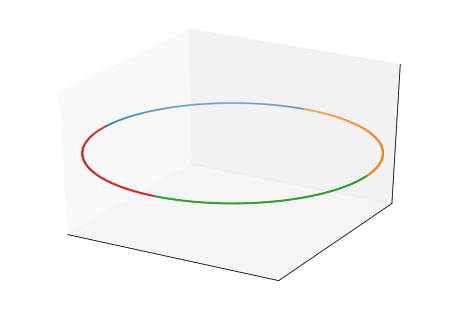

ae-action-q


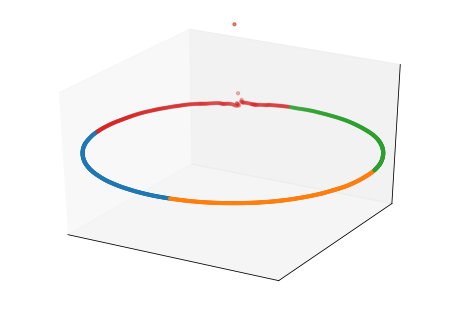

ae-action-alg


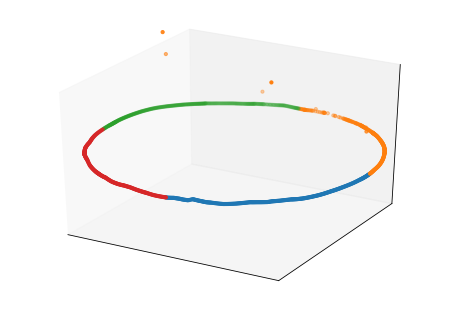

ae-action-s2s2


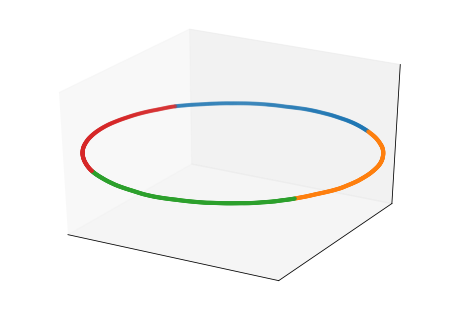

ae-action-s2s1


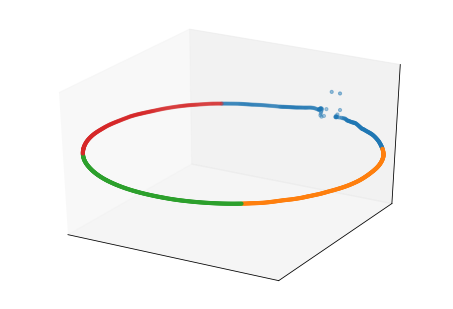

ae-mlp-q


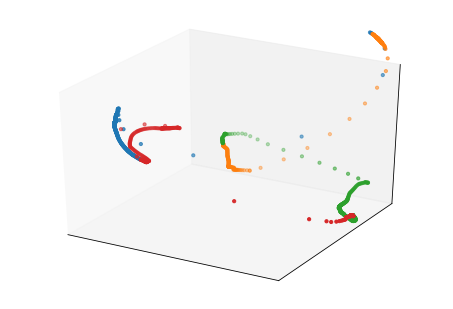

ae-mlp-alg


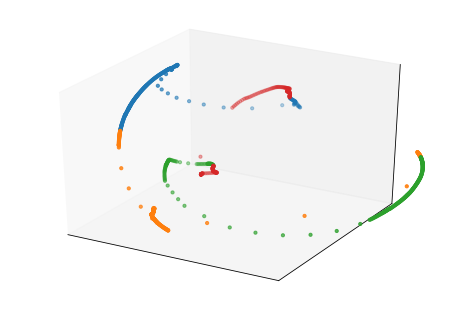

ae-mlp-s2s2


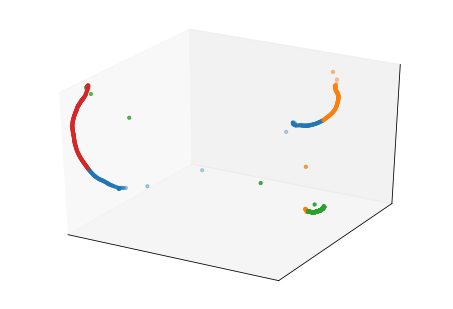

ae-mlp-s2s1


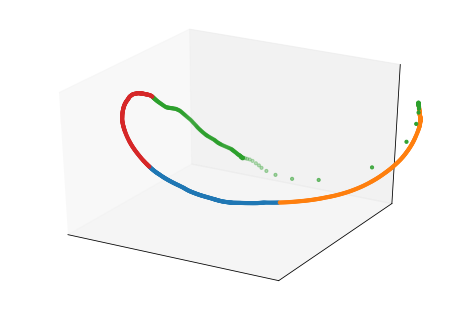

ae-action-normal3


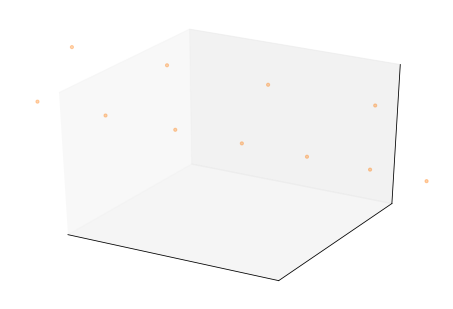

ae-mlp-normal30


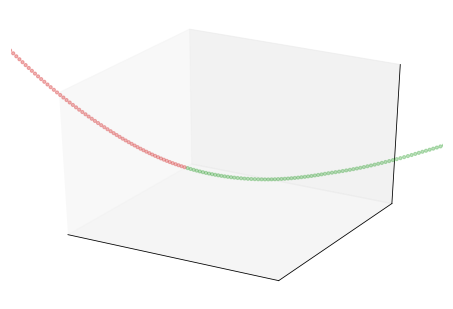

ae-mlp-normal3


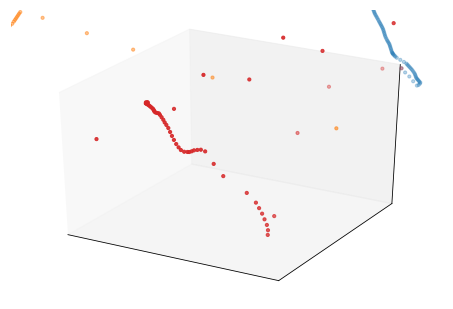

ae-action-vmfq


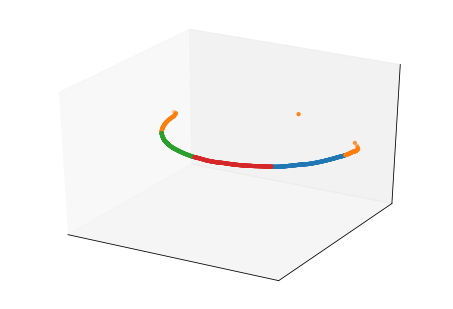

ae-mlp-vmf


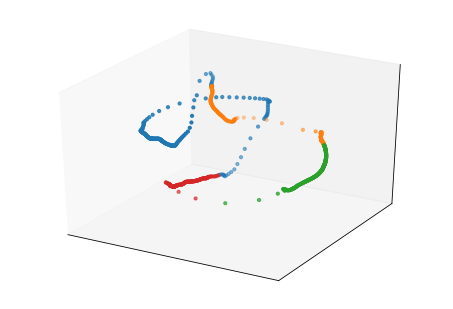

vae-action-q


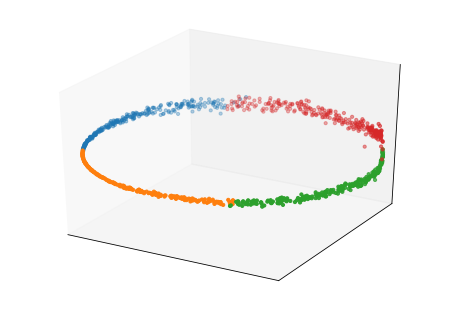

vae-action-alg


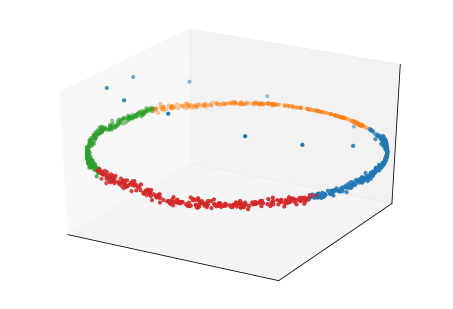

vae-action-s2s2


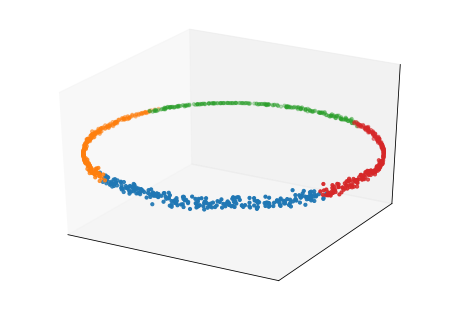

vae-action-s2s1


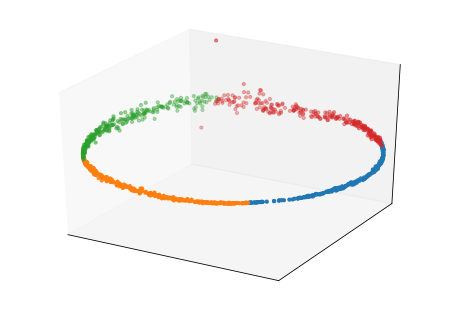

vae-mlp-q


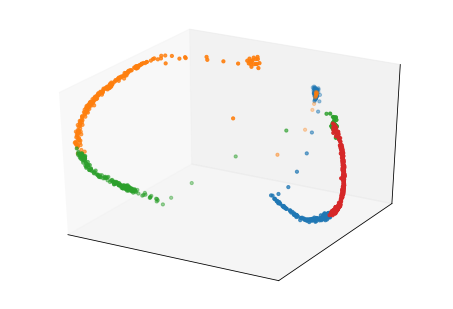

vae-mlp-alg


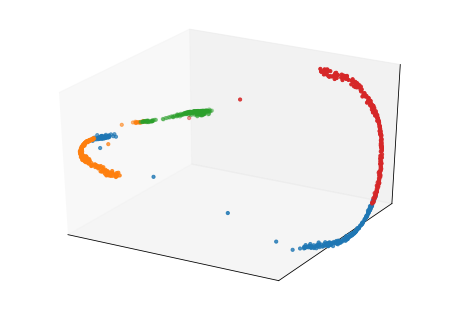

vae-mlp-s2s2


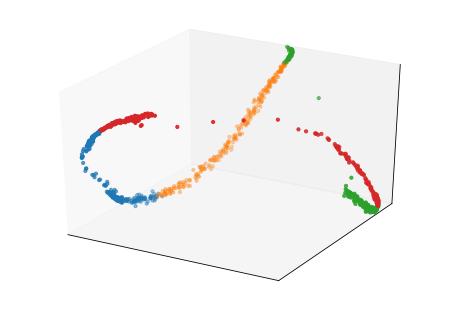

vae-mlp-s2s1


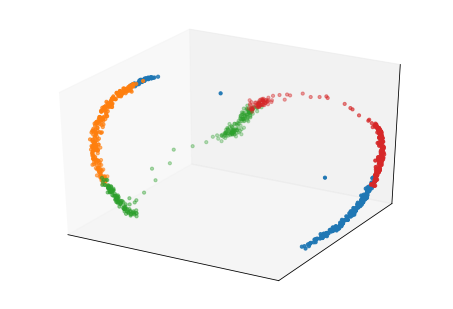

vae-action-normal3


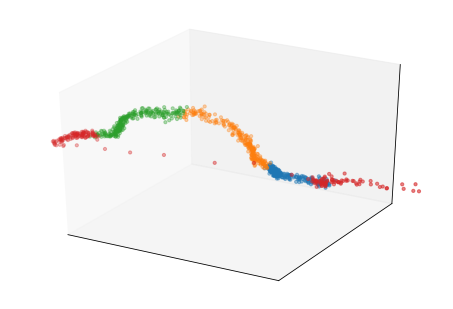

vae-mlp-normal30


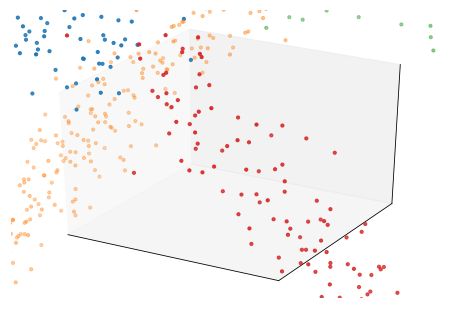

vae-mlp-normal3


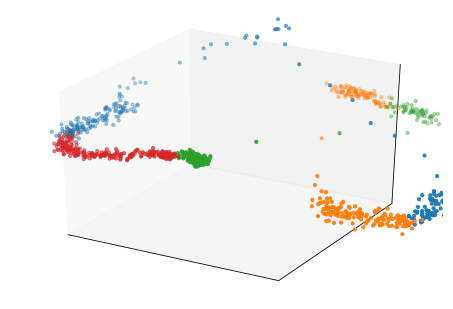

vae-action-vmfq


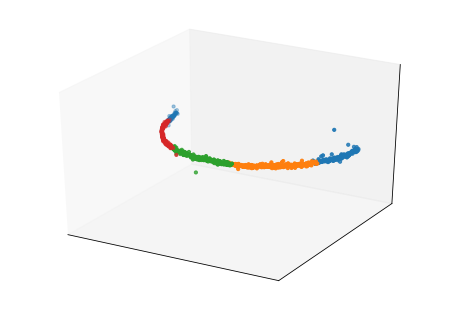

vae-mlp-vmf


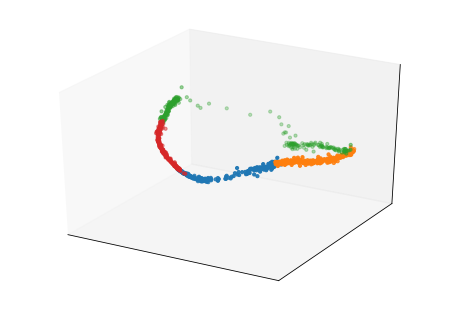

ae-action-vmfq-so3


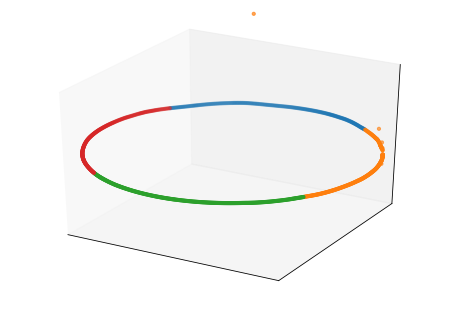

ae-action-normal3-so3


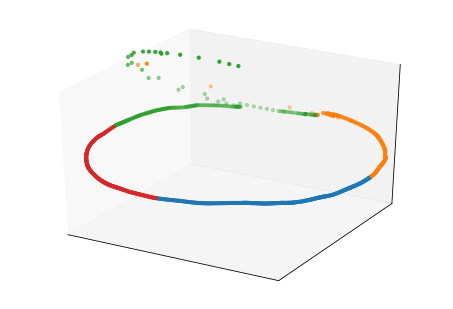

vae-action-vmfq-so3


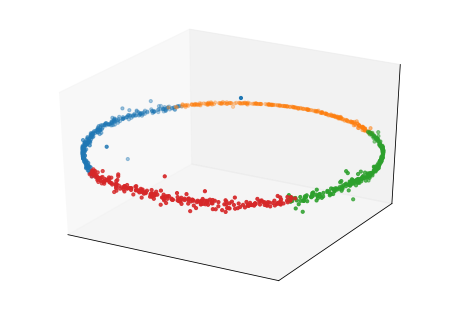

vae-action-normal3-so3


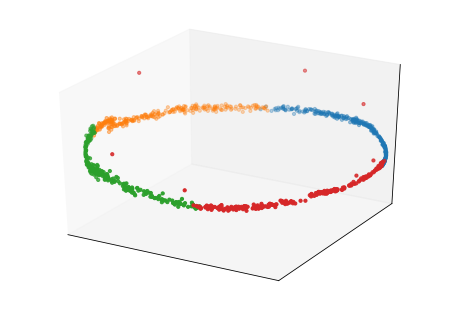

In [27]:
ms = list(models.items())+[('ae-action-vmfq-so3', models['ae-action-vmfq']), ('ae-action-normal3-so3', models['ae-action-normal3']), ('vae-action-vmfq-so3', models['vae-action-vmfq']), ('vae-action-normal3-so3', models['vae-action-normal3'])]

print('Latent spaces')
ax = Axes3D(plt.figure())
x = PCA(3).fit_transform(g.view(g.shape[0], -1))
ax.scatter(*x.T, s=1, c=repeated_colors(g.shape[0], 4))
print('Ground Truth')
ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
ax.set_xlim(-1.1, 1.1), ax.set_ylim(-1.1, 1.1), ax.set_zlim(-1.1, 1.1)
plt.savefig('plots/latent-ground-truth.pdf')
plt.show()

for i, (name, model) in enumerate(ms):
#     if name not in selection:
#         continue
    ax = Axes3D(plt.figure())
    encodings = model.encode(data)[0][0]
    
    if 'action-vmfq-so3' in name:
        encodings = quaternions_to_group_matrix(encodings)
    elif 'action-normal3-so3' in name:
        encodings = torch.tensor(SO3_coordinates(np.asarray(vector_to_eazyz(encodings)), 'EA323', 'MAT')).to(device)
        
    x = PCA(3).fit_transform(encodings.view(g.shape[0], -1))
    ax.scatter(*x.T, s=10, c=repeated_colors(x.shape[0], 4))
    print(name)
    ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
    ax.set_xlim(-1.1, 1.1), ax.set_ylim(-1.1, 1.1), ax.set_zlim(-1.1, 1.1)
    plt.savefig('plots/latent-'+name+'.pdf')
    plt.show()

Reconstruction
Ground truth


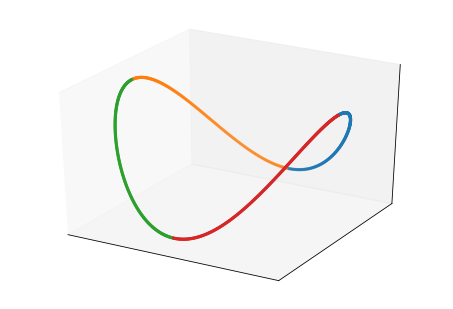

ae-action-q


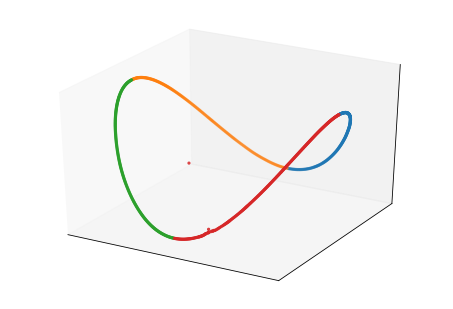

ae-action-alg


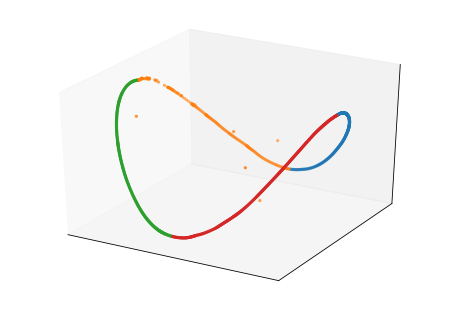

ae-action-s2s2


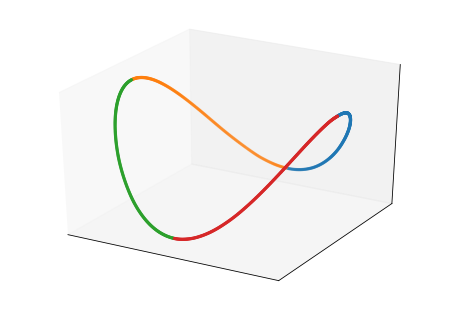

ae-action-s2s1


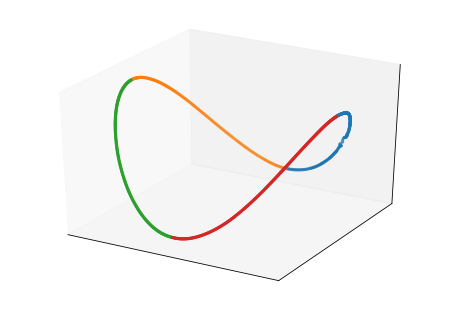

ae-action-vmfq


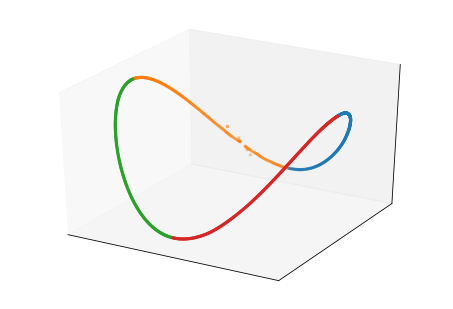

ae-action-vmfq-so3


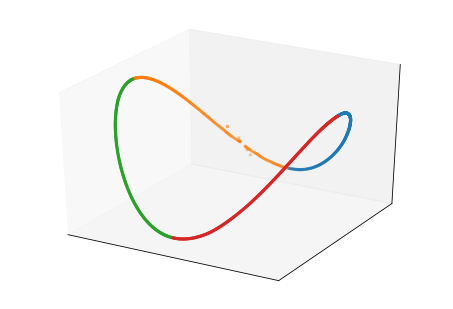

ae-action-normal3-so3


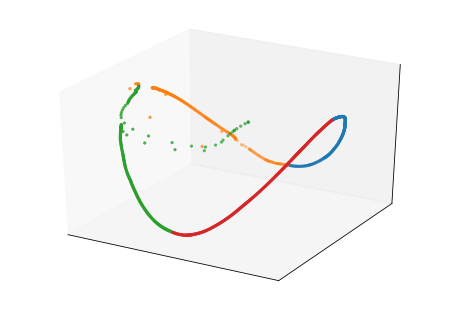

In [28]:
print('Reconstruction')
ms = list(models.items())+[('ae-action-vmfq-so3', models['ae-action-vmfq']), ('ae-action-normal3-so3', models['ae-action-normal3']), ('vae-action-vmfq-so3', models['vae-action-vmfq']), ('vae-action-normal3-so3', models['vae-action-normal3'])]

ax = Axes3D(plt.figure())
pca = PCA(3)
x = pca.fit_transform(data.view(g.shape[0], -1))
ax.scatter(*x.T, s=5, c=repeated_colors(g.shape[0], 4))
print('Ground truth')
ax.set_xlim(-6, 6), ax.set_ylim(-6, 6), ax.set_zlim(-6, 6)
ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
plt.savefig('plots/reconstruction-ground-truth.pdf')
plt.show()

for i, (name, model) in enumerate(ms):
    if name not in selection:
        continue
    ax = Axes3D(plt.figure())
    recons = model.forward(data)[0]
    x = pca.transform(recons.view(g.shape[0], -1))
    ax.scatter(*x.T, s=5, c=repeated_colors(x.shape[0], 4))
    print(name)
    ax.set_xlim(-6, 6), ax.set_ylim(-6, 6), ax.set_zlim(-6, 6)
    ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
    plt.savefig('plots/reconstruction-'+name+'.pdf')
    plt.show()

Mean squared difference per step along random walk. Mean subtracted.
ae-action-q scatterplot


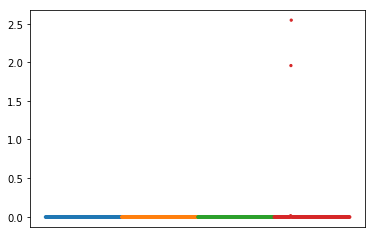

ae-action-alg scatterplot


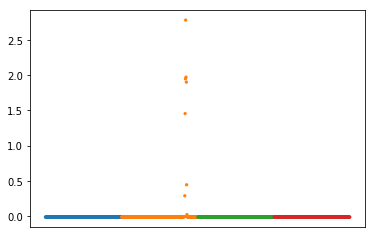

ae-action-s2s2 scatterplot


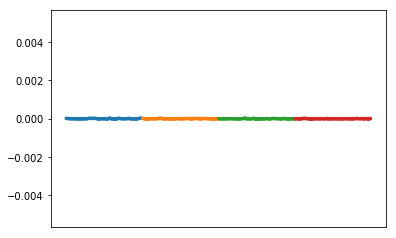

ae-action-s2s1 scatterplot


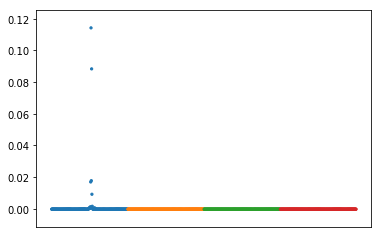

ae-action-vmfq scatterplot


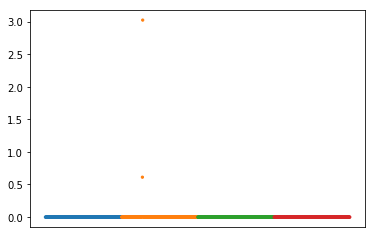

ae-action-vmfq-so3 scatterplot


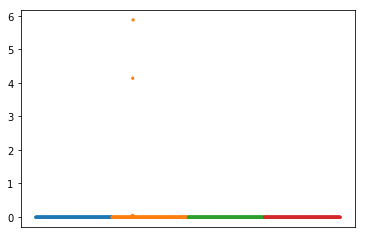

ae-action-normal3-so3 scatterplot


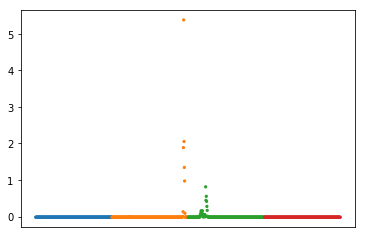

In [30]:
rows = 10

ms = list(models.items())+[('ae-action-vmfq-so3', models['ae-action-vmfq']), ('ae-action-normal3-so3', models['ae-action-normal3'])]

# cols = int(np.ceil((len(ms)+1) / rows)) * 2
# fig = plt.figure(figsize=(6*cols, 6*rows))
print('Mean squared difference per step along random walk. Mean subtracted.')
for i, (name, model) in enumerate(ms):
    if name not in selection:
        continue
    encodings = model.encode(data)[0][0]
    
    if name == 'ae-action-vmfq-so3':
        encodings = quaternions_to_group_matrix(encodings)
    elif name == 'ae-action-normal3-so3':
        encodings = torch.tensor(SO3_coordinates(np.asarray(vector_to_eazyz(encodings)), 'EA323', 'MAT')).to(device)
    
    disc = discontinuities(encodings, zero_mean=True)

    plt.scatter(np.arange(disc.shape[0]), disc, s=5, c=repeated_colors(g.shape[0], 4))
    plt.xticks([])
    print(name + ' scatterplot')
    plt.savefig('plots/discontinuity-'+name+'.pdf')
    plt.show()